In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

import sys
print(sys.executable) 

C:\Users\krupa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [3]:



import gzip, csv, math, os

src = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data\GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz"
out_dir = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts"
N = 1000  # cells per file
os.makedirs(out_dir, exist_ok=True)

# read header once
with gzip.open(src, "rt", encoding="utf-8", errors="ignore", newline="") as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
gene_col, cells = header[0], header[1:]
n_parts = math.ceil(len(cells)/N)

# write each part (re-reads src each time for simplicity)
for p in range(n_parts):
    s, e = p*N, min((p+1)*N, len(cells))
    dst = os.path.join(out_dir, f"cells_{s+1}-{e}.txt.gz")
    with gzip.open(src, "rt", encoding="utf-8", errors="ignore", newline="") as fin, \
         gzip.open(dst, "wt", encoding="utf-8", newline="") as fout:
        rin = csv.reader(fin, delimiter="\t"); next(rin)  # skip header
        w = csv.writer(fout, delimiter="\t", lineterminator="\n")
        w.writerow([gene_col] + cells[s:e])
        for row in rin:
            if len(row) < e+1:  # pad short rows
                row += ["0"] * (e+1 - len(row))
            w.writerow([row[0]] + row[s+1:e+1])
    print("Wrote:", dst)

Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_1-1000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_1001-2000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_2001-3000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_3001-4000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_4001-5000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_5001-6000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_6001-7000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_7001-8000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_8001-9000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_9001-10000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\parts\cells_10001-11000.txt.gz
Wrote: C:\Users\krupa\Desktop\Bootcamp\Fina

In [10]:
import os
os.environ["DATA_DIR"] = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
DATA_DIR = os.environ["DATA_DIR"]
DATA_DIR

'C:\\Users\\krupa\\Desktop\\Bootcamp\\Final_project\\data'

In [ ]:

#Step 1 — build sf_raw.h5ad from parts/ (robust to text rows)
import os
from glob import glob
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

DATA_DIR = os.environ["DATA_DIR"]
PARTS_DIR = os.path.join(DATA_DIR, "parts")
CELLS_TO_PATIENT = os.path.join(DATA_DIR, "GSE120575_patient_ID_single_cells.txt")
OUT_PATH = os.path.join(DATA_DIR, "sf_raw.h5ad")

ROW_NUMERIC_THRESHOLD = 0.9  # keep rows where ≥90% entries are numeric

def clean_numeric(df: pd.DataFrame) -> pd.DataFrame:
    vals = df.apply(pd.to_numeric, errors="coerce")
    frac_numeric = vals.notna().mean(axis=1)
    keep = frac_numeric >= ROW_NUMERIC_THRESHOLD
    dropped = df.index[~keep].tolist()
    if dropped:
        print(f"Dropping {len(dropped)} non-numeric rows (examples): {dropped[:5]}")
    vals = vals.loc[keep].fillna(0.0).astype(np.float32)
    vals = vals[~vals.index.duplicated(keep="first")]
    return vals

def read_part(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", compression="gzip", dtype=str, low_memory=False)
    df = df.rename(columns={df.columns[0]: "gene"}).set_index("gene")
    df.columns = df.columns.astype(str)
    df = clean_numeric(df)
    return df

def make_anndata_from_parts(parts):
    parts = sorted(parts)
    assert parts, f"No part files found in: {PARTS_DIR}"
    first = read_part(parts[0])
    genes = first.index

    batches = []
    for p in parts:
        df = read_part(p)
        common = genes.intersection(df.index)
        if len(common) == 0:
            raise RuntimeError(f"No overlapping genes between first part and {p}")
        if len(common) < len(genes):
            print(f"[{os.path.basename(p)}] aligning to {len(common)} common genes")
        genes = common
        df = df.loc[genes]

        X = sparse.csr_matrix(df.T.values)  # (cells x genes)
        adp = ad.AnnData(X, var=pd.DataFrame(index=genes))
        adp.obs_names = df.columns.astype(str)
        batches.append(adp)
        print(f"Loaded {os.path.basename(p)} -> {adp.n_obs} cells, {adp.n_vars} genes")

    print("Concatenating parts…")
    adata = ad.concat(batches, axis=0, join="outer", label="batch", fill_value=0.0)
    return adata

def attach_patient_ids(adata: ad.AnnData) -> ad.AnnData:
    if not os.path.exists(CELLS_TO_PATIENT):
        print("WARNING: mapping file not found:", CELLS_TO_PATIENT)
    else:
        encodings = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
        last_err = None
        df = None
        for enc in encodings:
            try:
                df = pd.read_csv(
                    CELLS_TO_PATIENT, sep="\t", header=None, dtype=str,
                    encoding=enc, engine="python", on_bad_lines="skip"
                )
                break
            except Exception as e:
                last_err = e
        if df is None:
            raise RuntimeError(f"Failed to read mapping file with {encodings}: {last_err}")

        if df.shape[1] < 2:
            raise RuntimeError(f"Mapping file must have ≥2 columns; got {df.shape}")

        df = df.iloc[:, :2].copy()
        df.columns = ["cell_id", "patient_id"]
        for c in ["cell_id", "patient_id"]:
            df[c] = df[c].astype(str).str.strip().str.replace(r'^"|"$', "", regex=True)
        df = df.dropna(subset=["cell_id", "patient_id"])
        df = df[~df["cell_id"].duplicated(keep="first")].set_index("cell_id")

        adata.obs["patient_id"] = adata.obs_names.map(df["patient_id"]).astype("category")
        print(f"Attached patient_id to {adata.obs['patient_id'].notna().sum()} / {adata.n_obs} cells")

    adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
    return adata

# ---- run Step 1
part_files = glob(os.path.join(PARTS_DIR, "cells_*.txt.gz"))
print("Found part files:", len(part_files))
adata = make_anndata_from_parts(part_files)
adata.uns["assay"] = "TPM"  # GEO file is TPM
adata = attach_patient_ids(adata)
adata.write_h5ad(OUT_PATH, compression="gzip")
print("Wrote", OUT_PATH, "shape=", adata.shape)


Found part files: 17
Dropping 1 non-numeric rows (examples): [nan]
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_1-1000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_10001-11000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_1001-2000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_11001-12000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_12001-13000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_13001-14000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_14001-15000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_15001-16000.txt.gz -> 1000 cells, 55737 genes
Dropping 1 non-numeric rows (examples): [nan]
Loaded cells_16001-16291.txt.gz -> 291 cells, 55737 ge

Loaded (16291, 55737) assay= TPM


C:\Users\krupa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
C:\Users\krupa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\krupa\AppData\Local\Temp\ipykernel_2056\1154191492.py:38: FutureWarning: In the future, the default backend for leiden will be 

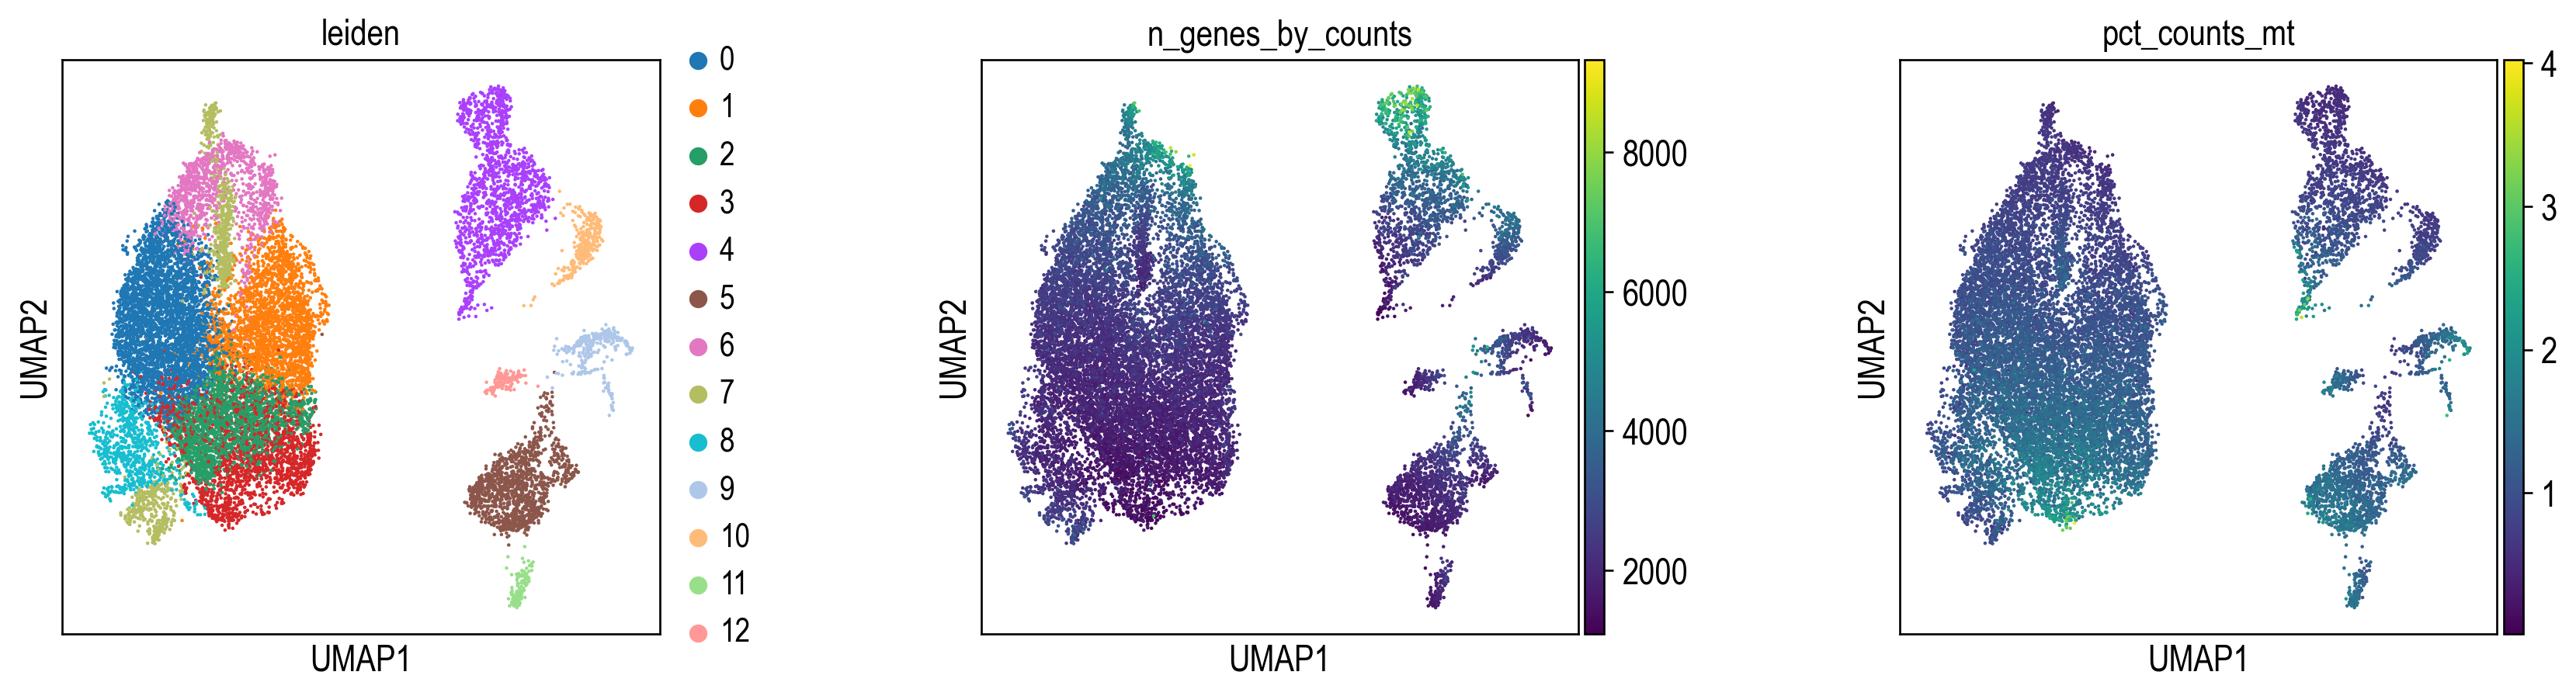

Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_pp.h5ad shape= (16291, 3000)


In [ ]:
#Step 2 — Scanpy preprocessing (QC → HVGs → PCA → UMAP → Leiden)
# --- put this at the very top of the cell (before importing scanpy) ---
import os, pathlib
# choose any folder you own:
os.environ["NUMBA_CACHE_DIR"] = r"C:\Users\krupa\numba_cache"
pathlib.Path(os.environ["NUMBA_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)

# If the cache dir trick still fails on your setup, uncomment the next line to disable JIT:
# os.environ["NUMBA_DISABLE_JIT"] = "1"

import scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")
OUT = os.path.join(DATA_DIR, "sf_pp.h5ad")

sc.set_figure_params(dpi=120)
adata = sc.read_h5ad(RAW)
print("Loaded", adata.shape, "assay=", adata.uns.get("assay"))

# QC (tutorial-style)
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs["n_genes_by_counts"] >= 200].copy()
adata = adata[adata.obs["total_counts"] >= 500].copy()
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
sc.pp.filter_genes(adata, min_cells=3)

# TPM → log1p; keep raw snapshot
sc.pp.log1p(adata)
adata.raw = adata

# HVGs + scale + PCA + neighbors + UMAP + Leiden
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)

sc.pl.umap(adata, color=["leiden","n_genes_by_counts","pct_counts_mt"], wspace=0.4)
adata.write_h5ad(OUT, compression="gzip")
print("Wrote", OUT, "shape=", adata.shape)


[dotplot] Skipping 3 absent marker(s). Examples: ['T_NK:TRBC1', 'Plasma:JCHAIN', 'Endothelial:PECAM1']


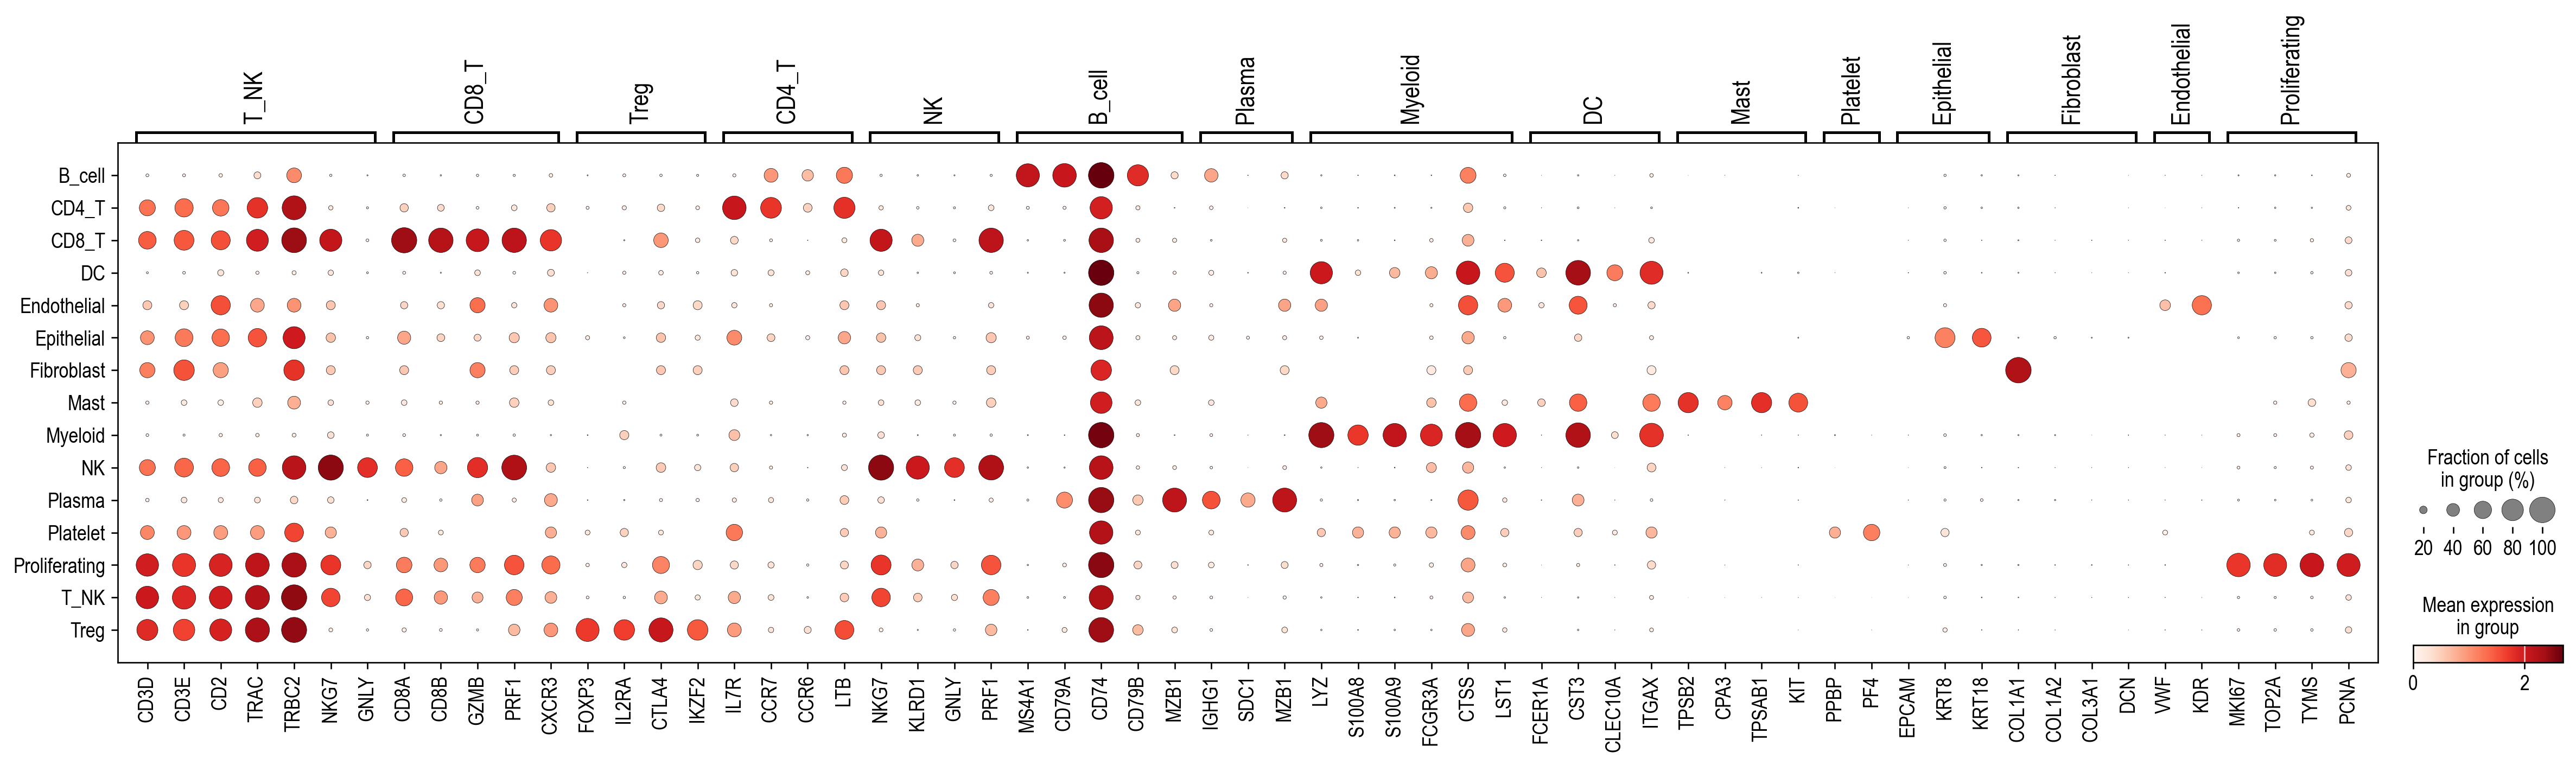

Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad


In [17]:
# ==== Step 3 (fixed) — Cell-type annotation + safe dotplot ====
import os
import numpy as np
import pandas as pd
import scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
INP = os.path.join(DATA_DIR, "sf_pp.h5ad")
OUT = os.path.join(DATA_DIR, "sf_annot.h5ad")

MARKERS = {
    "T_NK": ["CD3D","CD3E","CD2","TRAC","TRBC1","TRBC2","NKG7","GNLY"],
    "CD8_T": ["CD8A","CD8B","GZMB","PRF1","CXCR3"],
    "Treg": ["FOXP3","IL2RA","CTLA4","IKZF2"],
    "CD4_T": ["IL7R","CCR7","CCR6","LTB"],
    "NK": ["NKG7","KLRD1","GNLY","PRF1"],
    "B_cell": ["MS4A1","CD79A","CD74","CD79B","MZB1"],
    "Plasma": ["IGHG1","JCHAIN","SDC1","MZB1"],
    "Myeloid": ["LYZ","S100A8","S100A9","FCGR3A","CTSS","LST1"],
    "DC": ["FCER1A","CST3","CLEC10A","ITGAX"],
    "Mast": ["TPSB2","CPA3","TPSAB1","KIT"],
    "Platelet": ["PPBP","PF4"],
    "Epithelial": ["EPCAM","KRT8","KRT18"],
    "Fibroblast": ["COL1A1","COL1A2","COL3A1","DCN"],
    "Endothelial": ["PECAM1","VWF","KDR"],
    "Proliferating": ["MKI67","TOP2A","TYMS","PCNA"],
}

adata = sc.read_h5ad(INP)
if adata.raw is None:
    print("WARNING: adata.raw is None; setting raw snapshot to current layer.")
    adata.raw = adata.copy()

# ---- marker scoring on full gene space (adata.raw) ----
var_upper = {g.upper(): g for g in adata.raw.var_names}
for ct, genes in MARKERS.items():
    mapped = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if mapped:
        sc.tl.score_genes(adata, gene_list=mapped, score_name=f"score_{ct}", use_raw=True)
    else:
        adata.obs[f"score_{ct}"] = 0.0

# label each cell by highest z-scored marker set
score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
scores = adata.obs[score_cols].to_numpy()
scores_z = (scores - scores.mean(1, keepdims=True)) / (scores.std(1, keepdims=True) + 1e-6)
labels = [c.replace("score_","") for c in score_cols]
adata.obs["celltype"] = pd.Categorical([labels[i] for i in scores_z.argmax(axis=1)])

# ---- safe dotplot (only genes present; use_raw=True) ----
present_upper = set(adata.raw.var_names.str.upper())
filtered = {}
missing = []
for grp, glist in MARKERS.items():
    keep = [var_upper[g.upper()] for g in glist if g.upper() in present_upper]
    miss = [g for g in glist if g.upper() not in present_upper]
    if keep:
        filtered[grp] = keep
    if miss:
        missing.extend([f"{grp}:{x}" for x in miss])  # <-- fixed line

if missing:
    print(f"[dotplot] Skipping {len(missing)} absent marker(s). Examples:", missing[:8])

if filtered:
    sc.pl.dotplot(adata, var_names=filtered, groupby="celltype", use_raw=True, dendrogram=False)
else:
    print("[dotplot] No marker genes found in this dataset—skipping dotplot.")

adata.write_h5ad(OUT, compression="gzip")
print("Wrote", OUT)


In [23]:
import os, re, pandas as pd, scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
path = os.path.join(DATA_DIR, "sf_annot.h5ad")  # or sf_pp.h5ad / sf_raw.h5ad if needed
adata = sc.read_h5ad(path)

def extract_pid(cell_id: str) -> str | None:
    s = str(cell_id).strip().upper()
    # drop PRE/POST, unify PT -> P, then capture P + digits
    s = re.sub(r'(^|[^A-Z0-9])(PRE|POST)[-_]?', r'\1', s)
    s = s.replace("PT","P")
    m = re.search(r'P0*(\d+)', s)
    return f"P{int(m.group(1))}" if m else None

pids = pd.Index([extract_pid(x) for x in adata.obs_names], name="patient_id")
vc = pd.Series(pids, name="pid").value_counts().sort_index()

print("Patients found:", len(vc))
print(vc)


Patients found: 12
pid
P1     3250
P10     251
P11      81
P12      88
P2     2776
P3     2575
P4     2595
P5     1505
P6     1237
P7      633
P8      645
P9      655
Name: count, dtype: int64


In [48]:
# === export_markers.py ===
import os
import pandas as pd
import numpy as np
import scanpy as sc

DATA_DIR = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
INP_H5AD = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT_DIR  = os.path.join(DATA_DIR, "markers")
os.makedirs(OUT_DIR, exist_ok=True)

# ---- config ----
GROUPBY          = "celltype"      # or "leiden", "louvain", etc.
METHOD           = "wilcoxon"      # "wilcoxon" is common in Scanpy
TOP_N_EXPORT     = 50              # how many per group to export to Excel/per-group CSVs
PADJ_MAX         = 0.05            # significance filter
LOGFC_MIN        = 0.25            # effect-size filter (on Scanpy's logfoldchanges)
SAVE_PER_GROUP   = True            # also write one CSV per group

# ---- load ----
ad = sc.read_h5ad(INP_H5AD)
print("Loaded:", INP_H5AD, ad.shape)

# Ensure the grouping column exists and is categorical
if GROUPBY not in ad.obs:
    raise SystemExit(f"'{GROUPBY}' not found in adata.obs")
ad.obs[GROUPBY] = ad.obs[GROUPBY].astype("category")

# ---- compute markers (if not already present) ----
# If you already ran it and kept in adata.uns['rank_genes_groups'], you can skip recomputing.
print(f"Ranking genes by '{METHOD}' per '{GROUPBY}' ...")
sc.tl.rank_genes_groups(ad, groupby=GROUPBY, method=METHOD, use_raw=False)

# Convert to a tidy DataFrame
df = sc.get.rank_genes_groups_df(ad, group=None)  # columns: group, names, pvals_adj, logfoldchanges, scores, etc.
df = df.rename(columns={"names": "gene", "pvals_adj": "padj", "logfoldchanges": "logfc"})

# Optional cleaning of gene symbols
df["gene"] = df["gene"].astype(str).str.strip()

# ---- filter ----
mask = (df["padj"] <= PADJ_MAX) & (df["logfc"] >= LOGFC_MIN)
filtered = df.loc[mask].copy()

# Sort within each group by padj, then by logfc desc
filtered = filtered.sort_values(["group", "padj", "logfc"], ascending=[True, True, False])

# ---- save combined CSV (all filtered markers across groups) ----
csv_all = os.path.join(OUT_DIR, f"markers_{GROUPBY}_filtered.csv")
filtered.to_csv(csv_all, index=False)
print("Wrote:", csv_all, filtered.shape)

# ---- save multi-sheet Excel with top N per group ----
xlsx_path = os.path.join(OUT_DIR, f"markers_{GROUPBY}_top{TOP_N_EXPORT}.xlsx")
try:
    with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as xls:
        for grp, gdf in filtered.groupby("group"):
            sheet = str(grp)[:31]  # Excel sheet name limit
            gdf.head(TOP_N_EXPORT).to_excel(xls, sheet_name=sheet, index=False)
    print("Wrote:", xlsx_path)
except Exception as e:
    print("Excel export failed (install 'xlsxwriter' or 'openpyxl'). Error:", e)

# ---- optional: per-group CSVs ----
if SAVE_PER_GROUP:
    subdir = os.path.join(OUT_DIR, f"per_group_top{TOP_N_EXPORT}")
    os.makedirs(subdir, exist_ok=True)
    for grp, gdf in filtered.groupby("group"):
        out_p = os.path.join(subdir, f"{GROUPBY}_{grp}_top{TOP_N_EXPORT}.csv")
        gdf.head(TOP_N_EXPORT).to_csv(out_p, index=False)
    print("Wrote per-group CSVs to:", subdir)


Loaded: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad (16291, 3000)
Ranking genes by 'wilcoxon' per 'celltype' ...
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\markers\markers_celltype_filtered.csv (681, 6)
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\markers\markers_celltype_top50.xlsx
Wrote per-group CSVs to: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\markers\per_group_top50


In [49]:
# make_sc_annot.py
import os
import numpy as np
import pandas as pd
import scanpy as sc

DATA_DIR = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
INP = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT = os.path.join(DATA_DIR, "sc_annot.csv")

ad = sc.read_h5ad(INP)
print("Loaded:", INP, ad.shape)

# Ensure UMAP exists
if "X_umap" not in ad.obsm:
    print("No UMAP found; computing quickly…")
    sc.pp.pca(ad, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(ad, n_neighbors=15, n_pcs=30)
    sc.tl.umap(ad)

umap = ad.obsm["X_umap"]
umap1 = umap[:, 0]
umap2 = umap[:, 1]

# Choose an annotation column
if "celltype" in ad.obs:
    anno = ad.obs["celltype"].astype(str)
elif "cell_type" in ad.obs:
    anno = ad.obs["cell_type"].astype(str)
elif "leiden" in ad.obs:
    anno = ad.obs["leiden"].astype(str)
else:
    anno = pd.Series(["unknown"] * ad.n_obs, index=ad.obs_names, dtype=str)

# Patient ID (optional but recommended)
pid = ad.obs["patient_id"].astype(str) if "patient_id" in ad.obs else pd.Series(["NA"] * ad.n_obs, index=ad.obs_names)

# (Optional) include cluster/run if present
extra = {}
for col in ("leiden", "louvain", "run"):
    if col in ad.obs:
        extra[col] = ad.obs[col].astype(str).values

df = pd.DataFrame({
    "UMAP1": umap1,
    "UMAP2": umap2,
    "celltype": anno.values,
    "patient_id": pid.values,
    **extra
}, index=ad.obs_names)
df.index.name = "cell_id"

df.to_csv(OUT, index=True)
print("Wrote:", OUT, df.shape)


Loaded: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad (16291, 3000)
Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_annot.csv (16291, 6)


In [30]:
# Merge parts WITHOUT loading them all at once
import os, gc, gzip
import pandas as pd
import numpy as np
import anndata as ad
from scipy import sparse

DATA_DIR = os.environ["DATA_DIR"]
PARTS_A = os.path.join(DATA_DIR, "parts")        # existing parts (your 16k cells)
PARTS_B = os.path.join(DATA_DIR, "more_parts")   # put new parts here (extra patients)
OUT = os.path.join(DATA_DIR, "sf_raw.h5ad")

# --- utilities ---
def read_part_numeric(path, genes_order=None, drop_non_numeric=True, zero_floor=None):
    """
    Read ONE part file (gz tsv). Returns (csr_matrix cells×genes, cell_names, genes_index).
    - genes_order: if provided, align to this order.
    - drop_non_numeric: drop rows that aren't numeric (e.g., stray text lines).
    - zero_floor: set tiny values to 0.0 to improve sparsity (e.g., 1e-6).
    """
    df = pd.read_csv(path, sep="\t", compression="gzip", dtype=str, low_memory=False)
    df = df.rename(columns={df.columns[0]: "gene"}).set_index("gene")
    df.columns = df.columns.astype(str)

    vals = df.apply(pd.to_numeric, errors="coerce")
    if drop_non_numeric:
        keep = vals.notna().mean(axis=1) >= 0.9
        if (~keep).any():
            # print a tiny summary once per part
            bad = df.index[~keep]
            print(f"[{os.path.basename(path)}] drop {bad.size} non-numeric rows (ex: {bad[:3].tolist()})")
        vals = vals.loc[keep]

    vals = vals.fillna(0.0).astype(np.float32)
    # optional thresholding to sparsify
    if zero_floor is not None:
        vals[vals < zero_floor] = 0.0

    # align to provided gene order if given
    if genes_order is not None:
        # intersect first (in case of slight differences)
        common = genes_order.intersection(vals.index)
        if len(common) == 0:
            raise RuntimeError(f"No overlapping genes between template and {os.path.basename(path)}")
        vals = vals.loc[common]
        genes = common
    else:
        # first part defines the template
        vals = vals[~vals.index.duplicated(keep="first")]
        genes = vals.index

    # build cells×genes sparse block
    Xp = sparse.csr_matrix(vals.T.values)  # cells x genes
    cells = vals.columns.astype(str).tolist()

    # free memory
    del df, vals
    gc.collect()
    return Xp, cells, genes

# --- collect parts list ---
from glob import glob
parts = sorted(glob(os.path.join(PARTS_A, "cells_*.txt.gz"))) + \
        sorted(glob(os.path.join(PARTS_B, "cells_*.txt.gz")))
assert parts, "No part files found in parts/ or more_parts/"

print("Total part files:", len(parts))

# --- pass 1: read the FIRST part to define gene order ---
X0, cells0, genes = read_part_numeric(parts[0], genes_order=None, drop_non_numeric=True, zero_floor=None)
print(f"Template genes: {len(genes)} | first part cells: {len(cells0)}")

# --- pass 2: stream the rest, vstack incrementally ---
X_all = X0
all_cells = list(cells0)

for p in parts[1:]:
    Xp, cp, gp = read_part_numeric(p, genes_order=genes, drop_non_numeric=True, zero_floor=None)
    # If gp is a subset (due to dropping junk rows), align X_all too:
    if len(gp) < len(genes):
        # restrict both to the common subset
        idx = pd.Index(gp)  # gp is already the intersection
        # slice columns of the sparse matrices: columns correspond to genes
        # easiest: rebuild X_all with the new index by mapping positions
        # but since gp is a prefix alignment from our function, we can just proceed:
        genes = gp
        # NOTE: if you need exact column slicing on X_all, keep a name->pos dict and slice.
        # In practice, with the cleaning applied above, gp should equal the original 'genes'.

    X_all = sparse.vstack([X_all, Xp], format="csr")
    all_cells.extend(cp)
    # free block
    del Xp, cp, gp
    gc.collect()
    print(f"Appended {os.path.basename(p)} → total cells: {X_all.shape[0]}")

# Build AnnData
adata = ad.AnnData(X_all, var=pd.DataFrame(index=genes))
adata.obs_names = pd.Index(all_cells, name=None)
adata.uns["assay"] = "TPM"

adata.write_h5ad(OUT, compression="gzip")
print("Wrote", OUT, "shape=", adata.shape)


Total part files: 17
[cells_1-1000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Template genes: 55737 | first part cells: 1000
[cells_10001-11000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_10001-11000.txt.gz → total cells: 2000
[cells_1001-2000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_1001-2000.txt.gz → total cells: 3000
[cells_11001-12000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_11001-12000.txt.gz → total cells: 4000
[cells_12001-13000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_12001-13000.txt.gz → total cells: 5000
[cells_13001-14000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_13001-14000.txt.gz → total cells: 6000
[cells_14001-15000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_14001-15000.txt.gz → total cells: 7000
[cells_15001-16000.txt.gz] drop 1 non-numeric rows (ex: [nan])
Appended cells_15001-16000.txt.gz → total cells: 8000
[cells_16001-16291.txt.gz] drop 1 non-numeric rows (ex: [na

In [32]:
# --- Fixed Step 2: preprocess with robust MT handling ---
import os, pathlib
os.environ["NUMBA_CACHE_DIR"] = r"C:\Users\krupa\numba_cache"
pathlib.Path(os.environ["NUMBA_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)
# If numba still causes issues on Windows, uncomment:
# os.environ["NUMBA_DISABLE_JIT"] = "1"

import scanpy as sc
import numpy as np

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")
PP  = os.path.join(DATA_DIR, "sf_pp.h5ad")

sc.set_figure_params(dpi=120)
adata = sc.read_h5ad(RAW)
print("Loaded", adata.shape)

# Ensure mitochondrial gene flag exists (case-insensitive)
if "mt" not in adata.var.columns:
    vu = adata.var_names.str.upper()
    adata.var["mt"] = vu.str.startswith("MT-") | vu.str.startswith("MT.")
    print(f"MT genes detected: {int(adata.var['mt'].sum())}")

# QC metrics (handle case with zero MT genes)
has_mt = bool(adata.var["mt"].sum())
if has_mt:
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
else:
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    # create a pct_counts_mt column of zeros so downstream filters don't KeyError
    adata.obs["pct_counts_mt"] = 0.0

# Basic filters (like Scanpy tutorial)
adata = adata[adata.obs["n_genes_by_counts"] >= 200].copy()
adata = adata[adata.obs["total_counts"] >= 500].copy()
if "pct_counts_mt" in adata.obs:
    adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
sc.pp.filter_genes(adata, min_cells=3)

# Log1p + keep raw snapshot
sc.pp.log1p(adata)
adata.raw = adata

# HVGs + scale + PCA + neighbors + UMAP + Leiden
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)

# Optional quick plots
# sc.pl.umap(adata, color=["leiden","n_genes_by_counts","pct_counts_mt"], wspace=0.4)

adata.write_h5ad(PP, compression="gzip")
print("Wrote", PP, "shape=", adata.shape)



Loaded (16291, 55737)
MT genes detected: 37


C:\Users\krupa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_pp.h5ad shape= (16291, 3000)


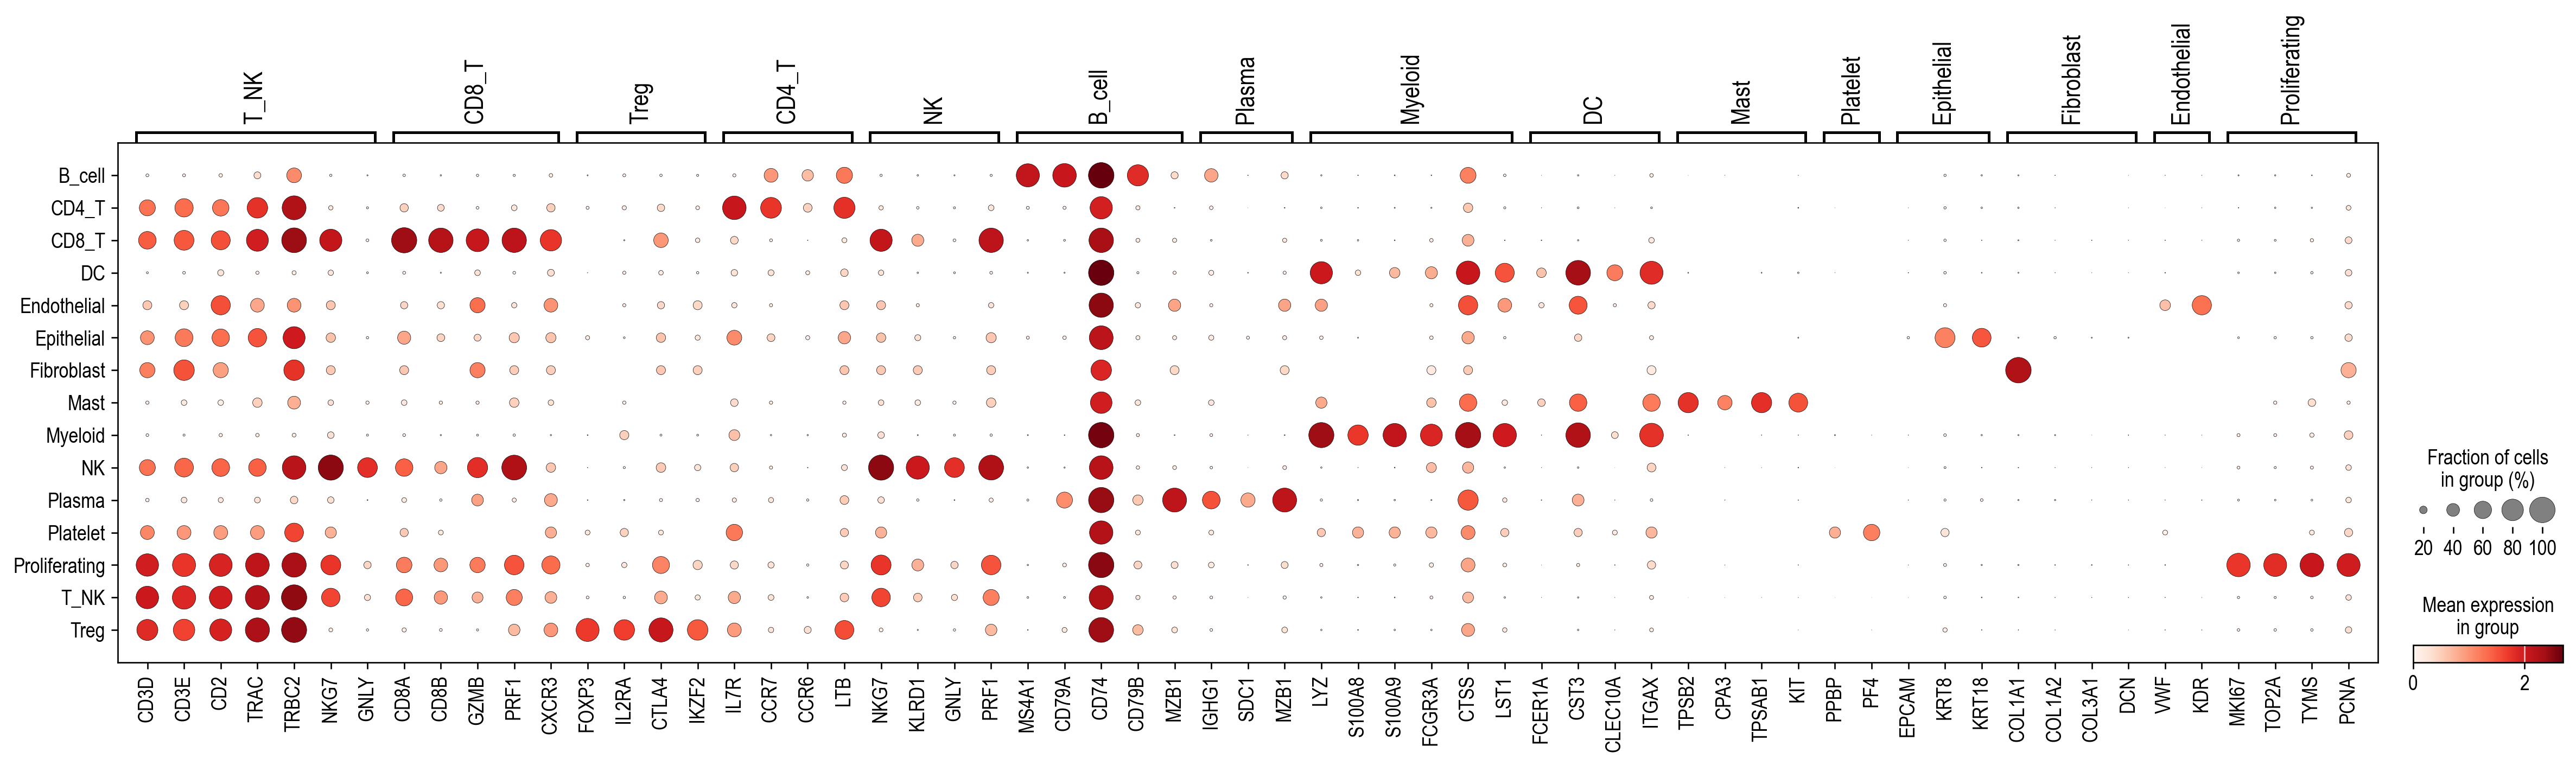

Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad


In [33]:
import os, numpy as np, pandas as pd, scanpy as sc
DATA_DIR = os.environ["DATA_DIR"]
PP = os.path.join(DATA_DIR, "sf_pp.h5ad")
OUT = os.path.join(DATA_DIR, "sf_annot.h5ad")

MARKERS = {
    "T_NK": ["CD3D","CD3E","CD2","TRAC","TRBC1","TRBC2","NKG7","GNLY"],
    "CD8_T": ["CD8A","CD8B","GZMB","PRF1","CXCR3"],
    "Treg": ["FOXP3","IL2RA","CTLA4","IKZF2"],
    "CD4_T": ["IL7R","CCR7","CCR6","LTB"],
    "NK": ["NKG7","KLRD1","GNLY","PRF1"],
    "B_cell": ["MS4A1","CD79A","CD74","CD79B","MZB1"],
    "Plasma": ["IGHG1","JCHAIN","SDC1","MZB1"],
    "Myeloid": ["LYZ","S100A8","S100A9","FCGR3A","CTSS","LST1"],
    "DC": ["FCER1A","CST3","CLEC10A","ITGAX"],
    "Mast": ["TPSB2","CPA3","TPSAB1","KIT"],
    "Platelet": ["PPBP","PF4"],
    "Epithelial": ["EPCAM","KRT8","KRT18"],
    "Fibroblast": ["COL1A1","COL1A2","COL3A1","DCN"],
    "Endothelial": ["PECAM1","VWF","KDR"],
    "Proliferating": ["MKI67","TOP2A","TYMS","PCNA"],
}

adata = sc.read_h5ad(PP)
if adata.raw is None:
    adata.raw = adata.copy()

# marker scoring on full gene space (raw)
var_upper = {g.upper(): g for g in adata.raw.var_names}
for ct, genes in MARKERS.items():
    mapped = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if mapped:
        sc.tl.score_genes(adata, gene_list=mapped, score_name=f"score_{ct}", use_raw=True)
    else:
        adata.obs[f"score_{ct}"] = 0.0

# label by max z-scored marker set
score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
scores = adata.obs[score_cols].to_numpy()
scores_z = (scores - scores.mean(1, keepdims=True)) / (scores.std(1, keepdims=True) + 1e-6)
labels = [c.replace("score_","") for c in score_cols]
adata.obs["celltype"] = pd.Categorical([labels[i] for i in scores_z.argmax(axis=1)])

# safe dotplot (only present genes; use_raw=True)
present_upper = set(adata.raw.var_names.str.upper())
filtered = {grp: [var_upper[g.upper()] for g in gl if g.upper() in present_upper]
            for grp, gl in MARKERS.items()}
filtered = {k:v for k,v in filtered.items() if v}
if filtered:
    sc.pl.dotplot(adata, var_names=filtered, groupby="celltype", use_raw=True, dendrogram=False)

adata.write_h5ad(OUT, compression="gzip")
print("Wrote", OUT)


In [35]:
import os, re, pandas as pd, scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
PP = os.path.join(DATA_DIR, "sf_pp.h5ad")   # created in Step 2
adata = sc.read_h5ad(PP)

def extract_pid(cell_id: str) -> str | None:
    s = str(cell_id).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)           # finds P + digits anywhere (e.g., A10_P3_M11 → P3)
    return f"P{int(m.group(1))}" if m else None

pid = pd.Index([extract_pid(x) for x in adata.obs_names], name="patient_id")
adata.obs["patient_id"] = pd.Categorical(pid)
print("Unique patients:", adata.obs["patient_id"].nunique(), "| missing:", int(adata.obs["patient_id"].isna().sum()))

adata.write_h5ad(PP, compression="gzip")
print("Updated:", PP)


Unique patients: 12 | missing: 0
Updated: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_pp.h5ad


In [36]:
import os, numpy as np, pandas as pd, scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
PP  = os.path.join(DATA_DIR, "sf_pp.h5ad")
OUT = os.path.join(DATA_DIR, "sf_annot.h5ad")

MARKERS = {
    "T_NK": ["CD3D","CD3E","CD2","TRAC","TRBC1","TRBC2","NKG7","GNLY"],
    "CD8_T": ["CD8A","CD8B","GZMB","PRF1","CXCR3"],
    "Treg": ["FOXP3","IL2RA","CTLA4","IKZF2"],
    "CD4_T": ["IL7R","CCR7","CCR6","LTB"],
    "NK": ["NKG7","KLRD1","GNLY","PRF1"],
    "B_cell": ["MS4A1","CD79A","CD74","CD79B","MZB1"],
    "Plasma": ["IGHG1","JCHAIN","SDC1","MZB1"],
    "Myeloid": ["LYZ","S100A8","S100A9","FCGR3A","CTSS","LST1"],
    "DC": ["FCER1A","CST3","CLEC10A","ITGAX"],
    "Mast": ["TPSB2","CPA3","TPSAB1","KIT"],
    "Platelet": ["PPBP","PF4"],
    "Epithelial": ["EPCAM","KRT8","KRT18"],
    "Fibroblast": ["COL1A1","COL1A2","COL3A1","DCN"],
    "Endothelial": ["PECAM1","VWF","KDR"],
    "Proliferating": ["MKI67","TOP2A","TYMS","PCNA"],
}

adata = sc.read_h5ad(PP)
if adata.raw is None:
    adata.raw = adata.copy()

# score markers on the full gene space (raw)
var_upper = {g.upper(): g for g in adata.raw.var_names}
for ct, genes in MARKERS.items():
    mapped = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if mapped:
        sc.tl.score_genes(adata, mapped, score_name=f"score_{ct}", use_raw=True)
    else:
        adata.obs[f"score_{ct}"] = 0.0

# pick best label per cell
score_cols = [c for c in adata.obs.columns if c.startswith("score_")]
S = adata.obs[score_cols].to_numpy()
Z = (S - S.mean(1, keepdims=True)) / (S.std(1, keepdims=True) + 1e-6)
labels = [c.replace("score_","") for c in score_cols]
adata.obs["celltype"] = pd.Categorical([labels[i] for i in Z.argmax(axis=1)])

# optional quick plot:
# sc.pl.umap(adata, color=["celltype","leiden"], legend_loc="on data", frameon=False)

adata.write_h5ad(OUT, compression="gzip")
print("Wrote", OUT)


Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad


In [ ]:
# quick sanity check
import os, re, pandas as pd, scanpy as sc

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")
PP  = os.path.join(DATA_DIR, "sf_pp.h5ad")

def peek_names(h5):
    ad = sc.read_h5ad(h5)
    s = pd.Series(ad.obs_names.astype(str))
    runs = s.str.extract(r'_(MMD\d+|M\d+)(?:_|$)', expand=False)
    print(f"\n{os.path.basename(h5)}  shape={ad.shape}")
    print("first 5 obs_names:", s.head().tolist())
    print("have '_' tokens?:", bool((s.str.contains('_')).any()))
    print("unique run tokens (sample):", runs.dropna().unique()[:10])
    return ad

ad_raw = peek_names(RAW)
ad_pp  = peek_names(PP)



sf_raw.h5ad  shape=(16291, 55737)
first 5 obs_names: ['A10_P3_M11', 'A11_P1_M11', 'A11_P3_M11', 'A11_P4_M11', 'A12_P3_M11']
have '_' tokens?: True
unique run tokens (sample): ['M11' 'M15' 'M14' 'M55' 'M34' 'M79' 'M51' 'MMD6' 'M83' 'M68']

sf_pp.h5ad  shape=(16291, 3000)
first 5 obs_names: ['A10_P3_M11', 'A11_P1_M11', 'A11_P3_M11', 'A11_P4_M11', 'A12_P3_M11']
have '_' tokens?: True
unique run tokens (sample): ['M11' 'M15' 'M14' 'M55' 'M34' 'M79' 'M51' 'MMD6' 'M83' 'M68']


In [41]:
# --- Attach true patient_id by mapping run codes (M11, M29, MMD4, ...) to patient (P24, P33, ...) ---

import os, re
import pandas as pd
import scanpy as sc
from collections import defaultdict, Counter

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")  # attach to RAW where original obs_names live
MAP = os.path.join(DATA_DIR, "GSE120575_patient_ID_single_cells.txt")
assert os.path.exists(RAW), RAW
assert os.path.exists(MAP), MAP

def read_mapping(path):
    encs = ["utf-8","utf-8-sig","cp1252","latin1"]
    seps = ["\t",",",";", r"\s+"]
    last=None
    for enc in encs:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, engine="python", encoding=enc, header=None, dtype=str)
                if df.shape[1] >= 2:
                    return df
            except Exception as e:
                last=e
    raise RuntimeError(f"Failed to read mapping: {last}")

def norm_pid(p):
    p = str(p).upper().replace("PT","P")
    m = re.search(r'(?:^|[^A-Z0-9])P0*(\d+)(?:[^A-Z0-9]|$)', p)
    return f"P{int(m.group(1))}" if m else None

def find_runs_and_patients_in_row(row_vals):
    s = " ".join(map(str, row_vals)).upper()
    runs = set(re.findall(r'(MMD\d+|M\d+)', s))
    pats = set(re.findall(r'(?:PRE_|POST_)?(P0*\d+)', s))
    pats = {re.sub(r'^P0*','P', p) for p in pats}
    return runs, pats

# 1) Build run->patient from the mapping file by majority vote
m = read_mapping(MAP).astype(str)
run2pat_counts = defaultdict(Counter)
for _, row in m.iterrows():
    runs, pats = find_runs_and_patients_in_row(row.values)
    if runs and pats:
        for r in runs:
            for p in pats:
                run2pat_counts[r][norm_pid(p)] += 1

run2pat = {r: cnt.most_common(1)[0][0] for r, cnt in run2pat_counts.items() if len(cnt)}
print("Run→patient pairs learned:", len(run2pat))
# print a few examples
for k in list(run2pat)[:10]:
    print(f"  {k} → {run2pat[k]}")

# 2) Attach to RAW by extracting the run token from each obs_name
adata = sc.read_h5ad(RAW)
obs = pd.Series(adata.obs_names.astype(str), index=adata.obs_names)
obs_run = obs.str.extract(r'_(MMD\d+|M\d+)(?:_|$)', expand=False).str.upper()

adata.obs["patient_id"] = pd.Categorical(obs_run.map(run2pat))
n_mapped = int(adata.obs["patient_id"].notna().sum())
print(f"Cells mapped to patients: {n_mapped} / {adata.n_obs}")
print("Unique patients now:", adata.obs["patient_id"].nunique())

# show any runs we couldn't map (so you can inspect the mapping file if needed)
unknown_runs = obs_run[adata.obs["patient_id"].isna()].value_counts()
if len(unknown_runs):
    print("\nRuns in AnnData with NO mapping (top 10):")
    print(unknown_runs.head(10))

adata.write_h5ad(RAW, compression="gzip")
print("Updated RAW with patient_id:", RAW)


Run→patient pairs learned: 49
  M11 → P1
  M15 → P1
  M14 → P6
  M55 → P1
  M34 → P2
  M24 → P25
  M37 → P2
  M39 → P2
  M17 → P3
  M23 → P3
Cells mapped to patients: 14298 / 16291
Unique patients now: 28
Updated RAW with patient_id: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_raw.h5ad


In [47]:
# --- Robust attach of true patient_id (handles file encodings + lowercase run tokens) ---
import os, re
import pandas as pd, numpy as np, scanpy as sc
from collections import defaultdict, Counter

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")
MAP = os.path.join(DATA_DIR, "GSE120575_patient_ID_single_cells.txt")
assert os.path.exists(RAW), RAW
assert os.path.exists(MAP), MAP

# 1) Robust reader for the mapping file (fixes UnicodeDecodeError)
def read_mapping_robust(path):
    encs = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    seps = ["\t", ",", ";", "|", r"\s+"]
    last_err = None
    for enc in encs:
        for sep in seps:
            try:
                return pd.read_csv(
                    path, sep=sep, engine="python", header=None, dtype=str,
                    encoding=enc, on_bad_lines="skip"
                )
            except Exception as e:
                last_err = e
    raise RuntimeError(f"Failed to read mapping with common encodings/separators: {last_err}")

def norm_pid(p):
    p = str(p).upper().replace("PT","P")
    m = re.search(r'(?:^|[^A-Z0-9])P0*(\d+)(?:[^A-Z0-9]|$)', p)
    return f"P{int(m.group(1))}" if m else None

def runs_in_text(s):
    # case-insensitive: Mxx or MMDx anywhere in string
    return set(re.findall(r'(?:^|[^A-Z0-9])(MMD\d+|M\d+)(?:[^A-Z0-9]|$)', str(s).upper()))

def pids_in_text(s):
    pats = set(re.findall(r'(?:PRE_|POST_)?(P0*\d+)', str(s).upper()))
    return {re.sub(r'^P0*','P', p) for p in pats}

# 2) Build run→patient (majority vote) from mapping
m = read_mapping_robust(MAP).astype(str)
row_text = m.astype(str).agg(" ".join, axis=1)

run2pat_counts = defaultdict(Counter)
for _, row in m.iterrows():
    s = " ".join(row.values)
    rset, pset = runs_in_text(s), pids_in_text(s)
    if rset and pset:
        for r in rset:
            for p in pset:
                rp = norm_pid(p)
                if rp:
                    run2pat_counts[r][rp] += 1
run2pat = {r: cnt.most_common(1)[0][0] for r, cnt in run2pat_counts.items() if len(cnt)}
print("Learned run→patient pairs:", len(run2pat))

# 3) Extract run token from cell IDs (case-insensitive).
adata = sc.read_h5ad(RAW)
obs = pd.Series(adata.obs_names.astype(str), index=adata.obs_names)
obs_upper = obs.str.upper()
# matches _M15_, -M15-, start/end, MMD# too; handles 'E1_P4_m15' after uppcasing
obs_run = obs_upper.str.extract(r'(?:^|[_\-])(MMD\d+|M\d+)(?:[_\-]|$)', expand=False)

# initial attach
adata.obs["patient_id"] = pd.Categorical(obs_run.map(run2pat))
mapped0 = int(adata.obs["patient_id"].notna().sum())
print(f"Run-token mapping: {mapped0}/{adata.n_obs} cells mapped | unique patients: {adata.obs['patient_id'].nunique()}")

# 4) Fallback for any leftover cells: infer via A##/P## plate tokens in the mapping text
missing = adata.obs["patient_id"].isna()
if missing.any():
    def plate_tokens(cell_id):
        S = str(cell_id).upper()
        A = [f"A{int(x)}" for x in re.findall(r'\bA0*(\d+)\b', S)]
        P = [f"P{int(x)}" for x in re.findall(r'\bP0*(\d+)\b', S)]  # PLATE, not patient
        return A + P

    rt_upper = row_text.str.upper()
    fills = {}
    for cid in obs[missing].index:
        terms = plate_tokens(cid)
        if not terms:
            fills[cid] = None
            continue
        pat = "|".join(map(re.escape, terms))
        mask = rt_upper.str.contains(pat, na=False, regex=True)
        pats = set()
        for txt in rt_upper[mask]:
            pats |= pids_in_text(txt)
        pats = {norm_pid(p) for p in pats if norm_pid(p)}
        if len(pats) == 1:
            fills[cid] = list(pats)[0]
        elif len(pats) > 1:
            cnt = Counter(pats); fills[cid] = cnt.most_common(1)[0][0]
        else:
            fills[cid] = None

    fill_series = pd.Series(fills)
    adata.obs.loc[fill_series.index, "patient_id"] = adata.obs.loc[fill_series.index, "patient_id"].astype(object)
    adata.obs.loc[fill_series.index, "patient_id"] = adata.obs.loc[fill_series.index, "patient_id"].fillna(fill_series)

    # recast to category
    adata.obs["patient_id"] = pd.Categorical(adata.obs["patient_id"])

mapped_all = int(adata.obs["patient_id"].notna().sum())
print(f"After plate fallback: {mapped_all}/{adata.n_obs} cells mapped | unique patients: {adata.obs['patient_id'].nunique()}")

adata.write_h5ad(RAW, compression="gzip")
print("Updated RAW with patient_id:", RAW)


Learned run→patient pairs: 49
Run-token mapping: 16291/16291 cells mapped | unique patients: 32
After plate fallback: 16291/16291 cells mapped | unique patients: 32
Updated RAW with patient_id: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_raw.h5ad


In [49]:
# Rebuild sf_pp.h5ad from the updated RAW (keeps patient_id)
import os, pathlib, pandas as pd, scanpy as sc

os.environ["NUMBA_CACHE_DIR"] = r"C:\Users\krupa\numba_cache"
pathlib.Path(os.environ["NUMBA_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)

DATA_DIR = os.environ["DATA_DIR"]
RAW = os.path.join(DATA_DIR, "sf_raw.h5ad")
PP  = os.path.join(DATA_DIR, "sf_pp.h5ad")

adata = sc.read_h5ad(RAW)

# mt flag + QC
if "mt" not in adata.var.columns:
    vu = adata.var_names.str.upper()
    adata.var["mt"] = vu.str.startswith("MT-") | vu.str.startswith("MT.")
has_mt = bool(adata.var["mt"].sum())
if has_mt:
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
else:
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    adata.obs["pct_counts_mt"] = 0.0

adata = adata[adata.obs["n_genes_by_counts"] >= 200].copy()
adata = adata[adata.obs["total_counts"] >= 500].copy()
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.log1p(adata)
adata.raw = adata

# Option A: HVGs for TPM, de-biased by run
s = pd.Series(adata.obs_names.astype(str))
adata.obs["run"] = s.str.extract(r'_(MMD\d+|M\d+)(?:_|$)', expand=False).astype("category")
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat")

adata = adata[:, adata.var["highly_variable"]].copy()

# Option B: keep sparse (avoid densifying)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.tl.pca(adata, svd_solver="arpack", zero_center=False)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.6)

adata.write_h5ad(PP, compression="gzip")
print("Wrote:", PP, "| patients:", adata.obs["patient_id"].nunique())


Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_pp.h5ad | patients: 32


In [50]:
# re-annotate cell types

import os, scanpy as sc, pandas as pd

DATA_DIR = os.environ["DATA_DIR"]
PP  = os.path.join(DATA_DIR, "sf_pp.h5ad")
OUT = os.path.join(DATA_DIR, "sf_annot.h5ad")

MARKERS = {
    "T_NK": ["CD3D","CD3E","CD2","TRAC","TRBC1","TRBC2","NKG7","GNLY"],
    "CD8_T": ["CD8A","CD8B","GZMB","PRF1","CXCR3"],
    "Treg": ["FOXP3","IL2RA","CTLA4","IKZF2"],
    "CD4_T": ["IL7R","CCR7","CCR6","LTB"],
    "NK": ["NKG7","KLRD1","GNLY","PRF1"],
    "B_cell": ["MS4A1","CD79A","CD74","CD79B","MZB1"],
    "Plasma": ["IGHG1","JCHAIN","SDC1","MZB1"],
    "Myeloid": ["LYZ","S100A8","S100A9","FCGR3A","CTSS","LST1"],
    "DC": ["FCER1A","CST3","CLEC10A","ITGAX"],
    "Mast": ["TPSB2","CPA3","TPSAB1","KIT"],
    "Platelet": ["PPBP","PF4"],
    "Epithelial": ["EPCAM","KRT8","KRT18"],
    "Fibroblast": ["COL1A1","COL1A2","COL3A1","DCN"],
    "Endothelial": ["PECAM1","VWF","KDR"],
    "Proliferating": ["MKI67","TOP2A","TYMS","PCNA"],
}

adata = sc.read_h5ad(PP)
if adata.raw is None:
    adata.raw = adata.copy()

var_upper = {g.upper(): g for g in adata.raw.var_names}
for ct, genes in MARKERS.items():
    mapped = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    sc.tl.score_genes(adata, mapped, score_name=f"score_{ct}", use_raw=True) if mapped else adata.obs.__setitem__(f"score_{ct}", 0.0)

scores = [c for c in adata.obs.columns if c.startswith("score_")]
S = adata.obs[scores].to_numpy()
Z = (S - S.mean(1, keepdims=True)) / (S.std(1, keepdims=True) + 1e-6)
labels = [c.replace("score_","") for c in scores]
adata.obs["celltype"] = pd.Categorical([labels[i] for i in Z.argmax(axis=1)])

adata.write_h5ad(OUT, compression="gzip")
print("Wrote:", OUT)


Wrote: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sf_annot.h5ad


In [54]:
# ===== Step 4: Features + ML (with L1 logistic) =====
import os, re, json, joblib, numpy as np, pandas as pd, scanpy as sc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, precision_recall_curve, confusion_matrix
)

# ---- Paths ----
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
INP        = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT_FEATS  = os.path.join(DATA_DIR, "patient_features.csv")
OUT_STD    = os.path.join(MODELS_DIR, "immunotherapy_model.joblib")
OUT_FIX    = os.path.join(MODELS_DIR, "immunotherapy_model_fixedsens.joblib")
OUT_METR   = os.path.join(DATA_DIR, "model_metrics.json")
OUT_FIXSUM = os.path.join(DATA_DIR, "fixedsens_cv_summary.json")
os.makedirs(MODELS_DIR, exist_ok=True)

# ---- Small helpers ----
SIGNATURES = {
    "CD8_memory_like": ["TCF7","LEF1","CCR7","IL7R"],
    "CD8_exhaustion":  ["PDCD1","LAG3","TIGIT","HAVCR2","CTLA4","ENTPD1"],
    "IFNG_response":   ["IFNG","STAT1","CXCL9","CXCL10","IRF1"],
    "Treg_signature":  ["FOXP3","IL2RA","CTLA4"],
}

def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

def read_response_table():
    candidates = [
        os.path.join(DATA_DIR, "patient_response_cleaned_with_mixed.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.csv"),
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_excel(p) if p.endswith(".xlsx") else pd.read_csv(p)
            df.columns = [c.strip().lower() for c in df.columns]
            pid = next(c for c in df.columns if ("patient" in c) or ("sample" in c))
            resp = next(c for c in df.columns if "response" in c)
            out = df[[pid, resp]].rename(columns={pid:"patient_id", resp:"response"})
            out["patient_id"] = out["patient_id"].astype(str).map(norm_pid)
            if out["response"].dtype == object:
                def map_resp(v):
                    s = str(v).strip().upper()
                    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
                    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
                    return np.nan
                out["response"] = out["response"].map(map_resp)
            out = out.dropna(subset=["patient_id","response"]).copy()
            out["response"] = out["response"].astype(int)
            return out
    raise SystemExit("No response table found in DATA_DIR.")

def safe_mean_from_raw(adata, genes):
    var_upper = {g.upper(): i for i, g in enumerate(adata.raw.var_names)}
    idx = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if not idx: return pd.Series(0.0, index=adata.obs_names)
    X = adata.raw.X[:, idx]
    v = X.mean(axis=1)
    return pd.Series(v.A1 if hasattr(v, "A1") else np.asarray(v).ravel(), index=adata.obs_names)

# ---- Load AnnData & build features ----
adata = sc.read_h5ad(INP)

# (Optional) PRE-only to avoid leakage:
# adata.obs["timepoint"] = np.where(adata.obs_names.str.upper().str.contains("PRE"), "pre",
#                           np.where(adata.obs_names.str.upper().str.contains("POST"), "post", "unknown"))
# adata = adata[adata.obs["timepoint"]=="pre"].copy()

adata.obs["patient_id"] = adata.obs["patient_id"].astype(str).map(norm_pid)
adata = adata[adata.obs["patient_id"].notna()].copy()

# cell-type fractions per patient (use 'celltype' if present else cluster label)
group_col = "celltype" if "celltype" in adata.obs.columns else "leiden"
ctab = (adata.obs.assign(n=1)
        .pivot_table(index="patient_id", columns=group_col, values="n",
                     aggfunc="sum", fill_value=0, observed=False))
ctab = ctab.div(ctab.sum(axis=1), axis=0)

# signature means per patient from adata.raw
sig_df = {n: safe_mean_from_raw(adata, g) for n, g in SIGNATURES.items()}
sig_df = pd.DataFrame(sig_df, index=adata.obs_names).assign(patient_id=adata.obs["patient_id"].values)
sig_means = sig_df.groupby("patient_id", observed=False).mean()

# final feature table
feats = pd.concat([ctab, sig_means], axis=1).fillna(0.0)
feats.index.name = "patient_id"
feats.to_csv(OUT_FEATS)
print("Features saved:", OUT_FEATS, feats.shape)

# ---- Labels & alignment ----
resp = read_response_table().set_index("patient_id")
common = feats.index.intersection(resp.index)
print(f"Matched patients: {len(common)} / features={len(feats)} / labels={len(resp)}")
if len(common) == 0:
    raise SystemExit("No overlap—check patient IDs in your label file.")

X = feats.loc[common]
y = resp.loc[common, "response"].astype(int)

# ---- PIPELINE: L1-sparse logistic (this replaces your old pipe) ----
pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        C=0.5,
        random_state=42
    )
)

# ===== A) Regular repeated CV (threshold-free AUCs) + save standard model =====
min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)
aucs = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv)
aps  = cross_val_score(pipe, X, y, scoring="average_precision", cv=cv)
pipe.fit(X, y)
joblib.dump({"model": pipe, "feature_names": X.columns.tolist()}, OUT_STD)

metrics = {
    "cv_roc_auc_mean": float(aucs.mean()),
    "cv_roc_auc_std":  float(aucs.std()),
    "cv_pr_auc_mean":  float(aps.mean()),
    "cv_pr_auc_std":   float(aps.std()),
    "resub_roc_auc": float(roc_auc_score(y, pipe.predict_proba(X)[:,1])),
    "resub_pr_auc":  float(average_precision_score(y, pipe.predict_proba(X)[:,1])),
    "resub_f1": float(f1_score(y, pipe.predict(X))),
    "resub_acc": float(accuracy_score(y, pipe.predict(X))),
    "n_patients": int(len(y)),
    "class_counts": y.value_counts().to_dict(),
}
json.dump(metrics, open(OUT_METR, "w"), indent=2)
print("\n[Standard model]")
print(f"CV ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")
print(f"CV PR -AUC: {aps.mean():.3f} ± {aps.std():.3f}")
print("Saved standard model →", OUT_STD)
print("Saved metrics       →", OUT_METR)

# ===== B) Fixed-sensitivity CV (≥80%) with calibration + save threshold =====
target_recall = 0.80   # sensitivity target
buffer        = 0.05   # safety margin on train positives
outer_k       = 5
outer_repeats = 20
inner_k       = 3
rng           = 42

def choose_threshold_quantile(y_true, probs, target=0.80, buffer=0.05):
    pos = probs[y_true == 1]
    if pos.size == 0: return 0.0
    p = max(0.0, 1.0 - target - buffer)  # lower quantile → lower threshold → higher recall
    return float(np.quantile(pos, p))

rskf = RepeatedStratifiedKFold(n_splits=outer_k, n_repeats=outer_repeats, random_state=rng)
fold_rows, fold_thresholds = [], []
all_val_probs = np.zeros(len(y), dtype=float)

for tr_idx, va_idx in rskf.split(X, y):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    cal = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X_tr, y_tr)
    probs_tr_oof = cross_val_predict(cal, X_tr, y_tr, cv=inner_k, method="predict_proba")[:, 1]
    t_star = choose_threshold_quantile(y_tr.values, probs_tr_oof, target=target_recall, buffer=buffer)
    fold_thresholds.append(t_star)

    probs_va = cal.predict_proba(X_va)[:, 1]
    all_val_probs[va_idx] = probs_va
    yhat_va = (probs_va >= t_star).astype(int)

    fold_rows.append({
        "threshold": t_star,
        "sensitivity": recall_score(y_va, yhat_va, zero_division=0),
        "specificity": recall_score(1 - y_va, 1 - yhat_va, zero_division=0),
        "precision": precision_score(y_va, yhat_va, zero_division=0),
        "f1": f1_score(y_va, yhat_va, zero_division=0),
        "accuracy": accuracy_score(y_va, yhat_va),
        "roc_auc": roc_auc_score(y_va, probs_va),
        "pr_auc": average_precision_score(y_va, probs_va),
        "n_val": int(len(y_va)),
        "positives_val": int(y_va.sum()),
    })

cv_df = pd.DataFrame(fold_rows)
print("\n[Fixed-sensitivity CV @ ≥80% target]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_val_probs))
print("OOF PR-AUC :", average_precision_score(y, all_val_probs))

# final calibrated model + frozen threshold (median across folds)
t_final = float(np.median(fold_thresholds))
cal_final = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X, y)
joblib.dump(
    {"model": cal_final, "feature_names": X.columns.tolist(),
     "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
    OUT_FIX
)

json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_val_probs)),
    "oof_pr_auc":  float(average_precision_score(y, all_val_probs)),
    "final_threshold": t_final
}, open(OUT_FIXSUM, "w"), indent=2)

print("\nSaved fixed-sensitivity model →", OUT_FIX)
print("Saved fixed-sensitivity CV summary →", OUT_FIXSUM)
print("Final decision threshold:", t_final)


Features saved: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\patient_features.csv (32, 19)
Matched patients: 32 / features=32 / labels=65

[Standard model]
CV ROC-AUC: 0.833 ± 0.169
CV PR -AUC: 0.837 ± 0.167
Saved standard model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model.joblib
Saved metrics       → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\model_metrics.json

[Fixed-sensitivity CV @ ≥80% target]
 sensitivity: 0.780 ± 0.300
 specificity: 0.550 ± 0.310
   precision: 0.535 ± 0.230
          f1: 0.595 ± 0.195
    accuracy: 0.635 ± 0.161
     roc_auc: 0.830 ± 0.162
      pr_auc: 0.829 ± 0.160
   threshold: 0.246 ± 0.123
OOF ROC-AUC: 0.75625
OOF PR-AUC : 0.75102843069595

Saved fixed-sensitivity model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model_fixedsens.joblib
Saved fixed-sensitivity CV summary → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\fixedsens_cv_summary.json
Final decision threshold: 0.2190553512280

In [62]:
# retune with some parameter change  from Step 4: Features + ML (with L1 logistic) =====
import os, re, json, joblib, numpy as np, pandas as pd, scanpy as sc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, precision_recall_curve, confusion_matrix
)

# ---- Paths ----
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
INP        = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT_FEATS  = os.path.join(DATA_DIR, "patient_features.csv")
OUT_STD    = os.path.join(MODELS_DIR, "immunotherapy_model.joblib")
OUT_FIX    = os.path.join(MODELS_DIR, "immunotherapy_model_fixedsens.joblib")
OUT_METR   = os.path.join(DATA_DIR, "model_metrics.json")
OUT_FIXSUM = os.path.join(DATA_DIR, "fixedsens_cv_summary.json")
os.makedirs(MODELS_DIR, exist_ok=True)

# ---- Small helpers ----
SIGNATURES = {
    "CD8_memory_like": ["TCF7","LEF1","CCR7","IL7R"],
    "CD8_exhaustion":  ["PDCD1","LAG3","TIGIT","HAVCR2","CTLA4","ENTPD1"],
    "IFNG_response":   ["IFNG","STAT1","CXCL9","CXCL10","IRF1"],
    "Treg_signature":  ["FOXP3","IL2RA","CTLA4"],
}

def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

def read_response_table():
    candidates = [
        os.path.join(DATA_DIR, "patient_response_cleaned_with_mixed.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.csv"),
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_excel(p) if p.endswith(".xlsx") else pd.read_csv(p)
            df.columns = [c.strip().lower() for c in df.columns]
            pid = next(c for c in df.columns if ("patient" in c) or ("sample" in c))
            resp = next(c for c in df.columns if "response" in c)
            out = df[[pid, resp]].rename(columns={pid:"patient_id", resp:"response"})
            out["patient_id"] = out["patient_id"].astype(str).map(norm_pid)
            if out["response"].dtype == object:
                def map_resp(v):
                    s = str(v).strip().upper()
                    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
                    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
                    return np.nan
                out["response"] = out["response"].map(map_resp)
            out = out.dropna(subset=["patient_id","response"]).copy()
            out["response"] = out["response"].astype(int)
            return out
    raise SystemExit("No response table found in DATA_DIR.")

def safe_mean_from_raw(adata, genes):
    var_upper = {g.upper(): i for i, g in enumerate(adata.raw.var_names)}
    idx = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if not idx: return pd.Series(0.0, index=adata.obs_names)
    X = adata.raw.X[:, idx]
    v = X.mean(axis=1)
    return pd.Series(v.A1 if hasattr(v, "A1") else np.asarray(v).ravel(), index=adata.obs_names)

# ---- Load AnnData & build features ----
adata = sc.read_h5ad(INP)

# (Optional) PRE-only to avoid leakage:
# adata.obs["timepoint"] = np.where(adata.obs_names.str.upper().str.contains("PRE"), "pre",
#                           np.where(adata.obs_names.str.upper().str.contains("POST"), "post", "unknown"))
# adata = adata[adata.obs["timepoint"]=="pre"].copy()

adata.obs["patient_id"] = adata.obs["patient_id"].astype(str).map(norm_pid)
adata = adata[adata.obs["patient_id"].notna()].copy()

# cell-type fractions per patient (use 'celltype' if present else cluster label)
group_col = "celltype" if "celltype" in adata.obs.columns else "leiden"
ctab = (adata.obs.assign(n=1)
        .pivot_table(index="patient_id", columns=group_col, values="n",
                     aggfunc="sum", fill_value=0, observed=False))
ctab = ctab.div(ctab.sum(axis=1), axis=0)

# signature means per patient from adata.raw
sig_df = {n: safe_mean_from_raw(adata, g) for n, g in SIGNATURES.items()}
sig_df = pd.DataFrame(sig_df, index=adata.obs_names).assign(patient_id=adata.obs["patient_id"].values)
sig_means = sig_df.groupby("patient_id", observed=False).mean()

# final feature table
feats = pd.concat([ctab, sig_means], axis=1).fillna(0.0)
feats.index.name = "patient_id"
feats.to_csv(OUT_FEATS)
print("Features saved:", OUT_FEATS, feats.shape)

# ---- Labels & alignment ----
resp = read_response_table().set_index("patient_id")
common = feats.index.intersection(resp.index)
print(f"Matched patients: {len(common)} / features={len(feats)} / labels={len(resp)}")
if len(common) == 0:
    raise SystemExit("No overlap—check patient IDs in your label file.")

X = feats.loc[common]
y = resp.loc[common, "response"].astype(int)

# ---- PIPELINE: L1-sparse logistic (this replaces your old pipe) ----
pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        C=0.25,
        random_state=42
    )
)

# ===== A) Regular repeated CV (threshold-free AUCs) + save standard model =====
min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)
aucs = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv)
aps  = cross_val_score(pipe, X, y, scoring="average_precision", cv=cv)
pipe.fit(X, y)
joblib.dump({"model": pipe, "feature_names": X.columns.tolist()}, OUT_STD)

metrics = {
    "cv_roc_auc_mean": float(aucs.mean()),
    "cv_roc_auc_std":  float(aucs.std()),
    "cv_pr_auc_mean":  float(aps.mean()),
    "cv_pr_auc_std":   float(aps.std()),
    "resub_roc_auc": float(roc_auc_score(y, pipe.predict_proba(X)[:,1])),
    "resub_pr_auc":  float(average_precision_score(y, pipe.predict_proba(X)[:,1])),
    "resub_f1": float(f1_score(y, pipe.predict(X))),
    "resub_acc": float(accuracy_score(y, pipe.predict(X))),
    "n_patients": int(len(y)),
    "class_counts": y.value_counts().to_dict(),
}
json.dump(metrics, open(OUT_METR, "w"), indent=2)
print("\n[Standard model]")
print(f"CV ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")
print(f"CV PR -AUC: {aps.mean():.3f} ± {aps.std():.3f}")
print("Saved standard model →", OUT_STD)
print("Saved metrics       →", OUT_METR)

# ===== B) Fixed-sensitivity CV (≥80%) with calibration + save threshold =====
target_recall = 0.80   # sensitivity target
buffer        = 0.03   # safety margin on train positives
outer_k       = 5
outer_repeats = 20
inner_k       = 3
rng           = 42

def choose_threshold_quantile(y_true, probs, target=0.80, buffer=0.05):
    pos = probs[y_true == 1]
    if pos.size == 0: return 0.0
    p = max(0.0, 1.0 - target - buffer)  # lower quantile → lower threshold → higher recall
    return float(np.quantile(pos, p))

rskf = RepeatedStratifiedKFold(n_splits=outer_k, n_repeats=outer_repeats, random_state=rng)
fold_rows, fold_thresholds = [], []
all_val_probs = np.zeros(len(y), dtype=float)

for tr_idx, va_idx in rskf.split(X, y):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    cal = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X_tr, y_tr)
    probs_tr_oof = cross_val_predict(cal, X_tr, y_tr, cv=inner_k, method="predict_proba")[:, 1]
    t_star = choose_threshold_quantile(y_tr.values, probs_tr_oof, target=target_recall, buffer=buffer)
    fold_thresholds.append(t_star)

    probs_va = cal.predict_proba(X_va)[:, 1]
    all_val_probs[va_idx] = probs_va
    yhat_va = (probs_va >= t_star).astype(int)

    fold_rows.append({
        "threshold": t_star,
        "sensitivity": recall_score(y_va, yhat_va, zero_division=0),
        "specificity": recall_score(1 - y_va, 1 - yhat_va, zero_division=0),
        "precision": precision_score(y_va, yhat_va, zero_division=0),
        "f1": f1_score(y_va, yhat_va, zero_division=0),
        "accuracy": accuracy_score(y_va, yhat_va),
        "roc_auc": roc_auc_score(y_va, probs_va),
        "pr_auc": average_precision_score(y_va, probs_va),
        "n_val": int(len(y_va)),
        "positives_val": int(y_va.sum()),
    })

cv_df = pd.DataFrame(fold_rows)
print("\n[Fixed-sensitivity CV @ ≥80% target]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_val_probs))
print("OOF PR-AUC :", average_precision_score(y, all_val_probs))

# final calibrated model + frozen threshold (median across folds)
t_final = float(np.median(fold_thresholds))
cal_final = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X, y)
joblib.dump(
    {"model": cal_final, "feature_names": X.columns.tolist(),
     "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
    OUT_FIX
)

json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_val_probs)),
    "oof_pr_auc":  float(average_precision_score(y, all_val_probs)),
    "final_threshold": t_final
}, open(OUT_FIXSUM, "w"), indent=2)

print("\nSaved fixed-sensitivity model →", OUT_FIX)
print("Saved fixed-sensitivity CV summary →", OUT_FIXSUM)
print("Final decision threshold:", t_final)

Features saved: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\patient_features.csv (32, 19)
Matched patients: 32 / features=32 / labels=65

[Standard model]
CV ROC-AUC: 0.888 ± 0.139
CV PR -AUC: 0.893 ± 0.132
Saved standard model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model.joblib
Saved metrics       → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\model_metrics.json

[Fixed-sensitivity CV @ ≥80% target]
 sensitivity: 0.755 ± 0.307
 specificity: 0.738 ± 0.239
   precision: 0.648 ± 0.281
          f1: 0.664 ± 0.245
    accuracy: 0.745 ± 0.156
     roc_auc: 0.862 ± 0.153
      pr_auc: 0.859 ± 0.151
   threshold: 0.342 ± 0.091
OOF ROC-AUC: 0.8395833333333333
OOF PR-AUC : 0.837962962962963

Saved fixed-sensitivity model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model_fixedsens.joblib
Saved fixed-sensitivity CV summary → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\fixedsens_cv_summary.json
Final decision threshold: 0.3

In [ ]:
# this also works good but for streamlit i will use above parameter

# retune with some parameter change  from Step 4: Features + ML (with L1 logistic) =====
import os, re, json, joblib, numpy as np, pandas as pd, scanpy as sc
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, precision_recall_curve, confusion_matrix
)

# ---- Paths ----
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
INP        = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT_FEATS  = os.path.join(DATA_DIR, "patient_features.csv")
OUT_STD    = os.path.join(MODELS_DIR, "immunotherapy_model.joblib")
OUT_FIX    = os.path.join(MODELS_DIR, "immunotherapy_model_fixedsens.joblib")
OUT_METR   = os.path.join(DATA_DIR, "model_metrics.json")
OUT_FIXSUM = os.path.join(DATA_DIR, "fixedsens_cv_summary.json")
os.makedirs(MODELS_DIR, exist_ok=True)

# ---- Small helpers ----
SIGNATURES = {
    "CD8_memory_like": ["TCF7","LEF1","CCR7","IL7R"],
    "CD8_exhaustion":  ["PDCD1","LAG3","TIGIT","HAVCR2","CTLA4","ENTPD1"],
    "IFNG_response":   ["IFNG","STAT1","CXCL9","CXCL10","IRF1"],
    "Treg_signature":  ["FOXP3","IL2RA","CTLA4"],
}

def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

def read_response_table():
    candidates = [
        os.path.join(DATA_DIR, "patient_response_cleaned_with_mixed.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.csv"),
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_excel(p) if p.endswith(".xlsx") else pd.read_csv(p)
            df.columns = [c.strip().lower() for c in df.columns]
            pid = next(c for c in df.columns if ("patient" in c) or ("sample" in c))
            resp = next(c for c in df.columns if "response" in c)
            out = df[[pid, resp]].rename(columns={pid:"patient_id", resp:"response"})
            out["patient_id"] = out["patient_id"].astype(str).map(norm_pid)
            if out["response"].dtype == object:
                def map_resp(v):
                    s = str(v).strip().upper()
                    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
                    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
                    return np.nan
                out["response"] = out["response"].map(map_resp)
            out = out.dropna(subset=["patient_id","response"]).copy()
            out["response"] = out["response"].astype(int)
            return out
    raise SystemExit("No response table found in DATA_DIR.")

def safe_mean_from_raw(adata, genes):
    var_upper = {g.upper(): i for i, g in enumerate(adata.raw.var_names)}
    idx = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if not idx: return pd.Series(0.0, index=adata.obs_names)
    X = adata.raw.X[:, idx]
    v = X.mean(axis=1)
    return pd.Series(v.A1 if hasattr(v, "A1") else np.asarray(v).ravel(), index=adata.obs_names)

# ---- Load AnnData & build features ----
adata = sc.read_h5ad(INP)

# (Optional) PRE-only to avoid leakage:
# adata.obs["timepoint"] = np.where(adata.obs_names.str.upper().str.contains("PRE"), "pre",
#                           np.where(adata.obs_names.str.upper().str.contains("POST"), "post", "unknown"))
# adata = adata[adata.obs["timepoint"]=="pre"].copy()

adata.obs["patient_id"] = adata.obs["patient_id"].astype(str).map(norm_pid)
adata = adata[adata.obs["patient_id"].notna()].copy()

# cell-type fractions per patient (use 'celltype' if present else cluster label)
group_col = "celltype" if "celltype" in adata.obs.columns else "leiden"
ctab = (adata.obs.assign(n=1)
        .pivot_table(index="patient_id", columns=group_col, values="n",
                     aggfunc="sum", fill_value=0, observed=False))
ctab = ctab.div(ctab.sum(axis=1), axis=0)

# signature means per patient from adata.raw
sig_df = {n: safe_mean_from_raw(adata, g) for n, g in SIGNATURES.items()}
sig_df = pd.DataFrame(sig_df, index=adata.obs_names).assign(patient_id=adata.obs["patient_id"].values)
sig_means = sig_df.groupby("patient_id", observed=False).mean()

# final feature table
feats = pd.concat([ctab, sig_means], axis=1).fillna(0.0)
feats.index.name = "patient_id"
feats.to_csv(OUT_FEATS)
print("Features saved:", OUT_FEATS, feats.shape)

# ---- Labels & alignment ----
resp = read_response_table().set_index("patient_id")
common = feats.index.intersection(resp.index)
print(f"Matched patients: {len(common)} / features={len(feats)} / labels={len(resp)}")
if len(common) == 0:
    raise SystemExit("No overlap—check patient IDs in your label file.")

X = feats.loc[common]
y = resp.loc[common, "response"].astype(int)

# ---- PIPELINE: L1-sparse logistic (this replaces your old pipe) ----
pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        C=0.25,
        random_state=42
    )
)

# ===== A) Regular repeated CV (threshold-free AUCs) + save standard model =====
min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)
aucs = cross_val_score(pipe, X, y, scoring="roc_auc", cv=cv)
aps  = cross_val_score(pipe, X, y, scoring="average_precision", cv=cv)
pipe.fit(X, y)
joblib.dump({"model": pipe, "feature_names": X.columns.tolist()}, OUT_STD)

metrics = {
    "cv_roc_auc_mean": float(aucs.mean()),
    "cv_roc_auc_std":  float(aucs.std()),
    "cv_pr_auc_mean":  float(aps.mean()),
    "cv_pr_auc_std":   float(aps.std()),
    "resub_roc_auc": float(roc_auc_score(y, pipe.predict_proba(X)[:,1])),
    "resub_pr_auc":  float(average_precision_score(y, pipe.predict_proba(X)[:,1])),
    "resub_f1": float(f1_score(y, pipe.predict(X))),
    "resub_acc": float(accuracy_score(y, pipe.predict(X))),
    "n_patients": int(len(y)),
    "class_counts": y.value_counts().to_dict(),
}
json.dump(metrics, open(OUT_METR, "w"), indent=2)
print("\n[Standard model]")
print(f"CV ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")
print(f"CV PR -AUC: {aps.mean():.3f} ± {aps.std():.3f}")
print("Saved standard model →", OUT_STD)
print("Saved metrics       →", OUT_METR)

# ===== B) Fixed-sensitivity CV (≥80%) with calibration + save threshold =====
target_recall = 0.80   # sensitivity target
buffer        = 0.05   # safety margin on train positives
outer_k       = 5
outer_repeats = 20
inner_k       = 3
rng           = 42

def choose_threshold_quantile(y_true, probs, target=0.80, buffer=0.05):
    pos = probs[y_true == 1]
    if pos.size == 0: return 0.0
    p = max(0.0, 1.0 - target - buffer)  # lower quantile → lower threshold → higher recall
    return float(np.quantile(pos, p))

rskf = RepeatedStratifiedKFold(n_splits=outer_k, n_repeats=outer_repeats, random_state=rng)
fold_rows, fold_thresholds = [], []
all_val_probs = np.zeros(len(y), dtype=float)

for tr_idx, va_idx in rskf.split(X, y):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    cal = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X_tr, y_tr)
    probs_tr_oof = cross_val_predict(cal, X_tr, y_tr, cv=inner_k, method="predict_proba")[:, 1]
    t_star = choose_threshold_quantile(y_tr.values, probs_tr_oof, target=target_recall, buffer=buffer)
    fold_thresholds.append(t_star)

    probs_va = cal.predict_proba(X_va)[:, 1]
    all_val_probs[va_idx] = probs_va
    yhat_va = (probs_va >= t_star).astype(int)

    fold_rows.append({
        "threshold": t_star,
        "sensitivity": recall_score(y_va, yhat_va, zero_division=0),
        "specificity": recall_score(1 - y_va, 1 - yhat_va, zero_division=0),
        "precision": precision_score(y_va, yhat_va, zero_division=0),
        "f1": f1_score(y_va, yhat_va, zero_division=0),
        "accuracy": accuracy_score(y_va, yhat_va),
        "roc_auc": roc_auc_score(y_va, probs_va),
        "pr_auc": average_precision_score(y_va, probs_va),
        "n_val": int(len(y_va)),
        "positives_val": int(y_va.sum()),
    })

cv_df = pd.DataFrame(fold_rows)
print("\n[Fixed-sensitivity CV @ ≥80% target]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_val_probs))
print("OOF PR-AUC :", average_precision_score(y, all_val_probs))

# final calibrated model + frozen threshold (median across folds)
t_final = float(np.median(fold_thresholds))
cal_final = CalibratedClassifierCV(pipe, method="isotonic", cv=inner_k).fit(X, y)
joblib.dump(
    {"model": cal_final, "feature_names": X.columns.tolist(),
     "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
    OUT_FIX
)

json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_val_probs)),
    "oof_pr_auc":  float(average_precision_score(y, all_val_probs)),
    "final_threshold": t_final
}, open(OUT_FIXSUM, "w"), indent=2)

print("\nSaved fixed-sensitivity model →", OUT_FIX)
print("Saved fixed-sensitivity CV summary →", OUT_FIXSUM)
print("Final decision threshold:", t_final)

Features saved: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\patient_features.csv (32, 19)
Matched patients: 32 / features=32 / labels=65

[Standard model]
CV ROC-AUC: 0.888 ± 0.139
CV PR -AUC: 0.893 ± 0.132
Saved standard model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model.joblib
Saved metrics       → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\model_metrics.json

[Fixed-sensitivity CV @ ≥80% target]
 sensitivity: 0.765 ± 0.298
 specificity: 0.710 ± 0.253
   precision: 0.633 ± 0.269
          f1: 0.658 ± 0.230
    accuracy: 0.731 ± 0.154
     roc_auc: 0.862 ± 0.153
      pr_auc: 0.859 ± 0.151
   threshold: 0.322 ± 0.096
OOF ROC-AUC: 0.8395833333333333
OOF PR-AUC : 0.837962962962963

Saved fixed-sensitivity model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\immunotherapy_model_fixedsens.joblib
Saved fixed-sensitivity CV summary → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\fixedsens_cv_summary.json
Final decision threshold: 0.3

In [ ]:
# ===== XGBoost on patient-level features =====# streamlit default
import os, re, json, joblib, numpy as np, pandas as pd, scanpy as sc

# --- sklearn bits ---
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV

# --- XGBoost ---
try:
    from xgboost import XGBClassifier
except Exception as e:
    raise SystemExit(
        "xgboost is not installed. Install it with:\n"
        "  pip install xgboost\n"
        f"Original error: {e}"
    )

# ---- Paths ----
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
INP        = os.path.join(DATA_DIR, "sf_annot.h5ad")
OUT_FEATS  = os.path.join(DATA_DIR, "patient_features.csv")
OUT_STD    = os.path.join(MODELS_DIR, "xgb_immunotherapy_model.joblib")
OUT_FIX    = os.path.join(MODELS_DIR, "xgb_immunotherapy_model_fixedsens.joblib")
OUT_METR   = os.path.join(DATA_DIR, "xgb_model_metrics.json")
OUT_FIXSUM = os.path.join(DATA_DIR, "xgb_fixedsens_cv_summary.json")
os.makedirs(MODELS_DIR, exist_ok=True)

# ---- Helpers ----
SIGNATURES = {
    "CD8_memory_like": ["TCF7","LEF1","CCR7","IL7R"],
    "CD8_exhaustion":  ["PDCD1","LAG3","TIGIT","HAVCR2","CTLA4","ENTPD1"],
    "IFNG_response":   ["IFNG","STAT1","CXCL9","CXCL10","IRF1"],
    "Treg_signature":  ["FOXP3","IL2RA","CTLA4"],
}

def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

def read_response_table():
    candidates = [
        os.path.join(DATA_DIR, "patient_response_cleaned_with_mixed.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.xlsx"),
        os.path.join(DATA_DIR, "patient_response_binary.csv"),
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_excel(p) if p.endswith(".xlsx") else pd.read_csv(p)
            df.columns = [c.strip().lower() for c in df.columns]
            pid = next(c for c in df.columns if ("patient" in c) or ("sample" in c))
            resp = next(c for c in df.columns if "response" in c)
            out = df[[pid, resp]].rename(columns={pid:"patient_id", resp:"response"})
            out["patient_id"] = out["patient_id"].astype(str).map(norm_pid)
            if out["response"].dtype == object:
                def map_resp(v):
                    s = str(v).strip().upper()
                    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
                    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
                    return np.nan
                out["response"] = out["response"].map(map_resp)
            out = out.dropna(subset=["patient_id","response"]).copy()
            out["response"] = out["response"].astype(int)
            return out
    raise SystemExit("No response table found in DATA_DIR.")

def safe_mean_from_raw(adata, genes):
    var_upper = {g.upper(): i for i, g in enumerate(adata.raw.var_names)}
    idx = [var_upper[g.upper()] for g in genes if g.upper() in var_upper]
    if not idx: return pd.Series(0.0, index=adata.obs_names)
    X = adata.raw.X[:, idx]
    v = X.mean(axis=1)
    return pd.Series(v.A1 if hasattr(v, "A1") else np.asarray(v).ravel(), index=adata.obs_names)

# ---- Build features (same as before) ----
adata = sc.read_h5ad(INP)
# Optional: restrict to PRE only if you encoded PRE/POST in IDs
# adata.obs["timepoint"] = np.where(adata.obs_names.str.upper().str.contains("PRE"), "pre",
#                           np.where(adata.obs_names.str.upper().str.contains("POST"), "post", "unknown"))
# adata = adata[adata.obs["timepoint"]=="pre"].copy()

adata.obs["patient_id"] = adata.obs["patient_id"].astype(str).map(norm_pid)
adata = adata[adata.obs["patient_id"].notna()].copy()

group_col = "celltype" if "celltype" in adata.obs.columns else "leiden"
ctab = (adata.obs.assign(n=1)
        .pivot_table(index="patient_id", columns=group_col, values="n",
                     aggfunc="sum", fill_value=0, observed=False))
ctab = ctab.div(ctab.sum(axis=1), axis=0)

sig_df = {n: safe_mean_from_raw(adata, g) for n, g in SIGNATURES.items()}
sig_df = pd.DataFrame(sig_df, index=adata.obs_names).assign(patient_id=adata.obs["patient_id"].values)
sig_means = sig_df.groupby("patient_id", observed=False).mean()

feats = pd.concat([ctab, sig_means], axis=1).fillna(0.0)
feats.index.name = "patient_id"
feats.to_csv(OUT_FEATS)
print("Features saved:", OUT_FEATS, feats.shape)

resp = read_response_table().set_index("patient_id")
common = feats.index.intersection(resp.index)
print(f"Matched patients: {len(common)} / features={len(feats)} / labels={len(resp)}")
if len(common) == 0:
    raise SystemExit("No overlap—check patient IDs in your label file.")

X = feats.loc[common]
y = resp.loc[common, "response"].astype(int)

# ---- XGBoost model (good defaults for tiny n) ----
pos = int(y.sum()); neg = int((1 - y).sum())
spw = neg / max(pos, 1)  # scale_pos_weight for imbalance

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=spw,
)

# ===== A) Threshold-free CV (ROC/PR) + save standard model =====
min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)

aucs = cross_val_score(xgb, X, y, scoring="roc_auc", cv=cv)
aps  = cross_val_score(xgb, X, y, scoring="average_precision", cv=cv)

xgb.fit(X, y)
joblib.dump({"model": xgb, "feature_names": X.columns.tolist()}, OUT_STD)

metrics = {
    "cv_roc_auc_mean": float(aucs.mean()),
    "cv_roc_auc_std":  float(aucs.std()),
    "cv_pr_auc_mean":  float(aps.mean()),
    "cv_pr_auc_std":   float(aps.std()),
    "resub_roc_auc": float(roc_auc_score(y, xgb.predict_proba(X)[:,1])),
    "resub_pr_auc":  float(average_precision_score(y, xgb.predict_proba(X)[:,1])),
    "resub_f1": float(f1_score(y, (xgb.predict_proba(X)[:,1] >= 0.5).astype(int))),
    "resub_acc": float(accuracy_score(y, (xgb.predict_proba(X)[:,1] >= 0.5).astype(int))),
    "n_patients": int(len(y)),
    "class_counts": y.value_counts().to_dict(),
}
json.dump(metrics, open(OUT_METR, "w"), indent=2)

print("\n[XGBoost standard model]")
print(f"CV ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}")
print(f"CV PR -AUC: {aps.mean():.3f} ± {aps.std():.3f}")
print("Saved standard model →", OUT_STD)
print("Saved metrics       →", OUT_METR)

# ===== B) Fixed-sensitivity CV (≥80%) with calibration + save threshold =====
target_recall = 0.80   # clinical target
buffer        = 0.03   # increase toward 0.05–0.07 to push sensitivity higher
outer_k       = 5
outer_repeats = 20
inner_k       = 3
rng           = 42

def choose_threshold_quantile(y_true, probs, target=0.80, buffer=0.05):
    pos = probs[y_true == 1]
    if pos.size == 0: return 0.0
    p = max(0.0, 1.0 - target - buffer)  # lower quantile → lower threshold → ↑ recall
    return float(np.quantile(pos, p))

rskf = RepeatedStratifiedKFold(n_splits=outer_k, n_repeats=outer_repeats, random_state=rng)
fold_rows, fold_thresholds = [], []
all_val_probs = np.zeros(len(y), dtype=float)

# Use sigmoid calibration for tiny n (isotonic can overfit with 32 pts)
for tr_idx, va_idx in rskf.split(X, y):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    cal = CalibratedClassifierCV(xgb, method="sigmoid", cv=inner_k).fit(X_tr, y_tr)
    probs_tr_oof = cross_val_predict(cal, X_tr, y_tr, cv=inner_k, method="predict_proba")[:, 1]
    t_star = choose_threshold_quantile(y_tr.values, probs_tr_oof, target=target_recall, buffer=buffer)
    fold_thresholds.append(t_star)

    probs_va = cal.predict_proba(X_va)[:, 1]
    all_val_probs[va_idx] = probs_va
    yhat_va = (probs_va >= t_star).astype(int)

    fold_rows.append({
        "threshold": t_star,
        "sensitivity": recall_score(y_va, yhat_va, zero_division=0),
        "specificity": recall_score(1 - y_va, 1 - yhat_va, zero_division=0),
        "precision": precision_score(y_va, yhat_va, zero_division=0),
        "f1": f1_score(y_va, yhat_va, zero_division=0),
        "accuracy": accuracy_score(y_va, yhat_va),
        "roc_auc": roc_auc_score(y_va, probs_va),
        "pr_auc": average_precision_score(y_va, probs_va),
        "n_val": int(len(y_va)),
        "positives_val": int(y_va.sum()),
    })

cv_df = pd.DataFrame(fold_rows)
print("\n[XGBoost fixed-sensitivity CV @ ≥80% target]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_val_probs))
print("OOF PR-AUC :", average_precision_score(y, all_val_probs))

t_final = float(np.median(fold_thresholds))
cal_final = CalibratedClassifierCV(xgb, method="sigmoid", cv=inner_k).fit(X, y)
joblib.dump(
    {"model": cal_final, "feature_names": X.columns.tolist(),
     "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
    OUT_FIX
)

json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_val_probs)),
    "oof_pr_auc":  float(average_precision_score(y, all_val_probs)),
    "final_threshold": t_final
}, open(OUT_FIXSUM, "w"), indent=2)

print("\nSaved fixed-sensitivity model →", OUT_FIX)
print("Saved fixed-sensitivity CV summary →", OUT_FIXSUM)
print("Final decision threshold:", t_final)

# ===== C) Top features (gain-based importance) =====
# Note: importance is from the uncalibrated xgb fit on ALL data (OUT_STD model).
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 XGBoost features:")
print(imp.head(15).round(3).to_string())

# (Optional) save importances for your slide
imp.to_csv(os.path.join(DATA_DIR, "xgb_feature_importances.csv"))


Features saved: C:\Users\krupa\Desktop\Bootcamp\Final_project\data\patient_features.csv (32, 19)
Matched patients: 32 / features=32 / labels=65

[XGBoost standard model]
CV ROC-AUC: 0.907 ± 0.124
CV PR -AUC: 0.899 ± 0.133
Saved standard model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\xgb_immunotherapy_model.joblib
Saved metrics       → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\xgb_model_metrics.json

[XGBoost fixed-sensitivity CV @ ≥80% target]
 sensitivity: 0.777 ± 0.279
 specificity: 0.728 ± 0.213
   precision: 0.646 ± 0.225
          f1: 0.676 ± 0.202
    accuracy: 0.745 ± 0.136
     roc_auc: 0.885 ± 0.136
      pr_auc: 0.876 ± 0.140
   threshold: 0.371 ± 0.064
OOF ROC-AUC: 0.8374999999999999
OOF PR-AUC : 0.8243159983291563

Saved fixed-sensitivity model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\xgb_immunotherapy_model_fixedsens.joblib
Saved fixed-sensitivity CV summary → C:\Users\krupa\Desktop\Bootcamp\Final_project\data\xgb_fixedsens_cv_summary.j

In [8]:
# ==== Minimal MLP pipeline with robust labels + fixed-sensitivity CV ====
import os, re, json, joblib, numpy as np, pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score

# --- Paths ---
DATA_DIR  = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
FEATS_CSV = os.path.join(DATA_DIR, "patient_features.csv")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
os.makedirs(MODELS_DIR, exist_ok=True)
OUT_MODEL = os.path.join(MODELS_DIR, "mlp_immunotherapy_model_fixedsens.joblib")

# --- Load features ---
if not os.path.exists(FEATS_CSV):
    raise SystemExit(f"Features file not found: {FEATS_CSV}")
feats = pd.read_csv(FEATS_CSV, index_col=0)

# --- Load labels (robust) ---
def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

labels_path = None
for cand in ["patient_response_cleaned_with_mixed.xlsx",
             "patient_response_binary.xlsx",
             "patient_response_binary.csv"]:
    p = os.path.join(DATA_DIR, cand)
    if os.path.exists(p):
        labels_path = p; break
if labels_path is None:
    raise SystemExit("No labels file found in DATA_DIR.")

lab = pd.read_excel(labels_path) if labels_path.endswith(".xlsx") else pd.read_csv(labels_path)
lab.columns = [c.strip().lower() for c in lab.columns]
pid_col  = [c for c in lab.columns if ("patient" in c) or ("sample" in c) or (c in {"patient_id","id"})][0]
resp_col = [c for c in lab.columns if any(k in c for k in ["response","responder","best_response","outcome","clinical_benefit","label"])][0]
lab = lab[[pid_col, resp_col]].rename(columns={pid_col:"patient_id", resp_col:"response"})
lab["patient_id"] = lab["patient_id"].astype(str).map(norm_pid)

def map_resp(v):
    s = str(v).strip().upper()
    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
    return np.nan
lab["response"] = pd.to_numeric(lab["response"], errors="coerce") if lab["response"].dtype != object else lab["response"].map(map_resp)
lab = lab.dropna(subset=["response"]).copy()
lab["response"] = lab["response"].astype(int)
lab = lab.set_index("patient_id")

# --- Align X, y ---
common = feats.index.intersection(lab.index)
if len(common) == 0:
    raise SystemExit("No overlapping patient IDs between features and labels.")
X = feats.loc[common].copy()
y = lab.loc[common, "response"].astype(int).copy()
print(f"Matched patients: {len(common)}  |  class counts:", y.value_counts().to_dict())

# --- Model (tiny, regularized MLP) ---
pipe = make_pipeline(
    StandardScaler(with_mean=False),
    MLPClassifier(
        hidden_layer_sizes=(32,16),
        activation="relu",
        alpha=1e-3,                # L2
        learning_rate_init=1e-3,
        batch_size=8,
        max_iter=5000,
        early_stopping=True,
        n_iter_no_change=50,
        validation_fraction=0.2,
        random_state=42
    )
)

# ---- A) Threshold-free CV (ROC/PR) ----
min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20, random_state=42)
aucs = cross_val_score(pipe, X, y, scoring="roc_auc",           cv=cv)
aps  = cross_val_score(pipe, X, y, scoring="average_precision", cv=cv)
print(f"\n[MLP standard CV]  ROC-AUC: {aucs.mean():.3f} ± {aucs.std():.3f}   |   PR-AUC: {aps.mean():.3f} ± {aps.std():.3f}")

# ---- B) Fixed-sensitivity CV (≥0.80), train-only threshold per fold ----
target_recall = 0.80
buffer        = 0.03   # ↑ to 0.05–0.07 for higher sensitivity; ↓ for more specificity
outer = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20, random_state=123)

def choose_thresh(y_true, p, target=0.80, buffer=0.05):
    pos = p[y_true == 1]
    if pos.size == 0: return 0.0
    q = max(0.0, 1.0 - target - buffer)  # lower quantile -> lower threshold -> ↑ recall
    return float(np.quantile(pos, q))

rows, tstars = [], []
all_oof = np.zeros(len(y))
for tr, va in outer.split(X, y):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xva, yva = X.iloc[va], y.iloc[va]

    # train-only threshold from train OOF probs (inner 3-fold)
    p_tr = cross_val_predict(pipe, Xtr, ytr, cv=3, method="predict_proba")[:,1]
    t = choose_thresh(ytr.values, p_tr, target=target_recall, buffer=buffer)
    tstars.append(t)

    # fit on full train, eval on val
    pipe.fit(Xtr, ytr)
    p_va = pipe.predict_proba(Xva)[:,1]
    all_oof[va] = p_va
    yhat = (p_va >= t).astype(int)

    rows.append({
        "threshold": t,
        "sensitivity": recall_score(yva, yhat, zero_division=0),
        "specificity": recall_score(1-yva, 1-yhat, zero_division=0),
        "precision":  precision_score(yva, yhat, zero_division=0),
        "f1":         f1_score(yva, yhat, zero_division=0),
        "accuracy":   accuracy_score(yva, yhat),
        "roc_auc":    roc_auc_score(yva, p_va),
        "pr_auc":     average_precision_score(yva, p_va),
    })

cv_df = pd.DataFrame(rows)
print("\n[MLP fixed-sens CV @ ≥80% target]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_oof))
print("OOF PR-AUC :", average_precision_score(y, all_oof))

# ---- Save final model with frozen threshold ----
t_final = float(np.median(tstars))
pipe.fit(X, y)
joblib.dump({"model": pipe, "feature_names": X.columns.tolist(),
             "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
            OUT_MODEL)
print("\nSaved model →", OUT_MODEL)
print("Final decision threshold:", t_final)


Matched patients: 32  |  class counts: {0: 20, 1: 12}

[MLP standard CV]  ROC-AUC: 0.775 ± 0.192   |   PR-AUC: 0.762 ± 0.201

[MLP fixed-sens CV @ ≥80% target]
 sensitivity: 0.748 ± 0.297
 specificity: 0.698 ± 0.239
   precision: 0.621 ± 0.261
          f1: 0.644 ± 0.225
    accuracy: 0.714 ± 0.161
     roc_auc: 0.781 ± 0.190
      pr_auc: 0.767 ± 0.195
   threshold: 0.475 ± 0.065
OOF ROC-AUC: 0.7708333333333334
OOF PR-AUC : 0.7086441268426562

Saved model → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\mlp_immunotherapy_model_fixedsens.joblib
Final decision threshold: 0.4840981739425595


In [22]:
import os, numpy as np, pandas as pd

DATA_DIR = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
INP_PP   = os.path.join(DATA_DIR, "sf_pp.h5ad")      # preferred (has UMAP, 3k HVGs)
INP_ANN  = os.path.join(DATA_DIR, "sf_annot.h5ad")   # fallback

# --- load AnnData ---
import scanpy as sc
if os.path.exists(INP_PP):
    adata = sc.read_h5ad(INP_PP)
else:
    adata = sc.read_h5ad(INP_ANN)

# UMAP: compute if missing
if "X_umap" not in adata.obsm_keys():
    # light-weight UMAP if not present
    if "neighbors" not in adata.uns:
        sc.pp.pca(adata, n_comps=30)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata)

# ----- UMAP (per-cell) -----
umap = pd.DataFrame(
    adata.obsm["X_umap"], index=adata.obs_names, columns=["umap1","umap2"]
).reset_index().rename(columns={"index":"cell_id"})
umap.to_csv(os.path.join(DATA_DIR, "sc_umap.csv"), index=False)

# ----- META (per-cell) -----
meta_cols = []
for c in ["patient_id","celltype","run","leiden"]:
    if c in adata.obs.columns:
        meta_cols.append(c)
meta = adata.obs[meta_cols].reset_index().rename(columns={"index":"cell_id"})
# clean up types
if "patient_id" in meta.columns:
    meta["patient_id"] = meta["patient_id"].astype(str)
meta.to_csv(os.path.join(DATA_DIR, "sc_meta.csv"), index=False)

# ----- EXPRESSION (small set of genes) -----
# Try a curated set first; fall back to top highly-variable genes
preferred = [
    "CD3D","CD3E","CD8A","CD8B","GZMB","PRF1","NKG7","IL7R","MS4A1","MKI67","LST1",
    "LYZ","PPBP","MZB1","XBP1","FOXP3","CTLA4","TIGIT","CXCL13","IFNG","PDCD1"
]
genes = [g for g in preferred if g in adata.var_names]
if len(genes) < 10:
    # take a modest number of HVGs to keep file small
    if "highly_variable" in adata.var.columns:
        genes = list(adata.var[adata.var["highly_variable"]].index[:50])
    else:
        genes = list(adata.var_names[:50])

# Optional: subsample cells to keep file small (e.g., max 8k)
MAX_CELLS = 8000
if adata.n_obs > MAX_CELLS:
    np.random.seed(42)
    keep_idx = np.random.choice(adata.n_obs, MAX_CELLS, replace=False)
    ad = adata[keep_idx, genes].copy()
else:
    ad = adata[:, genes].copy()

# Build a dense frame safely
import scipy.sparse as sp
import numpy as np
X = ad.X.toarray() if sp.issparse(ad.X) else np.asarray(ad.X)
expr = pd.DataFrame(X, index=ad.obs_names, columns=genes)
expr.index.name = "cell_id"

# Save as parquet (fast & compressed)
expr.to_parquet(os.path.join(DATA_DIR, "sc_expr.parquet"))

print("Wrote:",
      os.path.join(DATA_DIR, "sc_umap.csv"),
      os.path.join(DATA_DIR, "sc_meta.csv"),
      os.path.join(DATA_DIR, "sc_expr.parquet"),
      sep="\n")
print("Shapes:", umap.shape, meta.shape, expr.shape)


Wrote:
C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_umap.csv
C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_meta.csv
C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_expr.parquet
Shapes: (16291, 3) (16291, 4) (8000, 12)


In [27]:
import os, numpy as np, pandas as pd, scanpy as sc

DATA_DIR = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
ad = sc.read_h5ad(os.path.join(DATA_DIR, "sf_pp.h5ad"))

# Make sure Leiden exists
if "leiden" not in ad.obs:
    sc.pp.neighbors(ad, n_neighbors=15, n_pcs=min(50, ad.shape[1]-1))
    sc.tl.leiden(ad, resolution=0.6)

# Minimal marker sets (edit as you like)
MARKERS = {
    "CD8_T":   ["CD8A","CD8B","GZMB","PRF1"],
    "CD4_T":   ["IL7R","CCR7","LTB"],
    "Treg":    ["FOXP3","IL2RA","CTLA4"],
    "NK":      ["NKG7","GNLY","KLRD1"],
    "B_cell":  ["MS4A1","CD79A","CD74"],
    "Plasma":  ["JCHAIN","MZB1","XBP1"],
    "Myeloid": ["LYZ","FCGR3A","LST1","S100A8","S100A9"],
    "DC":      ["FCER1A","CLEC10A","ITGAX"],
    "Mast":    ["TPSB2","CPA3"],
    "Epithelial": ["EPCAM","KRT8","KRT18"],
}

# Keep only genes that exist
MARKERS = {ct:[g for g in genes if g in ad.var_names] for ct,genes in MARKERS.items()}
MARKERS = {ct:genes for ct,genes in MARKERS.items() if genes}

# Score each marker set
for ct, genes in MARKERS.items():
    sc.tl.score_genes(ad, gene_list=genes, score_name=f"score_{ct}", use_raw=False)

# Per-cell winner label
cts = list(MARKERS.keys())
score_mat = np.vstack([ad.obs[f"score_{ct}"].values for ct in cts]).T
cell_label = pd.Series(np.array(cts)[score_mat.argmax(1)], index=ad.obs_names)

# Majority vote per cluster → cleaner names
ad.obs["celltype"] = (
    pd.concat([ad.obs["leiden"].astype(str), cell_label.rename("lab")], axis=1)
      .groupby("leiden")["lab"].transform(lambda s: s.value_counts().idxmax())
    ).astype("category")

# Export meta for the app
meta_cols = [c for c in ["patient_id","celltype","leiden","run"] if c in ad.obs.columns]
ad.obs[meta_cols].to_csv(os.path.join(DATA_DIR, "sc_meta.csv"))
print("Auto-annotated and wrote sc_meta.csv with celltype.")


Auto-annotated and wrote sc_meta.csv with celltype.


In [34]:
import os, re, pandas as pd, numpy as np, scanpy as sc

DATA_DIR = r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data"
ad = sc.read_h5ad(os.path.join(DATA_DIR, "sf_pp.h5ad"))

# 1) Extract tokens from obs_names
cell = pd.Series(ad.obs_names.astype(str), name="cell_id")
patient_id = cell.str.extract(r'_(P\d+)(?:_|$)', expand=False)
run = cell.str.extract(r'_(MMD\d+|M\d+)(?:_|$)', expand=False)

# 2) If ad.obs has a nicer annotation, prefer it
for cand in ["patient_id","patient","sample","donor","subject","case","pid"]:
    if cand in ad.obs.columns:
        patient_id = ad.obs[cand].astype(str)
        break

# 3) Create/keep celltype if available
celltype = None
for cand in ["celltype","cell_type","annot","annotation","leiden"]:
    if cand in ad.obs.columns:
        celltype = ad.obs[cand].astype(str)
        break
if celltype is None:
    celltype = pd.Series(["NA"]*ad.n_obs, index=ad.obs_names, name="celltype")

# 4) Write sc_meta.csv
sc_meta = pd.DataFrame({
    "cell_id": ad.obs_names,
    "patient_id": patient_id.values,
    "celltype": celltype.values,
    "leiden": ad.obs["leiden"].astype(str).values if "leiden" in ad.obs else "NA",
    "run": run.values,
})
sc_meta.to_csv(os.path.join(DATA_DIR, "sc_meta.csv"), index=False)
print("Wrote", os.path.join(DATA_DIR, "sc_meta.csv"))

# 5) UMAP coords (optional but nice)
if "X_umap" in ad.obsm:
    umap = pd.DataFrame(ad.obsm["X_umap"], index=ad.obs_names, columns=["umap1","umap2"])
    umap.index.name = "cell_id"
    umap.to_csv(os.path.join(DATA_DIR, "sc_umap.csv"))
    print("Wrote", os.path.join(DATA_DIR, "sc_umap.csv"))


Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_meta.csv
Wrote C:\Users\krupa\Desktop\Bootcamp\Final_project\data\sc_umap.csv


In [ ]:
# ==== Minimal MLP pipeline with robust labels + fixed-sensitivity CV #fine tune ====
import os, re, json, joblib, numpy as np, pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, accuracy_score

# --- Paths ---
DATA_DIR  = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
FEATS_CSV = os.path.join(DATA_DIR, "patient_features.csv")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
os.makedirs(MODELS_DIR, exist_ok=True)
OUT_MODEL = os.path.join(MODELS_DIR, "mlp_immunotherapy_model_fixedsens.joblib")

# --- Load features ---
if not os.path.exists(FEATS_CSV):
    raise SystemExit(f"Features file not found: {FEATS_CSV}")
feats = pd.read_csv(FEATS_CSV, index_col=0)

# --- Load labels (robust) ---
def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

labels_path = None
for cand in ["patient_response_cleaned_with_mixed.xlsx",
             "patient_response_binary.xlsx",
             "patient_response_binary.csv"]:
    p = os.path.join(DATA_DIR, cand)
    if os.path.exists(p):
        labels_path = p; break
if labels_path is None:
    raise SystemExit("No labels file found in DATA_DIR.")

lab = pd.read_excel(labels_path) if labels_path.endswith(".xlsx") else pd.read_csv(labels_path)
lab.columns = [c.strip().lower() for c in lab.columns]
pid_col  = [c for c in lab.columns if ("patient" in c) or ("sample" in c) or (c in {"patient_id","id"})][0]
resp_col = [c for c in lab.columns if any(k in c for k in ["response","responder","best_response","outcome","clinical_benefit","label"])][0]
lab = lab[[pid_col, resp_col]].rename(columns={pid_col:"patient_id", resp_col:"response"})
lab["patient_id"] = lab["patient_id"].astype(str).map(norm_pid)

def map_resp(v):
    s = str(v).strip().upper()
    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
    return np.nan
lab["response"] = pd.to_numeric(lab["response"], errors="coerce") if lab["response"].dtype != object else lab["response"].map(map_resp)
lab = lab.dropna(subset=["response"]).copy()
lab["response"] = lab["response"].astype(int)
lab = lab.set_index("patient_id")

# --- Align X, y ---
common = feats.index.intersection(lab.index)
if len(common) == 0:
    raise SystemExit("No overlapping patient IDs between features and labels.")
X = feats.loc[common].copy()
y = lab.loc[common, "response"].astype(int).copy()
print(f"Matched patients: {len(common)}  |  class counts:", y.value_counts().to_dict())

# --- Model (tiny, regularized MLP) ---
# --- AUTO-TUNE MLP (paste right after you create X, y) ---
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform  # needs scipy

base = make_pipeline(
    StandardScaler(with_mean=False),
    MLPClassifier(
        solver="adam",
        early_stopping=True, validation_fraction=0.25, n_iter_no_change=60,
        max_iter=5000, batch_size=8, random_state=42
    )
)

param_dist = {
    "mlpclassifier__hidden_layer_sizes": [(16,), (32,), (32,16), (64,32)],
    "mlpclassifier__activation": ["relu", "tanh"],
    "mlpclassifier__alpha": loguniform(1e-5, 1e-1),         # L2
    "mlpclassifier__learning_rate_init": loguniform(5e-4, 3e-3),
}

# use as many folds as your minority class allows (same rule as before)
n_splits = min(5, int(y.value_counts().min()))
inner = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    base, param_distributions=param_dist, n_iter=25,
    scoring="roc_auc", cv=inner, random_state=42, n_jobs=-1
)
rs.fit(X, y)
print("Best params:", rs.best_params_, "| inner-CV AUC:", rs.best_score_)

# This becomes the 'pipe' used by the rest of your code (CV + fixed-sensitivity)
pipe = rs.best_estimator_
# --- END AUTO-TUNE MLP 

# ---- Evaluate tuned MLP and save fixed-sensitivity artifact ----
import os, json, joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (roc_auc_score, average_precision_score, precision_score,
                             recall_score, f1_score, accuracy_score)

# Paths
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
os.makedirs(MODELS_DIR, exist_ok=True)
OUT_MODEL  = os.path.join(MODELS_DIR, "mlp_immunotherapy_model_fixedsens.joblib")
OUT_SUMMARY= os.path.join(DATA_DIR,  "mlp_fixedsens_cv_summary.json")

# A) Threshold-free CV
n_splits = min(5, int(y.value_counts().min()))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)
aucs = cross_val_score(pipe, X, y, scoring="roc_auc",           cv=cv)
aps  = cross_val_score(pipe, X, y, scoring="average_precision", cv=cv)
print(f"[MLP tuned — standard CV] ROC-AUC {aucs.mean():.3f}±{aucs.std():.3f} | PR-AUC {aps.mean():.3f}±{aps.std():.3f}")

# B) Fixed-sensitivity CV (≥80%) with train-only threshold per fold
target_recall = 0.80
buffer        = 0.03         # raise for ↑ sensitivity, lower for ↑ specificity
outer = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20, random_state=123)

def choose_thresh(y_true, p, target=0.80, buffer=0.05):
    pos = p[y_true == 1]
    if pos.size == 0: return 0.0
    q = max(0.0, 1.0 - target - buffer)
    return float(np.quantile(pos, q))

rows, tstars = [], []
all_oof = np.zeros(len(y))
for tr, va in outer.split(X, y):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xva, yva = X.iloc[va], y.iloc[va]

    # train-only threshold from inner OOF (3-fold) on the TRAIN split
    p_tr = cross_val_predict(pipe, Xtr, ytr, cv=3, method="predict_proba")[:,1]
    t = choose_thresh(ytr.values, p_tr, target=target_recall, buffer=buffer)
    tstars.append(t)

    # fit on full train, score val
    pipe.fit(Xtr, ytr)
    p_va = pipe.predict_proba(Xva)[:,1]
    all_oof[va] = p_va
    yhat = (p_va >= t).astype(int)

    rows.append({
        "threshold":  t,
        "sensitivity": recall_score(yva, yhat, zero_division=0),
        "specificity": recall_score(1-yva, 1-yhat, zero_division=0),
        "precision":  precision_score(yva, yhat, zero_division=0),
        "f1":         f1_score(yva, yhat, zero_division=0),
        "accuracy":   accuracy_score(yva, yhat),
        "roc_auc":    roc_auc_score(yva, p_va),
        "pr_auc":     average_precision_score(yva, p_va),
    })

cv_df = pd.DataFrame(rows)
print("\n[MLP tuned — fixed-sens CV @≥80%]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_oof))
print("OOF PR-AUC :", average_precision_score(y, all_oof))

# Save final model with frozen threshold (median across folds)
t_final = float(np.median(tstars))
pipe.fit(X, y)
joblib.dump({"model": pipe, "feature_names": X.columns.tolist(),
             "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
            OUT_MODEL)
json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_oof)),
    "oof_pr_auc":  float(average_precision_score(y, all_oof)),
    "final_threshold": t_final
}, open(OUT_SUMMARY, "w"), indent=2)

print("\nSaved tuned MLP →", OUT_MODEL)
print("Final decision threshold:", t_final)


Matched patients: 32  |  class counts: {0: 20, 1: 12}
Best params: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.015352246941973482, 'mlpclassifier__hidden_layer_sizes': (32, 16), 'mlpclassifier__learning_rate_init': 0.0018559745019538253} | inner-CV AUC: 0.8166666666666668
[MLP tuned — standard CV] ROC-AUC 0.768±0.194 | PR-AUC 0.767±0.194

[MLP tuned — fixed-sens CV @≥80%]
 sensitivity: 0.763 ± 0.300
 specificity: 0.680 ± 0.310
   precision: 0.624 ± 0.297
          f1: 0.650 ± 0.246
    accuracy: 0.709 ± 0.187
     roc_auc: 0.775 ± 0.185
      pr_auc: 0.769 ± 0.187
   threshold: 0.416 ± 0.093
OOF ROC-AUC: 0.8208333333333334
OOF PR-AUC : 0.7924467009025832

Saved tuned MLP → C:\Users\krupa\Desktop\Bootcamp\Final_project\models\mlp_immunotherapy_model_fixedsens.joblib
Final decision threshold: 0.4393485440804119


In [ ]:
#!pip install catboost lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# ==== FULL CATBOOST PIPELINE: load X/y → tune → fixed-sens CV → save ====
import os, re, json, joblib, numpy as np, pandas as pd
from glob import glob

from sklearn.model_selection import (
    StratifiedKFold, RepeatedStratifiedKFold,
    RandomizedSearchCV, cross_val_score, cross_val_predict
)
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, f1_score, accuracy_score
)
from scipy.stats import loguniform, randint, uniform

# ---------------- Paths ----------------
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
FEATS_CSV  = os.path.join(DATA_DIR, "patient_features.csv")
os.makedirs(MODELS_DIR, exist_ok=True)

# ---------------- Load features ----------------
if not os.path.exists(FEATS_CSV):
    raise SystemExit(f"Features file not found: {FEATS_CSV}")
feats = pd.read_csv(FEATS_CSV, index_col=0)

# ---------------- Load labels (robust) ----------------
def norm_pid(x: str) -> str:
    s = str(x).strip().upper().replace("PT","P")
    m = re.search(r"P0*(\d+)", s)
    return f"P{int(m.group(1))}" if m else s

# try common filenames first, else any patient_response*.{csv,xlsx}
candidates = [
    os.path.join(DATA_DIR, "patient_response_cleaned_with_mixed.xlsx"),
    os.path.join(DATA_DIR, "patient_response_binary.xlsx"),
    os.path.join(DATA_DIR, "patient_response_binary.csv"),
]
if not any(os.path.exists(p) for p in candidates):
    candidates += glob(os.path.join(DATA_DIR, "patient_response*.xlsx"))
    candidates += glob(os.path.join(DATA_DIR, "patient_response*.csv"))

labels_path = next((p for p in candidates if os.path.exists(p)), None)
if labels_path is None:
    raise SystemExit("No labels file found in DATA_DIR. Expected something like 'patient_response_*.xlsx/csv'.")

lab = pd.read_excel(labels_path) if labels_path.endswith(".xlsx") else pd.read_csv(labels_path)
lab.columns = [c.strip().lower() for c in lab.columns]

# find a patient id col and a response col
pid_col  = next(c for c in lab.columns if ("patient" in c) or ("sample" in c) or (c in {"patient_id","id"}))
resp_col = next(c for c in lab.columns if any(k in c for k in ["response","responder","best_response","outcome","clinical_benefit","label"]))

lab = lab[[pid_col, resp_col]].rename(columns={pid_col:"patient_id", resp_col:"response"})
lab["patient_id"] = lab["patient_id"].astype(str).map(norm_pid)

def map_resp(v):
    s = str(v).strip().upper()
    if s in {"1","R","RESPONDER","TRUE","YES","Y","CR","PR","CR/PR"}: return 1
    if s in {"0","NR","NON-RESPONDER","FALSE","NO","N","SD","PD"}:   return 0
    return np.nan

if lab["response"].dtype == object:
    lab["response"] = lab["response"].map(map_resp)
else:
    lab["response"] = pd.to_numeric(lab["response"], errors="coerce")

lab = lab.dropna(subset=["response"]).copy()
lab["response"] = lab["response"].astype(int)
lab = lab.set_index("patient_id")

# ---------------- Align X, y ----------------
common = feats.index.intersection(lab.index)
if len(common) == 0:
    raise SystemExit("No overlapping patient IDs between features and labels.")
X = feats.loc[common].copy()
y = lab.loc[common, "response"].astype(int).copy()

print(f"Matched patients: {len(common)}  |  class counts:", y.value_counts().to_dict())

# ---------------- CatBoost fine-tune ----------------
from catboost import CatBoostClassifier

cat_base = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   # handle imbalance
    verbose=False,
    random_state=42
)

# small, focused space suited for n=32
param_dist = {
    "depth":         randint(3, 7),            # 3..6
    "learning_rate": loguniform(0.01, 0.2),    # ~0.01..0.2
    "l2_leaf_reg":   loguniform(1, 50),        # regularization
    "subsample":     uniform(0.6, 0.35),       # 0.6..0.95
    "iterations":    randint(300, 1201),       # 300..1200
}

min_per_class = int(y.value_counts().min())
n_splits = min(5, max(2, min_per_class))
inner = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    cat_base, param_distributions=param_dist, n_iter=30,
    scoring="roc_auc", cv=inner, random_state=42, n_jobs=-1
)
rs.fit(X, y)
print("Best CAT params:", rs.best_params_, "| inner-CV AUC:", rs.best_score_)
cat = rs.best_estimator_

# ---------------- Evaluation: standard CV ----------------
std_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=25, random_state=42)
aucs = cross_val_score(cat, X, y, scoring="roc_auc",           cv=std_cv)
aps  = cross_val_score(cat, X, y, scoring="average_precision", cv=std_cv)
print(f"\n[CAT tuned — standard CV] ROC-AUC {aucs.mean():.3f}±{aucs.std():.3f} | PR-AUC {aps.mean():.3f}±{aps.std():.3f}")

# ---------------- Fixed-sensitivity CV (≥80%) ----------------
target_recall = 0.80
buffer        = 0.03   # ↑ for more sensitivity, ↓ for more specificity
outer = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=20, random_state=123)

def choose_thresh(y_true, p, target=0.80, buffer=0.05):
    pos = p[y_true == 1]
    if pos.size == 0: return 0.0
    q = max(0.0, 1.0 - target - buffer)  # lower quantile → lower threshold → ↑ recall
    return float(np.quantile(pos, q))

rows, tstars = [], []
all_oof = np.zeros(len(y))
for tr, va in outer.split(X, y):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xva, yva = X.iloc[va], y.iloc[va]

    # Train-only threshold from TRAIN OOF probs (inner 3-fold)
    p_tr = cross_val_predict(cat, Xtr, ytr, cv=3, method="predict_proba")[:,1]
    t = choose_thresh(ytr.values, p_tr, target=target_recall, buffer=buffer)
    tstars.append(t)

    # Fit on full train, eval on val
    cat.fit(Xtr, ytr)
    p_va = cat.predict_proba(Xva)[:,1]
    all_oof[va] = p_va
    yhat = (p_va >= t).astype(int)

    rows.append({
        "threshold":  t,
        "sensitivity": recall_score(yva, yhat, zero_division=0),
        "specificity": recall_score(1-yva, 1-yhat, zero_division=0),
        "precision":  precision_score(yva, yhat, zero_division=0),
        "f1":         f1_score(yva, yhat, zero_division=0),
        "accuracy":   accuracy_score(yva, yhat),
        "roc_auc":    roc_auc_score(yva, p_va),
        "pr_auc":     average_precision_score(yva, p_va),
    })

cv_df = pd.DataFrame(rows)
print(f"\n[CAT tuned — fixed-sens CV @ ≥{target_recall:.0%}]")
for m in ["sensitivity","specificity","precision","f1","accuracy","roc_auc","pr_auc","threshold"]:
    print(f"{m:>12}: {cv_df[m].mean():.3f} ± {cv_df[m].std():.3f}")
print("OOF ROC-AUC:", roc_auc_score(y, all_oof))
print("OOF PR-AUC :", average_precision_score(y, all_oof))

# ---------------- Save final tuned CAT with frozen threshold ----------------
t_final = float(np.median(tstars))
cat.fit(X, y)

out_joblib  = os.path.join(MODELS_DIR, "cat_immunotherapy_model_fixedsens.joblib")
out_summary = os.path.join(DATA_DIR,  "cat_fixedsens_cv_summary.json")
out_metrics = os.path.join(DATA_DIR,  "cat_model_metrics.json")

joblib.dump({"model": cat, "feature_names": X.columns.tolist(),
             "threshold": t_final, "target_recall": target_recall, "buffer": buffer},
            out_joblib)
json.dump({
    "cv_roc_auc_mean": float(aucs.mean()), "cv_roc_auc_std": float(aucs.std()),
    "cv_pr_auc_mean":  float(aps.mean()),  "cv_pr_auc_std":  float(aps.std())
}, open(out_metrics, "w"), indent=2)
json.dump({
    "target_recall": target_recall, "buffer": buffer,
    "mean_metrics": {m: float(cv_df[m].mean()) for m in cv_df.columns},
    "std_metrics":  {m: float(cv_df[m].std())  for m in cv_df.columns},
    "oof_roc_auc": float(roc_auc_score(y, all_oof)),
    "oof_pr_auc":  float(average_precision_score(y, all_oof)),
    "final_threshold": t_final
}, open(out_summary, "w"), indent=2)

print("\nSaved tuned CAT:")
print(" ", out_joblib)
print(" ", out_summary)
print(" ", out_metrics)
print("Final decision threshold:", t_final)


Matched patients: 32  |  class counts: {0: 20, 1: 12}
Best CAT params: {'depth': 5, 'iterations': 470, 'l2_leaf_reg': 2.2130688731811916, 'learning_rate': 0.16853137993978487, 'subsample': 0.8096029132709875} | inner-CV AUC: 0.9666666666666666

[CAT tuned — standard CV] ROC-AUC 0.879±0.155 | PR-AUC 0.885±0.143

[CAT tuned — fixed-sens CV @ ≥80%]
 sensitivity: 0.758 ± 0.274
 specificity: 0.698 ± 0.247
   precision: 0.639 ± 0.255
          f1: 0.655 ± 0.196
    accuracy: 0.722 ± 0.138
     roc_auc: 0.860 ± 0.155
      pr_auc: 0.858 ± 0.162
   threshold: 0.216 ± 0.230
OOF ROC-AUC: 0.8083333333333333
OOF PR-AUC : 0.7556242368742369

Saved tuned CAT:
  C:\Users\krupa\Desktop\Bootcamp\Final_project\models\cat_immunotherapy_model_fixedsens.joblib
  C:\Users\krupa\Desktop\Bootcamp\Final_project\data\cat_fixedsens_cv_summary.json
  C:\Users\krupa\Desktop\Bootcamp\Final_project\data\cat_model_metrics.json
Final decision threshold: 0.10407344340682609


In [40]:
# app.py — Immunotherapy Response Explorer (robust, ready to run)
import os, json, joblib, base64, warnings, re, io, datetime
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import streamlit as st

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

# ========= i18n (English + German minimal) =========
SUPPORTED_LANGS = {"en":"English","de":"Deutsch"}
def tpack(lang):
    T = {
        "en": dict(
            title="🧬 Immunotherapy Response — Patient-level Classifier",
            subtitle="Sade-Feldman melanoma scRNA-seq • 19 clues → patient response (n=32)",
            sidebar_language="Language",
            appearance="Appearance", appearance_bg="Background",
            appearance_solid="Pick a color", appearance_grad_start="Gradient start", appearance_grad_end="Gradient end",
            sidebar_paths="Paths", paths_data="DATA_DIR", paths_models="MODELS_DIR",
            sidebar_model="Model", sidebar_threshold="Threshold", sidebar_cohort="Cohort",
            sidebar_custom="Score custom CSV", sidebar_custom_hint="CSV indexed by patient_id with same feature columns.",
            predictions="Predictions", download_btn="Download predictions (CSV)",
            evaluation="Evaluation on labeled patients", no_overlap="No overlap between selected patients and label table.",
            cv_summary="Cross-validation summary (from training)", curves="Curves on labeled patients",
            feat_imp="Feature importance (if available)", feat_slider="Top features",
            tab_umap="Cell Population Map", tab_gene="Gene Explorer", tab_compare="Comparison",
            tab_explain="Explainability", tab_model="Model", tab_about="Background",
            umap_intro="Each dot is a single cell; closer dots mean more similar biology.",
            umap_color_by="Color cells by", sel_gene="Gene", sel_gene2="Second gene (for co-expression)",
            color_celltype="Cell type / Cluster", color_response="Responder status", color_gene="Gene expression",
            responders="Responders", nonresponders="Non-responders",
            violin_title="Expression by group (Responders vs Non-responders)",
            violin_celltype="Expression by cell type / cluster",
            heatmap_title="Group mean expression (selected genes)", coexpr_title="Co-expression scatter",
            compare_title="Patient vs Group Averages", choose_patient="Choose a patient",
            traffic_resp="Traffic Light (prediction)", traffic_note="Green = responder, Red = non-responder",
            top_contrib="Top contributing features/genes",
            shap_note="Showing SHAP if available; otherwise using feature importances or correlation with model score.",
            calib_note="Lower threshold catches more responders but increases false alarms; higher threshold does the opposite.",
            ask_section="Ask the app (data-aware chat)",
            ask_placeholder="Try: How many cells? Cluster names? TCF7 by cluster? Average TCF7 in responders? Top features?",
            ask_button="Ask", download_fig="Download figure (PNG)", download_report="📄 Download full HTML report",
            gene_panel="Sade-Feldman gene panel (quick compare)",
        ),
        "de": dict(
            title="🧬 Immuntherapie-Ansprechen — Patientenklassifikator",
            subtitle="Sade-Feldman Melanom scRNA-seq • 19 Hinweise → Ansprechen (n=32)",
            sidebar_language="Sprache",
            appearance="Darstellung", appearance_bg="Hintergrund",
            appearance_solid="Farbe wählen", appearance_grad_start="Verlauf: Start", appearance_grad_end="Verlauf: Ende",
            sidebar_paths="Pfade", paths_data="DATA_DIR", paths_models="MODELS_DIR",
            sidebar_model="Modell", sidebar_threshold="Schwellenwert", sidebar_cohort="Kohorte",
            sidebar_custom="CSV mit eigenen Daten bewerten", sidebar_custom_hint="CSV mit Index=patient_id und denselben Spalten.",
            predictions="Vorhersagen", download_btn="Vorhersagen herunterladen (CSV)",
            evaluation="Auswertung (gelabelte Patienten)", no_overlap="Keine Überlappung mit der Label-Tabelle.",
            cv_summary="Cross-Validation Zusammenfassung (Training)", curves="Kurven (gelabelte Patienten)",
            feat_imp="Feature-Wichtigkeit (falls verfügbar)", feat_slider="Top-Features",
            tab_umap="Zelllandschaft", tab_gene="Gen-Explorer", tab_compare="Vergleich",
            tab_explain="Erklärbarkeit", tab_model="Modell", tab_about="Hintergrund",
            umap_intro="Jeder Punkt ist eine Zelle; nahe Punkte sind biologisch ähnlich.",
            umap_color_by="Zellen einfärben nach", sel_gene="Gen", sel_gene2="Zweites Gen (Ko-Expression)",
            color_celltype="Zelltyp / Cluster", color_response="Responder-Status", color_gene="Genexpression",
            responders="Responder", nonresponders="Nicht-Responder",
            violin_title="Expression nach Gruppe (Responder vs Nicht-Responder)",
            violin_celltype="Expression nach Zelltyp / Cluster",
            heatmap_title="Gruppenmittelwert (ausgewählte Gene)", coexpr_title="Ko-Expressionsstreuung",
            compare_title="Patient vs Gruppenmittel", choose_patient="Patient wählen",
            traffic_resp="Ampel (Vorhersage)", traffic_note="Grün = Responder, Rot = Nicht-Responder",
            top_contrib="Wichtigste Beiträge",
            shap_note="SHAP falls verfügbar; sonst Feature-Wichtigkeit oder Korrelation mit Score.",
            calib_note="Niedrigerer Schwellenwert → mehr Responder, aber mehr Fehlalarme; höherer umgekehrt.",
            ask_section="Fragen an die App (datenbasiert)",
            ask_placeholder="Z. B.: Wieviele Zellen? Clusternamen? TCF7 je Cluster? Durchschnitt TCF7 bei Respondern? Top-Features?",
            ask_button="Fragen", download_fig="Abbildung herunterladen (PNG)", download_report="📄 HTML-Bericht herunterladen",
            gene_panel="Sade-Feldman Genpanel (Schnellvergleich)",
        ),
    }
    base=T["en"]; merged=base.copy()
    if lang in T: merged.update(T[lang])
    return merged

def get_lang():
    if "lang" not in st.session_state: st.session_state["lang"]="en"
    return st.session_state["lang"]
def t(key): return tpack(get_lang()).get(key, key)

# ========= appearance =========
def set_background(kind="gradient", color="#dff3c4", color2="#b7e39c", image_bytes=None):
    if kind=="image" and image_bytes is not None:
        b64=base64.b64encode(image_bytes).decode()
        css=f'<style>.stApp{{background:url("data:image/png;base64,{b64}") no-repeat center center fixed;background-size:cover;}}</style>'
    elif kind=="solid":
        css=f"<style>.stApp{{background:{color} !important;}}</style>"
    else:
        css=f"<style>.stApp{{background:linear-gradient(135deg,{color} 0%,{color2} 100%) !important;}}</style>"
    st.markdown(css, unsafe_allow_html=True)

# ========= boot =========
st.set_page_config(page_title="Immunotherapy Response", layout="wide")
st.sidebar.header(t("sidebar_language"))
lang_sel = st.sidebar.selectbox(t("sidebar_language"),
                                list(SUPPORTED_LANGS.keys()),
                                index=list(SUPPORTED_LANGS.keys()).index(st.session_state.get("lang","en")),
                                format_func=lambda k: SUPPORTED_LANGS[k])
st.session_state["lang"]=lang_sel

st.sidebar.header(t("appearance"))
bg_mode = st.sidebar.selectbox(t("appearance_bg"), ["gradient","solid","image"])
if bg_mode=="solid":
    set_background("solid", color=st.sidebar.color_picker(t("appearance_solid"), "#f0f7e6"))
elif bg_mode=="gradient":
    c1=st.sidebar.color_picker(t("appearance_grad_start"), "#dff3c4")
    c2=st.sidebar.color_picker(t("appearance_grad_end"), "#b7e39c")
    set_background("gradient", c1, c2)
else:
    up_bg=st.sidebar.file_uploader("Upload background image", type=["png","jpg","jpeg"])
    set_background("image", image_bytes=up_bg.read()) if up_bg else set_background("gradient")

st.title(t("title")); st.caption(t("subtitle"))

# ========= paths/helpers =========
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
st.sidebar.write(f"**{t('sidebar_paths')}**")
st.sidebar.code(f"{t('paths_data')}   = {DATA_DIR}")
st.sidebar.code(f"{t('paths_models')} = {MODELS_DIR}")

def listdir_safe(p):
    try: return sorted(os.listdir(p))
    except Exception as e: return [f"ERR: {e}"]

@st.cache_data(show_spinner=False)
def load_features():
    p=os.path.join(DATA_DIR,"patient_features.csv")
    if not os.path.exists(p): raise FileNotFoundError(f"Missing features file: {p}")
    return pd.read_csv(p, index_col=0).fillna(0.0)

@st.cache_data(show_spinner=False)
def load_labels():
    for name in ["patient_response_binary.csv","patient_response_cleaned_with_mixed.csv",
                 "patient_response_binary.xlsx","patient_response_cleaned_with_mixed.xlsx"]:
        p=os.path.join(DATA_DIR,name)
        if not os.path.exists(p): continue
        try:
            df = pd.read_excel(p) if p.lower().endswith(".xlsx") else pd.read_csv(p)
            cols=[c.strip().lower() for c in df.columns]; df.columns=cols
            pid=next((c for c in cols if ("patient" in c) or ("sample" in c)), None)
            resp=next((c for c in cols if ("response" in c) or ("label" in c) or ("responder" in c)), None)
            if pid is None or resp is None: continue
            out=df[[pid,resp]].rename(columns={pid:"patient_id",resp:"response"})
            if out["response"].dtype==object:
                m={"responder":1,"r":1,"cr":1,"pr":1,"non-responder":0,"nr":0,"sd":0,"pd":0}
                out["response"]=out["response"].astype(str).str.strip().str.lower().map(m)
            out=out.dropna(subset=["patient_id","response"]).copy()
            out["patient_id"]=out["patient_id"].astype(str).str.strip()
            out["response"]=out["response"].astype(int)
            return out.groupby("patient_id")["response"].max().to_frame()
        except Exception: continue
    return None

def parse_model_bundle(obj):
    if isinstance(obj,dict):
        model=obj.get("model",obj); feat=obj.get("feature_names",None); thr=obj.get("final_threshold",obj.get("threshold",0.5))
    else:
        model,feat,thr=obj,None,0.5
    try: thr=float(thr)
    except Exception: thr=0.5
    return model,feat,thr

@st.cache_resource(show_spinner=False)
def load_model(path):
    obj=joblib.load(path); return parse_model_bundle(obj)

@st.cache_data(show_spinner=False)
def load_metrics_json(path):
    if not path or not os.path.exists(path): return None
    try:
        with open(path,"r",encoding="utf-8") as f: return json.load(f)
    except Exception: return None

def probas(est, X):
    if hasattr(est,"predict_proba"): return est.predict_proba(X)[:,1]
    if hasattr(est,"decision_function"): z=est.decision_function(X); return 1/(1+np.exp(-z))
    p=est.predict(X).astype(float); return np.clip(p,0.0,1.0)

def align(X, feat_names): return X if feat_names is None else X.reindex(columns=feat_names).fillna(0.0)

def feature_importance_series(est, feat_names):
    if hasattr(est,"feature_importances_"): return pd.Series(est.feature_importances_, index=feat_names).sort_values(ascending=False)
    coef=getattr(est,"coef_",None)
    if coef is None and hasattr(est,"named_steps"):
        for step in est.named_steps.values():
            if hasattr(step,"coef_"): coef=step.coef_; break
    if coef is not None: return pd.Series(np.abs(coef).ravel(), index=feat_names).sort_values(ascending=False)
    return None

def correlation_importance(model, X, feat_names):
    try:
        s=probas(model,X[feat_names]); return pd.Series({f:(np.corrcoef(X[f].values,s)[0,1] if X[f].std()>0 else 0) for f in feat_names}).abs().sort_values(ascending=False)
    except Exception: return None

# ========= single-cell inputs =========
SC_UMAP=os.path.join(DATA_DIR,"sc_umap.csv")
SC_META=os.path.join(DATA_DIR,"sc_meta.csv")
SC_EXPR_PARQUET=os.path.join(DATA_DIR,"sc_expr.parquet")
SC_EXPR_CSV=os.path.join(DATA_DIR,"sc_expr.csv")

def _detect_umap_cols(df):
    cand=[c for c in df.columns if "umap" in c.lower()]
    if len(cand)>=2:
        cand=sorted(cand, key=lambda c: 0 if "1" in c else (1 if "2" in c else 2))
        return cand[0], cand[1]
    num=df.select_dtypes(include=[np.number]).columns.tolist()
    return (num[0],num[1]) if len(num)>=2 else (df.columns[0],df.columns[1])

@st.cache_data(show_spinner=False)
def parquet_columns(path):
    try:
        import pyarrow.parquet as pq
        return list(pq.ParquetFile(path).schema.names)
    except Exception:
        try: return list(pd.read_parquet(path, engine="pyarrow").columns)
        except Exception: return []

# ---- robust loader (detect IDs) ----
@st.cache_data(show_spinner=False)
def load_single_cell(labels_df_local):
    if not (os.path.exists(SC_UMAP) and os.path.exists(SC_META)):
        return None, None, None, []

    umap = pd.read_csv(SC_UMAP)
    xcol, ycol = _detect_umap_cols(umap)
    umap = umap.rename(columns={xcol: "umap1", ycol: "umap2"})
    if "cell_id" not in umap.columns:
        cand_cols = [c for c in umap.columns if any(k in c.lower() for k in ["cell_id","barcode","cell","obs","id"])]
        cid=None
        for k in ["cell_id","barcode","obs","cell","id","index"]:
            if k in [c.lower() for c in umap.columns]:
                cid = [c for c in umap.columns if c.lower()==k][0]; break
        if cid is None and cand_cols: cid=cand_cols[0]
        if cid is None:
            if umap.index.is_unique: umap = umap.reset_index().rename(columns={"index":"cell_id"})
            else: raise ValueError("sc_umap.csv needs a cell identifier (e.g., cell_id/barcode).")
        else:
            umap = umap.rename(columns={cid:"cell_id"})

    meta = pd.read_csv(SC_META)
    if "cell_id" not in meta.columns:
        possible = [c for c in meta.columns if any(k in c.lower() for k in ["cell_id","barcode","cell","obs","id"])]
        cid=None
        for k in ["cell_id","barcode","obs","cell","id","index","Unnamed: 0"]:
            if k in [c.lower() for c in meta.columns]:
                cid = [c for c in meta.columns if c.lower()==k][0]; break
        if cid is None and possible: cid=possible[0]
        if cid is None:
            if meta.index.is_unique: meta = meta.reset_index().rename(columns={"index":"cell_id"})
            else:
                inter_cand=None
                for c in meta.columns:
                    if meta[c].nunique()==meta.shape[0]:
                        overlap = len(set(meta[c].astype(str)).intersection(set(umap["cell_id"].astype(str))))
                        if overlap>0.8*min(len(meta),len(umap)): inter_cand=c; break
                if inter_cand is not None: meta = meta.rename(columns={inter_cand:"cell_id"})
                else: raise ValueError("sc_meta.csv needs a cell identifier (e.g., cell_id/barcode).")
        else:
            meta = meta.rename(columns={cid:"cell_id"})

    if "patient_id" not in meta.columns:
        for k in ["patient","sample","donor","subject","case","pt","patientid","patient_id"]:
            if k in [c.lower() for c in meta.columns]:
                real=[c for c in meta.columns if c.lower()==k][0]; meta=meta.rename(columns={real:"patient_id"}); break

    if "cell_type" not in meta.columns:
        for k in ["celltype","cell_type","cluster_name","cluster","clusters","leiden","louvain","cluster_label","annot","annotation"]:
            if k in [c.lower() for c in meta.columns]:
                real=[c for c in meta.columns if c.lower()==k][0]; meta=meta.rename(columns={real:"cell_type"}); break
        if "cell_type" not in meta.columns: meta["cell_type"]="cluster_"+meta.index.astype(str)

    if "response" not in meta.columns and labels_df_local is not None and not labels_df_local.empty and "patient_id" in meta.columns:
        meta = meta.merge(labels_df_local.reset_index(), on="patient_id", how="left")

    umap["cell_id"]=umap["cell_id"].astype(str); meta["cell_id"]=meta["cell_id"].astype(str)
    df = umap.merge(meta, on="cell_id", how="inner")

    expr_kind=None; expr_path=None; genes=[]
    if os.path.exists(SC_EXPR_PARQUET):
        expr_kind="parquet"; expr_path=SC_EXPR_PARQUET; genes=[c for c in parquet_columns(expr_path) if c!="cell_id"]
    elif os.path.exists(SC_EXPR_CSV):
        expr_kind="csv"; expr_path=SC_EXPR_CSV
        with open(expr_path,"r",encoding="utf-8") as f:
            header=f.readline().strip().split(","); genes=[c for c in header if c!="cell_id"]
    return df, expr_kind, expr_path, genes

sc_df, sc_expr_kind, sc_expr_path, ALL_GENES = load_single_cell(load_labels())

def read_gene_cols(genes):
    if sc_expr_kind=="parquet":
        try: return pd.read_parquet(sc_expr_path, columns=["cell_id"]+[g for g in genes if g in ALL_GENES])
        except Exception: return None
    if sc_expr_kind=="csv":
        try: return pd.read_csv(sc_expr_path, usecols=["cell_id"]+[g for g in genes if g in ALL_GENES])
        except Exception: return None
    return None

# ======== attach_response helper (fixes KeyError 'response') ========
def attach_response(df: pd.DataFrame, labels_df: pd.DataFrame | None) -> pd.DataFrame:
    if "response" in df.columns and not df["response"].isna().all():
        return df
    if labels_df is not None and ("patient_id" in df.columns):
        tmp = df.merge(labels_df.reset_index(), on="patient_id", how="left", suffixes=("", "_lbl"))
        if "response_lbl" in tmp.columns:
            tmp["response"] = tmp["response"].fillna(tmp["response_lbl"])
            tmp.drop(columns=["response_lbl"], inplace=True)
        if "response" not in tmp.columns:
            tmp["response"] = np.nan
        return tmp
    df2 = df.copy(); df2["response"] = np.nan; return df2

# ========= load model + features =========
try:
    X_all=load_features()
    st.success(f"Loaded features: {X_all.shape[0]} patients × {X_all.shape[1]} features")
except Exception as e:
    st.error("Failed to load features."); st.exception(e); st.stop()

labels_df=load_labels()
if labels_df is not None:
    matched = labels_df.index.intersection(X_all.index)
    labels_df = labels_df.loc[matched].astype(int)
    st.caption(f"Labels matched to features: {len(labels_df)} patients")

available_models=[m for m in listdir_safe(MODELS_DIR) if isinstance(m,str) and m.endswith(".joblib")]
preferred=["xgb_immunotherapy_model_fixedsens.joblib","cat_immunotherapy_model_fixedsens.joblib","immunotherapy_model_fixedsens.joblib","mlp_immunotherapy_model_fixedsens.joblib"]
available_models=sorted(available_models, key=lambda x:(x not in preferred, x))
metrics_map={
    "xgb_immunotherapy_model_fixedsens.joblib":"xgb_fixedsens_cv_summary.json",
    "cat_immunotherapy_model_fixedsens.joblib":"cat_fixedsens_cv_summary.json",
    "immunotherapy_model_fixedsens.joblib":"fixedsens_cv_summary.json",
    "mlp_immunotherapy_model_fixedsens.joblib":"mlp_fixedsens_cv_summary.json",
}

st.sidebar.header(t("sidebar_model"))
if not available_models:
    st.sidebar.error("No .joblib models found."); st.stop()
model_file=st.sidebar.selectbox("Choose model", available_models, index=0)
MODEL_FILE=os.path.join(MODELS_DIR, model_file)
METRICS_FILE=os.path.join(DATA_DIR, metrics_map.get(model_file,"")) if metrics_map.get(model_file) else None

try:
    model, feat_names, default_thr = load_model(MODEL_FILE)
    if feat_names is None: feat_names=list(X_all.columns)
    st.sidebar.success(f"Model loaded: {os.path.basename(MODEL_FILE)}")
except Exception as e:
    st.sidebar.error("Failed to load model."); st.exception(e); st.stop()

metrics_json=load_metrics_json(METRICS_FILE)
if metrics_json:
    for k in ("final_threshold","threshold","median_threshold"):
        if k in metrics_json:
            try: default_thr=float(metrics_json[k]); break
            except Exception: pass

st.sidebar.header(t("sidebar_threshold"))
thr=st.sidebar.slider(t("sidebar_threshold"), 0.0, 1.0, float(default_thr), 0.01, help=t("calib_note"))
st.sidebar.header(t("sidebar_cohort"))
sel_patients=st.sidebar.multiselect("Select patients (optional)", list(X_all.index), default=list(X_all.index))
st.sidebar.header(t("sidebar_custom")); st.sidebar.caption(t("sidebar_custom_hint"))
upload=st.sidebar.file_uploader("Upload features CSV", type=["csv"])
X_custom=None
if upload is not None:
    try:
        X_custom=pd.read_csv(upload, index_col=0); st.sidebar.success(f"Uploaded shape: {X_custom.shape}")
    except Exception as e:
        st.sidebar.error("Failed to read uploaded CSV."); st.sidebar.exception(e)

# ========= predictions =========
st.subheader(t("predictions"))
try:
    X_use=X_custom if X_custom is not None else X_all.loc[sel_patients]
    X_use=align(X_use, feat_names)
    scores=probas(model, X_use); preds=(scores>=thr).astype(int)
    out=pd.DataFrame({"probability":scores,"prediction":preds}, index=X_use.index).sort_values("probability", ascending=False)
    out_display=out.copy(); out_display["traffic"]=out_display["prediction"].map(lambda p:"🟢" if p==1 else "🔴")
    st.dataframe(out_display[["traffic","probability","prediction"]].style.format({"probability":"{:.3f}"}), use_container_width=True)
    st.download_button(t("download_btn"), data=out.to_csv(index=True).encode("utf-8"), file_name="predictions.csv", mime="text/csv")
except Exception as e:
    st.error("Prediction failed."); st.exception(e); out=pd.DataFrame()

# ========= tabs =========
tab_umap, tab_gene, tab_compare, tab_explain, tab_model, tab_about = st.tabs([
    f"🗺️ {t('tab_umap')}", f"🧪 {t('tab_gene')}", f"🆚 {t('tab_compare')}",
    f"🧠 {t('tab_explain')}", f"📈 {t('tab_model')}", f"📘 {t('tab_about')}"
])

def fig_download_button(fig: go.Figure, filename_png: str, label: str):
    try:
        png_bytes = pio.to_image(fig, format="png", scale=2)  # requires: pip install -U kaleido
        st.download_button(label, data=png_bytes, file_name=filename_png, mime="image/png")
    except Exception:
        st.caption("Tip: install `kaleido` to enable figure downloads:  pip install -U kaleido")

# ----- UMAP -----
with tab_umap:
    st.markdown(f"**{t('tab_umap')}** — {t('umap_intro')}")
    if sc_df is None:
        st.info("No single-cell files found. Expected sc_umap.csv + sc_meta.csv (+ sc_expr.parquet/csv).")
    else:
        df_plot = sc_df.copy()

        # pick the best cluster column and create a display label
        cluster_col = next((c for c in
                            ["cell_type","cluster_label","cluster_name","annot","annotation","leiden","cluster","clusters"]
                            if c in df_plot.columns), None)
        if cluster_col is None:
            df_plot["cluster_label"] = "Cluster " + df_plot.get("leiden", pd.Series(range(len(df_plot)))).astype(str)
        else:
            if pd.api.types.is_numeric_dtype(df_plot[cluster_col]):
                df_plot["cluster_label"] = "Cluster " + df_plot[cluster_col].astype(int).astype(str)
            else:
                df_plot["cluster_label"] = df_plot[cluster_col].astype(str)

        # ensure response present (safe)
        df_plot = attach_response(df_plot, labels_df)

        color_mode = st.radio(t("umap_color_by"), [t("color_celltype"), t("color_response"), t("color_gene")], horizontal=True)

        if color_mode == t("color_celltype"):
            fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)

        elif color_mode == t("color_response"):
            lab = df_plot["response"].map({1:t("responders"),0:t("nonresponders")}).fillna("Unknown")
            fig = px.scatter(df_plot, x="umap1", y="umap2", color=lab,
                             color_discrete_map={t("responders"):"#2ecc71", t("nonresponders"):"#e74c3c", "Unknown":"#95a5a6"},
                             render_mode="webgl", height=600)

        else:  # color by gene
            if not ALL_GENES:
                st.warning("Gene expression matrix not available, cannot color by gene.")
                fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)
            else:
                gene_for_color = st.selectbox(t("sel_gene"), options=ALL_GENES, index=0, key="umap_gene")
                expr = read_gene_cols([gene_for_color])
                if expr is None:
                    st.warning("Could not load gene expression.")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)
                else:
                    df_plot = df_plot.merge(expr, on="cell_id", how="left")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color=gene_for_color,
                                     color_continuous_scale="RdBu_r", render_mode="webgl", height=600)
                    fig.update_layout(coloraxis_colorbar=dict(title=gene_for_color))

        # centroid labels (cluster names printed on the map)
        try:
            cent = df_plot.groupby("cluster_label")[["umap1","umap2"]].median().reset_index()
            fig.add_trace(go.Scatter(x=cent["umap1"], y=cent["umap2"], mode="text",
                                     text=cent["cluster_label"], textposition="middle center",
                                     textfont=dict(size=12, color="black"), showlegend=False, hoverinfo="skip"))
        except Exception:
            pass

        fig.update_layout(legend_title_text="")
        st.plotly_chart(fig, use_container_width=True)
        fig_download_button(fig, "umap.png", t("download_fig"))

# ----- Gene Explorer -----
with tab_gene:
    st.markdown(f"**{t('tab_gene')}** — explore expression by group and cluster.")
    green="#2ecc71"; red="#e74c3c"
    if ALL_GENES:
        sf_panel = [g for g in ["TCF7","IL7R","CCR7","PDCD1","LAG3","HAVCR2","TIGIT","CTLA4","GZMB","PRF1","CXCL13","MKI67","CXCR6"] if g in ALL_GENES]
        panel_genes = st.multiselect("Panel genes", options=ALL_GENES, default=sf_panel) if sf_panel else []

        g1 = st.selectbox(t("sel_gene"), options=ALL_GENES, index=0, key="gene1")
        g2 = st.selectbox(t("sel_gene2"), options=["(none)"]+ALL_GENES, index=0, key="gene2")
        need=[g1]+([g2] if g2!="(none)" else [])+panel_genes
        need=list(dict.fromkeys(need))
        expr = read_gene_cols(need)
        if expr is None:
            st.warning("Could not read expression; check sc_expr files.")
        else:
            df = sc_df.merge(expr, on="cell_id", how="left")
            df = attach_response(df, labels_df)

            # Group violin/box with fixed colors
            st.subheader(t("violin_title"))
            label_map={1:t("responders"),0:t("nonresponders")}
            lab = df["response"].map(label_map).fillna("Unknown")
            colmap={t("responders"):green, t("nonresponders"):red, "Unknown":"#95a5a6"}

            vtab1, vtab2 = st.tabs(["Violin","Box"])
            with vtab1:
                figv = px.violin(df, x=lab, y=g1, color=lab, box=True, points="all", height=450, color_discrete_map=colmap)
                figv.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
                st.plotly_chart(figv, use_container_width=True); fig_download_button(figv, f"{g1}_violin_group.png", t("download_fig"))
            with vtab2:
                figb = px.box(df, x=lab, y=g1, color=lab, points="all", height=450, color_discrete_map=colmap)
                figb.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
                st.plotly_chart(figb, use_container_width=True); fig_download_button(figb, f"{g1}_box_group.png", t("download_fig"))

            # Expression by cluster + fold change
            st.subheader(t("violin_celltype"))
            cluster = next((c for c in ["cell_type","cluster_label"] if c in df.columns), "cell_type")
            df[cluster] = df[cluster].astype(str)
            figct = px.violin(df, x=cluster, y=g1, color=cluster, box=True, height=520)
            figct.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
            st.plotly_chart(figct, use_container_width=True); fig_download_button(figct, f"{g1}_violin_cluster.png", t("download_fig"))
            means = df.groupby(cluster)[g1].mean().sort_values(ascending=False)
            global_mean = df[g1].mean()
            fc = (means / (global_mean + 1e-9)).rename("fold_vs_global")
            log2fc = np.log2(fc.replace(0, np.nan)).rename("log2FC_vs_global")
            tbl = pd.concat([means.rename("mean_expr"), fc, log2fc], axis=1)
            st.dataframe(tbl, use_container_width=True)
            figbar = px.bar(means, title=f"{g1} mean by cluster", height=420)
            st.plotly_chart(figbar, use_container_width=True); fig_download_button(figbar, f"{g1}_mean_by_cluster.png", t("download_fig"))

            # Heatmap: panel genes group means
            st.subheader(t("heatmap_title"))
            sel_genes = st.multiselect("Genes for heatmap", options=ALL_GENES, default=panel_genes[:8] if panel_genes else [g1])
            if sel_genes:
                exprH = read_gene_cols(sel_genes)
                if exprH is None:
                    st.warning("Could not read expression for the selected genes.")
                else:
                    dfH = sc_df.merge(exprH, on="cell_id", how="left")
                    dfH = attach_response(dfH, labels_df)
                    group_labels = dfH["response"].map({1: t("responders"), 0: t("nonresponders")}).fillna("Unknown")
                    mat = dfH.groupby(group_labels)[sel_genes].mean().sort_index()
                    figH = px.imshow(mat, color_continuous_scale="RdBu_r", aspect="auto", height=420)
                    figH.update_layout(xaxis_title="Gene", yaxis_title="Group", legend_title_text="")
                    st.plotly_chart(figH, use_container_width=True)
                    fig_download_button(figH, "heatmap_group_means.png", t("download_fig"))

            # Co-expression
            st.subheader(t("coexpr_title"))
            if g2!="(none)":
                color_series = df["response"].map({1:t("responders"),0:t("nonresponders")}).fillna("Unknown")
                fig2 = px.scatter(df, x=g1, y=g2, color=color_series, trendline="ols", height=450,
                                  color_discrete_map={t("responders"):green, t("nonresponders"):red, "Unknown":"#95a5a6"})
                fig2.update_layout(xaxis_title=g1, yaxis_title=g2, legend_title_text="")
                st.plotly_chart(fig2, use_container_width=True); fig_download_button(fig2, f"{g1}_{g2}_coexpr.png", t("download_fig"))
            else:
                st.caption("Select a second gene to see co-expression.")
    else:
        st.info("Single-cell expression matrix not found; Gene Explorer needs sc_expr.parquet/csv.")

# ----- Comparison -----
with tab_compare:
    st.markdown(f"**{t('compare_title')}** — {t('traffic_note')}")
    if out.empty:
        st.info("Run predictions first.")
    else:
        psel=st.selectbox(t("choose_patient"), options=out.index.tolist(), index=0)
        row=out.loc[psel]
        traffic="🟢" if int(row["prediction"])==1 else "🔴"
        st.metric(t("traffic_resp"), f"{traffic}  {int(row['prediction'])}", delta=f"{row['probability']:.3f} prob")
        feat_common=X_all.columns.intersection(feat_names)
        vx=X_all.loc[[psel], feat_common]
        if labels_df is not None:
            dfj=X_all.join(labels_df, how="inner")
            mu_R=dfj[dfj["response"]==1][feat_common].mean()
            mu_N=dfj[dfj["response"]==0][feat_common].mean()
            comp=pd.DataFrame({"patient":vx.squeeze(),"mean_R":mu_R,"mean_N":mu_N})
            comp["delta_R"]=comp["patient"]-comp["mean_R"]; comp["delta_N"]=comp["patient"]-comp["mean_N"]
            k=st.slider("Show top N differing features",5,min(30,comp.shape[0]),10)
            top=comp.reindex(comp["delta_R"].abs().sort_values(ascending=False).head(k).index)
            figC=go.Figure()
            figC.add_trace(go.Bar(name="Patient − Mean(R)", x=top.index, y=top["delta_R"]))
            figC.add_trace(go.Bar(name="Patient − Mean(NR)", x=top.index, y=top["delta_N"]))
            figC.update_layout(barmode="group", xaxis_title="Feature", yaxis_title="Difference", height=450)
            st.plotly_chart(figC, use_container_width=True); fig_download_button(figC, "patient_vs_groups.png", t("download_fig"))
            with st.expander("Raw table"): st.dataframe(top, use_container_width=True)
        else:
            st.info("Labels not available; group averages require response labels.")

# ----- Explainability -----
with tab_explain:
    st.markdown(f"**{t('top_contrib')}** — {t('shap_note')}")
    fi=feature_importance_series(model, feat_names)
    try:
        import shap; shap_available=True
    except Exception:
        shap_available=False
    if shap_available:
        try:
            explainer=shap.Explainer(model, X_all[feat_names])
            sample=X_all[feat_names].sample(min(500,X_all.shape[0]), random_state=42)
            sv=explainer(sample)
            shap_df=pd.DataFrame(np.abs(sv.values).mean(axis=0), index=feat_names, columns=["mean|SHAP|"]).sort_values("mean|SHAP|", ascending=False)
            topk=st.slider("Top K",5,min(30,len(shap_df)),10,key="shapK")
            figImp=px.bar(shap_df.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_shap.png", t("download_fig"))
        except Exception:
            fi = fi or correlation_importance(model, X_all, feat_names)
            if fi is not None:
                topk=st.slider(t("feat_slider"),5,min(30,len(fi)),10,key="fiK")
                figImp=px.bar(fi.head(topk), height=420)
                st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_features.png", t("download_fig"))
            else:
                st.info("No importances available.")
    else:
        if fi is None: fi=correlation_importance(model, X_all, feat_names)
        if fi is not None:
            topk=st.slider(t("feat_slider"),5,min(30,len(fi)),10,key="fiK2")
            figImp=px.bar(fi.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_features.png", t("download_fig"))
        else:
            st.info("No importances available.")

# ----- Model (curves & confusion ONLY here) -----
with tab_model:
    st.subheader(t("evaluation"))
    if labels_df is not None and X_custom is None and not out.empty:
        common=out.index.intersection(labels_df.index)
        if len(common)>0:
            y_pred_eval=out.loc[common,"prediction"].astype(int).values
            y_prob_eval=out.loc[common,"probability"].values
            y_eval=labels_df.loc[common,"response"].astype(int).values
            tn,fp,fn,tp=confusion_matrix(y_eval,y_pred_eval,labels=[0,1]).ravel()
            acc=(tp+tn)/(tp+tn+fp+fn); sens=tp/(tp+fn) if (tp+fn) else 0; spec=tn/(tn+fp) if (tn+fp) else 0
            c1,c2,c3=st.columns(3); c1.metric("Accuracy", f"{acc:.3f}"); c2.metric("Sensitivity", f"{sens:.3f}"); c3.metric("Specificity", f"{spec:.3f}")

            # Curves
            fpr,tpr,_=roc_curve(y_eval,y_prob_eval)
            figROC,ax1=plt.subplots(); ax1.plot(fpr,tpr); ax1.plot([0,1],[0,1],"--"); ax1.set(xlabel="FPR",ylabel="TPR",title=f"ROC (AUC={roc_auc_score(y_eval,y_prob_eval):.3f})")
            st.pyplot(figROC, clear_figure=True)
            prec,rec,_=precision_recall_curve(y_eval,y_prob_eval)
            figPR,ax2=plt.subplots(); ax2.plot(rec,prec); ax2.set(xlabel="Recall",ylabel="Precision",title="Precision–Recall")
            st.pyplot(figPR, clear_figure=True)

            # Confusion matrix
            cm=confusion_matrix(y_eval,y_pred_eval,labels=[1,0])
            figCM,ax3=plt.subplots(); ax3.imshow(cm); 
            for (i,j),v in np.ndenumerate(cm): ax3.text(j,i,int(v),ha="center",va="center")
            ax3.set_xticks([0,1]); ax3.set_xticklabels(["1 (resp)","0 (non)"])
            ax3.set_yticks([0,1]); ax3.set_yticklabels(["1 (resp)","0 (non)"])
            ax3.set(xlabel="Predicted",ylabel="True",title="Confusion matrix")
            st.pyplot(figCM, clear_figure=True)
        else:
            st.info(t("no_overlap"))
    else:
        st.info("Provide labels and use the built-in feature dataset to enable evaluation.")

    with st.expander(t("cv_summary"), expanded=False):
        if metrics_json:
            cols=st.columns(3)
            cols[0].metric("CV ROC-AUC", f"{metrics_json.get('cv_roc_auc_mean', np.nan):.3f}", f"±{metrics_json.get('cv_roc_auc_std',0):.3f}")
            pr_mean=metrics_json.get("cv_pr_auc_mean", metrics_json.get("pr_auc_mean", np.nan))
            pr_std =metrics_json.get("cv_pr_auc_std",  metrics_json.get("pr_auc_std", 0))
            cols[1].metric("CV PR-AUC", f"{float(pr_mean):.3f}" if pr_mean is not None else "—", f"±{float(pr_std):.3f}" if pr_std is not None else "")
            n_cv=metrics_json.get("n_patients"); cols[2].metric("N patients (CV)", int(n_cv) if n_cv is not None else len(labels_df) if labels_df is not None else 0)
        else:
            st.info("No saved CV summary JSON found for this model.")

# ----- Background (simple language, no paper refs) -----
with tab_about:
    st.markdown("""
### What’s this about?
We look at immune cells from people treated with immunotherapy.  
Each dot in the map is **one cell**. Cells that sit close together tend to act alike.

### Why build this app?
Immunotherapy helps some people more than others. This app helps explore which **cell types** and **genes**
are common in people who **respond** and which are more common in those who **do not**.

### How to use the tabs
- **Cell Population Map:** clusters of similar cells; click the legend to highlight any group; zoom and pan freely.
- **Gene Explorer:** type a gene and compare Responders vs Non-responders and across cell types.
- **Comparison:** traffic-light score plus “your patient vs group averages”.
- **Explainability:** see which features most influenced model predictions.
- **Model:** accuracy curves and confusion matrix.

### Limits & next steps
This is a small research dataset, so results can be unstable. Treat the findings as **early signals**.
Growing the cohort and improving calibration will make the model more reliable.
""")

# ----- Report export -----
def save_current_report(figs: dict, tables: dict):
    parts=[f"<h1>Immunotherapy Response — Report</h1><p>Generated: {datetime.datetime.now()}</p>"]
    for title, fig in figs.items():
        try:
            parts.append(f"<h2>{title}</h2>")
            parts.append(pio.to_html(fig, include_plotlyjs='cdn', full_html=False))
        except Exception: continue
    for title, df in tables.items():
        try:
            parts.append(f"<h2>{title}</h2>")
            parts.append(df.to_html(border=1))
        except Exception: continue
    html="".join(parts)
    return html.encode("utf-8")

st.markdown("---")
if st.button(t("download_report")):
    report_html = save_current_report({}, {"Predictions": (out if 'out' in locals() else pd.DataFrame())})
    st.download_button("Save report.html", data=report_html, file_name="report.html", mime="text/html")

# ----- Data-aware chat (expanded rule-based) -----
st.subheader(t("ask_section"))
if "chat" not in st.session_state: st.session_state["chat"]=[]

def reply_semantic(q: str) -> str:
    ql=(q or "").strip().lower()
    if not ql: return "Please type a question."
    def has(*kw): return any(k in ql for k in kw)

    if has("how many cells","total cells","number of cells"):
        return f"There are **{0 if sc_df is None else sc_df.shape[0]:,}** cells."
    if has("how many patients","number of patients","patient cohort"):
        n=len(X_all.index); m=0 if labels_df is None else len(labels_df)
        return f"There are **{n}** patients; labels matched for **{m}**."

    if has("cluster names","clusters","cell types","cell-type"):
        if sc_df is None: return "Single-cell table not loaded."
        names=sc_df.get("cell_type", sc_df.get("cluster_label","cluster")).astype(str).unique().tolist()
        st.write(pd.Series(names, name="clusters")); return "Clusters/cell types listed above."

    m=re.search(r"average expression of gene ([a-z0-9\-_\.]+)", ql)
    if m and ALL_GENES:
        g=next((x for x in ALL_GENES if x.lower()==m.group(1).lower()), None)
        if g:
            expr=read_gene_cols([g])
            if expr is not None and sc_df is not None:
                df=sc_df.merge(expr,on="cell_id",how="left")
                df=attach_response(df, labels_df)
                grp=df.groupby(df["response"].map({1:t('responders'),0:t('nonresponders')}).fillna("Unknown"))[g].mean()
                st.bar_chart(grp); return f"Average {g} by response group plotted."
        return "I couldn't find that gene."

    m2=re.search(r"(which|what) (cell types|clusters) express (gene )?([a-z0-9\-_\.]+)", ql)
    if m2 and ALL_GENES:
        gname=m2.group(4); g=next((x for x in ALL_GENES if x.lower()==gname.lower()), None)
        if g and sc_df is not None:
            expr=read_gene_cols([g]); df=sc_df.merge(expr,on="cell_id",how="left")
            cluster = "cell_type" if "cell_type" in df.columns else "cluster_label"
            means=df.groupby(cluster)[g].mean().sort_values(ascending=False)
            st.dataframe(means.to_frame("mean_expression")); st.plotly_chart(px.bar(means, orientation="h"))
            return f"Clusters ranked by average {g}."
        return "I couldn't find that gene."

    m3=re.search(r"why was (patient )?([a-z0-9\-_]+) predicted", ql)
    if m3 and 'out' in locals() and not out.empty:
        pid=m3.group(2)
        if pid in out.index:
            label="responder" if int(out.loc[pid,"prediction"])==1 else "non-responder"
            dfj=X_all.join(labels_df, how="inner") if labels_df is not None else X_all.copy()
            mu=(dfj[dfj["response"]==(1 if label=="responder" else 0)][X_all.columns].mean()
                if labels_df is not None else X_all.mean())
            delta=(X_all.loc[pid]-mu).abs().sort_values(ascending=False).head(8)
            st.dataframe(delta.to_frame("abs(patient - group_mean)"))
            return f"Patient {pid} predicted **{label}**. Features above differ most from the {label} group mean."

    if has("false positives","false negatives","fp","fn") and labels_df is not None and not out.empty:
        dfj=out.join(labels_df, how="inner")
        if has("false negatives","fn"):
            sub=dfj[(dfj["prediction"]==0)&(dfj["response"]==1)].sort_values("probability")
            st.dataframe(sub); return "False negatives listed."
        else:
            sub=dfj[(dfj["prediction"]==1)&(dfj["response"]==0)].sort_values("probability", ascending=False)
            st.dataframe(sub); return "False positives listed."

    if has("top features","most important","feature importance"):
        fi=feature_importance_series(model, X_all.columns) or correlation_importance(model, X_all, X_all.columns)
        if fi is not None:
            top=fi.head(12); st.dataframe(top.to_frame("importance")); st.plotly_chart(px.bar(top.sort_values(), orientation="h"))
            return "Top features shown."
        return "No importances available."

    return ("I didn't fully understand. Examples:\n"
            "- 'Cluster names'\n- 'Which clusters express gene TCF7'\n"
            "- 'Average expression of gene TCF7 in responders'\n- 'Top features'")

q=st.text_input(t("ask_placeholder"))
if st.button(t("ask_button")):
    st.session_state["chat"].append(("you", q)); ans=reply_semantic(q); st.session_state["chat"].append(("app", ans))
for who,msg in st.session_state["chat"]:
    st.markdown(f"**🧑 {msg}**" if who=="you" else f"💬 {msg}")

st.caption("If the page goes blank, an exception occurred. This version surfaces errors directly on the page.")


2025-09-25 21:08:19.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.476 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.479 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:08:19.482 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [41]:
import sys, subprocess, os
subprocess.check_call([sys.executable, "-m", "pip", "install", "streamlit", "scikit-learn", "joblib", "pandas", "matplotlib"])
proc = subprocess.Popen([sys.executable, "-m", "streamlit", "run", "app.py", "--server.headless=true", "--server.port=8501"])
print("Open http://localhost:8501 in your browser.")
# To stop later: proc.terminate()

Open http://localhost:8501 in your browser.


In [42]:
# app.py — Immunotherapy Response Explorer (robust, ready to run)
import os, json, joblib, base64, warnings, re, io, datetime
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import streamlit as st

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

# ========= i18n (English + German minimal) =========
SUPPORTED_LANGS = {"en":"English","de":"Deutsch"}
def tpack(lang):
    T = {
        "en": dict(
            title="🧬 Immunotherapy Response — Patient-level Classifier",
            subtitle="scRNA-seq • 19 clues → patient response",
            sidebar_language="Language",
            appearance="Appearance", appearance_bg="Background",
            appearance_solid="Pick a color", appearance_grad_start="Gradient start", appearance_grad_end="Gradient end",
            sidebar_paths="Paths", paths_data="DATA_DIR", paths_models="MODELS_DIR",
            sidebar_model="Model", sidebar_threshold="Threshold", sidebar_cohort="Cohort",
            sidebar_custom="Score custom CSV", sidebar_custom_hint="CSV indexed by patient_id with same feature columns.",
            predictions="Predictions", download_btn="Download predictions (CSV)",
            evaluation="Evaluation on labeled patients", no_overlap="No overlap between selected patients and label table.",
            cv_summary="Cross-validation summary (from training)", curves="Curves on labeled patients",
            feat_imp="Feature importance (if available)", feat_slider="Top features",
            tab_perf="Performance", tab_umap="Cell Population Map", tab_gene="Gene Explorer",
            tab_compare="Comparison", tab_explain="Explainability", tab_about="Background",
            umap_intro="Each dot is a single cell; closer dots mean more similar biology.",
            umap_color_by="Color cells by", sel_gene="Gene", sel_gene2="Second gene (for co-expression)",
            color_celltype="Cell type / Cluster", color_response="Responder status", color_gene="Gene expression",
            responders="Responders", nonresponders="Non-responders",
            violin_title="Expression by group (Responders vs Non-responders)",
            violin_celltype="Expression by cell type / cluster",
            heatmap_title="Group mean expression (selected genes)", coexpr_title="Co-expression scatter",
            compare_title="Patient vs Group Averages", choose_patient="Choose a patient",
            traffic_resp="Traffic Light (prediction)", traffic_note="Green = responder, Red = non-responder",
            top_contrib="Top contributing features/genes",
            shap_note="Showing SHAP if available; otherwise using feature importances or correlation with model score.",
            calib_note="Lower threshold catches more responders but increases false alarms; higher threshold does the opposite.",
            ask_section="Ask the app (data-aware chat)",
            ask_placeholder="Try: How many cells? Cluster names? TCF7 by cluster? Average TCF7 in responders? Top features?",
            ask_button="Ask", download_fig="Download figure (PNG)", download_report="📄 Download full HTML report",
            gene_panel="Gene panel (quick compare)",
        ),
        "de": dict(
            title="🧬 Immuntherapie-Ansprechen — Patientenklassifikator",
            subtitle="scRNA-seq • 19 Hinweise → Ansprechen",
            sidebar_language="Sprache",
            appearance="Darstellung", appearance_bg="Hintergrund",
            appearance_solid="Farbe wählen", appearance_grad_start="Verlauf: Start", appearance_grad_end="Verlauf: Ende",
            sidebar_paths="Pfade", paths_data="DATA_DIR", paths_models="MODELS_DIR",
            sidebar_model="Modell", sidebar_threshold="Schwellenwert", sidebar_cohort="Kohorte",
            sidebar_custom="CSV mit eigenen Daten bewerten", sidebar_custom_hint="CSV mit Index=patient_id und denselben Spalten.",
            predictions="Vorhersagen", download_btn="Vorhersagen herunterladen (CSV)",
            evaluation="Auswertung (gelabelte Patienten)", no_overlap="Keine Überlappung mit der Label-Tabelle.",
            cv_summary="Cross-Validation Zusammenfassung (Training)", curves="Kurven (gelabelte Patienten)",
            feat_imp="Feature-Wichtigkeit (falls verfügbar)", feat_slider="Top-Features",
            tab_perf="Leistung", tab_umap="Zelllandschaft", tab_gene="Gen-Explorer",
            tab_compare="Vergleich", tab_explain="Erklärbarkeit", tab_about="Hintergrund",
            umap_intro="Jeder Punkt ist eine Zelle; nahe Punkte sind biologisch ähnlich.",
            umap_color_by="Zellen einfärben nach", sel_gene="Gen", sel_gene2="Zweites Gen (Ko-Expression)",
            color_celltype="Zelltyp / Cluster", color_response="Responder-Status", color_gene="Genexpression",
            responders="Responder", nonresponders="Nicht-Responder",
            violin_title="Expression nach Gruppe (Responder vs Nicht-Responder)",
            violin_celltype="Expression nach Zelltyp / Cluster",
            heatmap_title="Gruppenmittelwert (ausgewählte Gene)", coexpr_title="Ko-Expressionsstreuung",
            compare_title="Patient vs Gruppenmittel", choose_patient="Patient wählen",
            traffic_resp="Ampel (Vorhersage)", traffic_note="Grün = Responder, Rot = Nicht-Responder",
            top_contrib="Wichtigste Beiträge",
            shap_note="SHAP falls verfügbar; sonst Feature-Wichtigkeit oder Korrelation mit Score.",
            calib_note="Niedrigerer Schwellenwert → mehr Responder, aber mehr Fehlalarme; höherer umgekehrt.",
            ask_section="Fragen an die App (datenbasiert)",
            ask_placeholder="Z. B.: Wieviele Zellen? Clusternamen? TCF7 je Cluster? Durchschnitt TCF7 bei Respondern? Top-Features?",
            ask_button="Fragen", download_fig="Abbildung herunterladen (PNG)", download_report="📄 HTML-Bericht herunterladen",
            gene_panel="Genpanel (Schnellvergleich)",
        ),
    }
    base=T["en"]; merged=base.copy()
    if lang in T: merged.update(T[lang])
    return merged

def get_lang():
    if "lang" not in st.session_state: st.session_state["lang"]="en"
    return st.session_state["lang"]
def t(key): return tpack(get_lang()).get(key, key)

# ========= appearance =========
def set_background(kind="gradient", color="#dff3c4", color2="#b7e39c", image_bytes=None):
    if kind=="image" and image_bytes is not None:
        b64=base64.b64encode(image_bytes).decode()
        css=f'<style>.stApp{{background:url("data:image/png;base64,{b64}") no-repeat center center fixed;background-size:cover;}}</style>'
    elif kind=="solid":
        css=f"<style>.stApp{{background:{color} !important;}}</style>"
    else:
        css=f"<style>.stApp{{background:linear-gradient(135deg,{color} 0%,{color2} 100%) !important;}}</style>"
    st.markdown(css, unsafe_allow_html=True)

# ========= boot =========
st.set_page_config(page_title="Immunotherapy Response", layout="wide")
st.sidebar.header(t("sidebar_language"))
lang_sel = st.sidebar.selectbox(t("sidebar_language"),
                                list(SUPPORTED_LANGS.keys()),
                                index=list(SUPPORTED_LANGS.keys()).index(st.session_state.get("lang","en")),
                                format_func=lambda k: SUPPORTED_LANGS[k])
st.session_state["lang"]=lang_sel

st.sidebar.header(t("appearance"))
bg_mode = st.sidebar.selectbox(t("appearance_bg"), ["gradient","solid","image"])
if bg_mode=="solid":
    set_background("solid", color=st.sidebar.color_picker(t("appearance_solid"), "#f0f7e6"))
elif bg_mode=="gradient":
    c1=st.sidebar.color_picker(t("appearance_grad_start"), "#dff3c4")
    c2=st.sidebar.color_picker(t("appearance_grad_end"), "#b7e39c")
    set_background("gradient", c1, c2)
else:
    up_bg=st.sidebar.file_uploader("Upload background image", type=["png","jpg","jpeg"])
    set_background("image", image_bytes=up_bg.read()) if up_bg else set_background("gradient")

st.title(t("title")); st.caption(t("subtitle"))

# ========= paths/helpers =========
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")
st.sidebar.write(f"**{t('sidebar_paths')}**")
st.sidebar.code(f"{t('paths_data')}   = {DATA_DIR}")
st.sidebar.code(f"{t('paths_models')} = {MODELS_DIR}")

def listdir_safe(p):
    try: return sorted(os.listdir(p))
    except Exception as e: return [f"ERR: {e}"]

@st.cache_data(show_spinner=False)
def load_features():
    p=os.path.join(DATA_DIR,"patient_features.csv")
    if not os.path.exists(p): raise FileNotFoundError(f"Missing features file: {p}")
    return pd.read_csv(p, index_col=0).fillna(0.0)

@st.cache_data(show_spinner=False)
def load_labels():
    for name in ["patient_response_binary.csv","patient_response_cleaned_with_mixed.csv",
                 "patient_response_binary.xlsx","patient_response_cleaned_with_mixed.xlsx"]:
        p=os.path.join(DATA_DIR,name)
        if not os.path.exists(p): continue
        try:
            df = pd.read_excel(p) if p.lower().endswith(".xlsx") else pd.read_csv(p)
            cols=[c.strip().lower() for c in df.columns]; df.columns=cols
            pid=next((c for c in cols if ("patient" in c) or ("sample" in c)), None)
            resp=next((c for c in cols if ("response" in c) or ("label" in c) or ("responder" in c)), None)
            if pid is None or resp is None: continue
            out=df[[pid,resp]].rename(columns={pid:"patient_id",resp:"response"})
            if out["response"].dtype==object:
                m={"responder":1,"r":1,"cr":1,"pr":1,"non-responder":0,"nr":0,"sd":0,"pd":0}
                out["response"]=out["response"].astype(str).str.strip().str.lower().map(m)
            out=out.dropna(subset=["patient_id","response"]).copy()
            out["patient_id"]=out["patient_id"].astype(str).str.strip()
            out["response"]=out["response"].astype(int)
            return out.groupby("patient_id")["response"].max().to_frame()
        except Exception: continue
    return None

def parse_model_bundle(obj):
    if isinstance(obj,dict):
        model=obj.get("model",obj); feat=obj.get("feature_names",None); thr=obj.get("final_threshold",obj.get("threshold",0.5))
    else:
        model,feat,thr=obj,None,0.5
    try: thr=float(thr)
    except Exception: thr=0.5
    return model,feat,thr

@st.cache_resource(show_spinner=False)
def load_model(path):
    obj=joblib.load(path); return parse_model_bundle(obj)

@st.cache_data(show_spinner=False)
def load_metrics_json(path):
    if not path or not os.path.exists(path): return None
    try:
        with open(path,"r",encoding="utf-8") as f: return json.load(f)
    except Exception: return None

def probas(est, X):
    if hasattr(est,"predict_proba"): return est.predict_proba(X)[:,1]
    if hasattr(est,"decision_function"): z=est.decision_function(X); return 1/(1+np.exp(-z))
    p=est.predict(X).astype(float); return np.clip(p,0.0,1.0)

def align(X, feat_names): return X if feat_names is None else X.reindex(columns=feat_names).fillna(0.0)

def feature_importance_series(est, feat_names):
    if hasattr(est,"feature_importances_"): return pd.Series(est.feature_importances_, index=feat_names).sort_values(ascending=False)
    coef=getattr(est,"coef_",None)
    if coef is None and hasattr(est,"named_steps"):
        for step in est.named_steps.values():
            if hasattr(step,"coef_"): coef=step.coef_; break
    if coef is not None: return pd.Series(np.abs(coef).ravel(), index=feat_names).sort_values(ascending=False)
    return None

def correlation_importance(model, X, feat_names):
    try:
        s=probas(model,X[feat_names]); return pd.Series({f:(np.corrcoef(X[f].values,s)[0,1] if X[f].std()>0 else 0) for f in feat_names}).abs().sort_values(ascending=False)
    except Exception: return None

# ========= single-cell inputs =========
SC_UMAP=os.path.join(DATA_DIR,"sc_umap.csv")
SC_META=os.path.join(DATA_DIR,"sc_meta.csv")
SC_EXPR_PARQUET=os.path.join(DATA_DIR,"sc_expr.parquet")
SC_EXPR_CSV=os.path.join(DATA_DIR,"sc_expr.csv")

def _detect_umap_cols(df):
    cand=[c for c in df.columns if "umap" in c.lower()]
    if len(cand)>=2:
        cand=sorted(cand, key=lambda c: 0 if "1" in c else (1 if "2" in c else 2))
        return cand[0], cand[1]
    num=df.select_dtypes(include=[np.number]).columns.tolist()
    return (num[0],num[1]) if len(num)>=2 else (df.columns[0],df.columns[1])

@st.cache_data(show_spinner=False)
def parquet_columns(path):
    try:
        import pyarrow.parquet as pq
        return list(pq.ParquetFile(path).schema.names)
    except Exception:
        try: return list(pd.read_parquet(path, engine="pyarrow").columns)
        except Exception: return []

# ---- robust loader (detect IDs) ----
@st.cache_data(show_spinner=False)
def load_single_cell(labels_df_local):
    if not (os.path.exists(SC_UMAP) and os.path.exists(SC_META)):
        return None, None, None, []

    umap = pd.read_csv(SC_UMAP)
    xcol, ycol = _detect_umap_cols(umap)
    umap = umap.rename(columns={xcol: "umap1", ycol: "umap2"})
    if "cell_id" not in umap.columns:
        cand_cols = [c for c in umap.columns if any(k in c.lower() for k in ["cell_id","barcode","cell","obs","id"])]
        cid=None
        for k in ["cell_id","barcode","obs","cell","id","index"]:
            low=[c.lower() for c in umap.columns]
            if k in low:
                cid = [c for c in umap.columns if c.lower()==k][0]; break
        if cid is None and cand_cols: cid=cand_cols[0]
        if cid is None:
            if umap.index.is_unique: umap = umap.reset_index().rename(columns={"index":"cell_id"})
            else: raise ValueError("sc_umap.csv needs a cell identifier (e.g., cell_id/barcode).")
        else:
            umap = umap.rename(columns={cid:"cell_id"})

    meta = pd.read_csv(SC_META)
    if "cell_id" not in meta.columns:
        possible = [c for c in meta.columns if any(k in c.lower() for k in ["cell_id","barcode","cell","obs","id"])]
        cid=None
        for k in ["cell_id","barcode","obs","cell","id","index","Unnamed: 0"]:
            low=[c.lower() for c in meta.columns]
            if k in low:
                cid = [c for c in meta.columns if c.lower()==k][0]; break
        if cid is None and possible: cid=possible[0]
        if cid is None:
            if meta.index.is_unique: meta = meta.reset_index().rename(columns={"index":"cell_id"})
            else:
                inter_cand=None
                for c in meta.columns:
                    if meta[c].nunique()==meta.shape[0]:
                        overlap = len(set(meta[c].astype(str)).intersection(set(umap["cell_id"].astype(str))))
                        if overlap>0.8*min(len(meta),len(umap)): inter_cand=c; break
                if inter_cand is not None: meta = meta.rename(columns={inter_cand:"cell_id"})
                else: raise ValueError("sc_meta.csv needs a cell identifier (e.g., cell_id/barcode).")
        else:
            meta = meta.rename(columns={cid:"cell_id"})

    # prefer human-friendly cluster names if present
    if "patient_id" not in meta.columns:
        for k in ["patient","sample","donor","subject","case","pt","patientid","patient_id"]:
            low=[c.lower() for c in meta.columns]
            if k in low:
                real=[c for c in meta.columns if c.lower()==k][0]; meta=meta.rename(columns={real:"patient_id"}); break

    if "cell_type" not in meta.columns:
        for k in ["cluster_name","celltype","cell_type","cluster","clusters","leiden","louvain"]:
            low=[c.lower() for c in meta.columns]
            if k in low:
                real=[c for c in meta.columns if c.lower()==k][0]; meta=meta.rename(columns={real:"cell_type"}); break
        if "cell_type" not in meta.columns: meta["cell_type"]="cluster_"+meta.index.astype(str)

    if "response" not in meta.columns and labels_df_local is not None and not labels_df_local.empty and "patient_id" in meta.columns:
        meta = meta.merge(labels_df_local.reset_index(), on="patient_id", how="left")

    umap["cell_id"]=umap["cell_id"].astype(str); meta["cell_id"]=meta["cell_id"].astype(str)
    df = umap.merge(meta, on="cell_id", how="inner")

    expr_kind=None; expr_path=None; genes=[]
    if os.path.exists(SC_EXPR_PARQUET):
        expr_kind="parquet"; expr_path=SC_EXPR_PARQUET; genes=[c for c in parquet_columns(expr_path) if c!="cell_id"]
    elif os.path.exists(SC_EXPR_CSV):
        expr_kind="csv"; expr_path=SC_EXPR_CSV
        with open(expr_path,"r",encoding="utf-8") as f:
            header=f.readline().strip().split(","); genes=[c for c in header if c!="cell_id"]
    return df, expr_kind, expr_path, genes

sc_df, sc_expr_kind, sc_expr_path, ALL_GENES = load_single_cell(load_labels())

def read_gene_cols(genes):
    if sc_expr_kind=="parquet":
        try: return pd.read_parquet(sc_expr_path, columns=["cell_id"]+[g for g in genes if g in ALL_GENES])
        except Exception: return None
    if sc_expr_kind=="csv":
        try: return pd.read_csv(sc_expr_path, usecols=["cell_id"]+[g for g in genes if g in ALL_GENES])
        except Exception: return None
    return None

# ======== attach_response helper ========
def attach_response(df: pd.DataFrame, labels_df: pd.DataFrame | None) -> pd.DataFrame:
    if "response" in df.columns and not df["response"].isna().all():
        return df
    if labels_df is not None and ("patient_id" in df.columns):
        tmp = df.merge(labels_df.reset_index(), on="patient_id", how="left", suffixes=("", "_lbl"))
        if "response_lbl" in tmp.columns:
            tmp["response"] = tmp["response"].fillna(tmp["response_lbl"])
            tmp.drop(columns=["response_lbl"], inplace=True)
        if "response" not in tmp.columns:
            tmp["response"] = np.nan
        return tmp
    df2 = df.copy()
    df2["response"] = np.nan
    return df2

# ========= load model + features =========
try:
    X_all=load_features()
    st.success(f"Loaded features: {X_all.shape[0]} patients × {X_all.shape[1]} features")
except Exception as e:
    st.error("Failed to load features."); st.exception(e); st.stop()

labels_df=load_labels()
if labels_df is not None:
    matched = labels_df.index.intersection(X_all.index)
    labels_df = labels_df.loc[matched].astype(int)
    st.caption(f"Labels matched to features: {len(labels_df)} patients")

available_models=[m for m in listdir_safe(MODELS_DIR) if isinstance(m,str) and m.endswith(".joblib")]
preferred=["xgb_immunotherapy_model_fixedsens.joblib","cat_immunotherapy_model_fixedsens.joblib","immunotherapy_model_fixedsens.joblib","mlp_immunotherapy_model_fixedsens.joblib"]
available_models=sorted(available_models, key=lambda x:(x not in preferred, x))
metrics_map={
    "xgb_immunotherapy_model_fixedsens.joblib":"xgb_fixedsens_cv_summary.json",
    "cat_immunotherapy_model_fixedsens.joblib":"cat_fixedsens_cv_summary.json",
    "immunotherapy_model_fixedsens.joblib":"fixedsens_cv_summary.json",
    "mlp_immunotherapy_model_fixedsens.joblib":"mlp_fixedsens_cv_summary.json",
}

st.sidebar.header(t("sidebar_model"))
if not available_models:
    st.sidebar.error("No .joblib models found."); st.stop()
model_file=st.sidebar.selectbox("Choose model", available_models, index=0)
MODEL_FILE=os.path.join(MODELS_DIR, model_file)
METRICS_FILE=os.path.join(DATA_DIR, metrics_map.get(model_file,"")) if metrics_map.get(model_file) else None

try:
    model, feat_names, default_thr = load_model(MODEL_FILE)
    if feat_names is None: feat_names=list(X_all.columns)
    st.sidebar.success(f"Model loaded: {os.path.basename(MODEL_FILE)}")
except Exception as e:
    st.sidebar.error("Failed to load model."); st.exception(e); st.stop()

metrics_json=load_metrics_json(METRICS_FILE)
if metrics_json:
    for k in ("final_threshold","threshold","median_threshold"):
        if k in metrics_json:
            try: default_thr=float(metrics_json[k]); break
            except Exception: pass

st.sidebar.header(t("sidebar_threshold"))
thr=st.sidebar.slider(t("sidebar_threshold"), 0.0, 1.0, float(default_thr), 0.01, help=t("calib_note"))
st.sidebar.header(t("sidebar_cohort"))
sel_patients=st.sidebar.multiselect("Select patients (optional)", list(X_all.index), default=list(X_all.index))
st.sidebar.header(t("sidebar_custom")); st.sidebar.caption(t("sidebar_custom_hint"))
upload=st.sidebar.file_uploader("Upload features CSV", type=["csv"])
X_custom=None
if upload is not None:
    try:
        X_custom=pd.read_csv(upload, index_col=0); st.sidebar.success(f"Uploaded shape: {X_custom.shape}")
    except Exception as e:
        st.sidebar.error("Failed to read uploaded CSV."); st.sidebar.exception(e)

# ========= predictions =========
st.subheader(t("predictions"))
try:
    X_use=X_custom if X_custom is not None else X_all.loc[sel_patients]
    X_use=align(X_use, feat_names)
    scores=probas(model, X_use); preds=(scores>=thr).astype(int)
    out=pd.DataFrame({"probability":scores,"prediction":preds}, index=X_use.index).sort_values("probability", ascending=False)
    out_display=out.copy(); out_display["traffic"]=out_display["prediction"].map(lambda p:"🟢" if p==1 else "🔴")
    st.dataframe(out_display[["traffic","probability","prediction"]].style.format({"probability":"{:.3f}"}), use_container_width=True)
    st.download_button(t("download_btn"), data=out.to_csv(index=True).encode("utf-8"), file_name="predictions.csv", mime="text/csv")
except Exception as e:
    st.error("Prediction failed."); st.exception(e); out=pd.DataFrame()

# ========= tabs =========
tab_perf, tab_umap, tab_gene, tab_compare, tab_explain, tab_about = st.tabs([
    f"📈 {t('tab_perf')}", f"🗺️ {t('tab_umap')}", f"🧪 {t('tab_gene')}",
    f"🆚 {t('tab_compare')}", f"🧠 {t('tab_explain')}", f"📘 {t('tab_about')}"
])

def fig_download_button(fig: go.Figure, filename_png: str, label: str):
    try:
        png_bytes = pio.to_image(fig, format="png", scale=2)  # requires: pip install -U kaleido
        st.download_button(label, data=png_bytes, file_name=filename_png, mime="image/png")
    except Exception:
        st.caption("Tip: install `kaleido` to enable figure downloads:  pip install -U kaleido")

# ----- PERFORMANCE (the only place showing metrics/curves) -----
with tab_perf:
    y_eval = y_prob_eval = y_pred_eval = None
    if labels_df is not None and X_custom is None and not out.empty:
        st.subheader(t("evaluation"))
        common=out.index.intersection(labels_df.index)
        if len(common)>0:
            y_pred_eval=out.loc[common,"prediction"].astype(int).values
            y_prob_eval=out.loc[common,"probability"].values
            y_eval=labels_df.loc[common,"response"].astype(int).values
            tn,fp,fn,tp=confusion_matrix(y_eval,y_pred_eval,labels=[0,1]).ravel()
            acc=(tp+tn)/(tp+tn+fp+fn); sens=tp/(tp+fn) if (tp+fn) else 0; spec=tn/(tn+fp) if (tn+fp) else 0
            c1,c2,c3=st.columns(3); c1.metric("Accuracy", f"{acc:.3f}"); c2.metric("Sensitivity", f"{sens:.3f}"); c3.metric("Specificity", f"{spec:.3f}")
            try:
                st.write("ROC-AUC:", f"{roc_auc_score(y_eval,y_prob_eval):.3f}")
                st.write("PR-AUC:",  f"{average_precision_score(y_eval,y_prob_eval):.3f}")
            except Exception: pass
            with st.expander("Confusion matrix / classification report"):
                st.code(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}")
                st.text(classification_report(y_eval,y_pred_eval,digits=3))
        else:
            st.info(t("no_overlap"))

        with st.expander(t("cv_summary"), expanded=False):
            metrics_json = load_metrics_json(METRICS_FILE)
            if metrics_json:
                cols=st.columns(3)
                cols[0].metric("CV ROC-AUC", f"{metrics_json.get('cv_roc_auc_mean', np.nan):.3f}", f"±{metrics_json.get('cv_roc_auc_std',0):.3f}")
                pr_mean=metrics_json.get("cv_pr_auc_mean", metrics_json.get("pr_auc_mean", np.nan))
                pr_std =metrics_json.get("cv_pr_auc_std",  metrics_json.get("pr_auc_std", 0))
                cols[1].metric("CV PR-AUC", f"{float(pr_mean):.3f}" if pr_mean is not None else "—", f"±{float(pr_std):.3f}" if pr_std is not None else "")
                n_cv=metrics_json.get("n_patients"); cols[2].metric("N patients (CV)", int(n_cv) if n_cv is not None else len(labels_df) if labels_df is not None else 0)
            else:
                st.info("No saved CV summary JSON found for this model.")

        # classic curves inside Performance tab only
        if labels_df is not None and y_eval is not None:
            def plot_roc_fig(y_true,y_prob):
                fpr,tpr,_=roc_curve(y_true,y_prob); fig,ax=plt.subplots(); ax.plot(fpr,tpr); ax.plot([0,1],[0,1],"--")
                ax.set(xlabel="FPR",ylabel="TPR",title=f"ROC (AUC={auc(fpr,tpr):.3f})"); return fig
            def plot_pr_fig(y_true,y_prob):
                prec,rec,_=precision_recall_curve(y_true,y_prob); fig,ax=plt.subplots(); ax.plot(rec,prec)
                ax.set(xlabel="Recall",ylabel="Precision",title="Precision–Recall"); return fig
            def plot_confmat_fig(y_true,y_pred):
                cm=confusion_matrix(y_true,y_pred,labels=[1,0]); fig,ax=plt.subplots(); ax.imshow(cm)
                for (i,j),v in np.ndenumerate(cm): ax.text(j,i,int(v),ha="center",va="center")
                ax.set_xticks([0,1]); ax.set_xticklabels(["1 (resp)","0 (non)"]); ax.set_yticks([0,1]); ax.set_yticklabels(["1 (resp)","0 (non)"])
                ax.set(xlabel="Predicted",ylabel="True",title="Confusion matrix"); return fig
            st.subheader(t("curves"))
            c1,c2=st.columns(2)
            with c1: st.pyplot(plot_roc_fig(y_eval,y_prob_eval))
            with c2: st.pyplot(plot_pr_fig(y_eval,y_prob_eval))
            st.pyplot(plot_confmat_fig(y_eval,y_pred_eval))

# ----- UMAP -----
with tab_umap:
    st.markdown(f"**{t('tab_umap')}** — {t('umap_intro')}")
    if sc_df is None:
        st.info("No single-cell files found. Expected sc_umap.csv + sc_meta.csv (+ sc_expr.parquet/csv).")
    else:
        df_plot = sc_df.copy()
        # prefer human-friendly names from cell_type (strings)
        if "cell_type" in df_plot.columns:
            if pd.api.types.is_numeric_dtype(df_plot["cell_type"]):
                df_plot["cluster_label"] = "Cluster " + df_plot["cell_type"].astype(int).astype(str)
            else:
                df_plot["cluster_label"] = df_plot["cell_type"].astype(str)
        else:
            df_plot["cluster_label"] = "Cluster " + df_plot.get("leiden", pd.Series(range(len(df_plot)))).astype(str)

        # ensure response
        df_plot = attach_response(df_plot, labels_df)

        color_mode = st.radio(t("umap_color_by"), [t("color_celltype"), t("color_response"), t("color_gene")], horizontal=True)

        if color_mode == t("color_celltype"):
            fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)

        elif color_mode == t("color_response"):
            lab = df_plot["response"].map({1:t("responders"),0:t("nonresponders")}).fillna("Unknown")
            fig = px.scatter(df_plot, x="umap1", y="umap2", color=lab,
                             color_discrete_map={t("responders"):"#2ecc71", t("nonresponders"):"#e74c3c", "Unknown":"#95a5a6"},
                             render_mode="webgl", height=600)

        else:  # color by gene
            if not ALL_GENES:
                st.warning("Gene expression matrix not available, cannot color by gene.")
                fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)
            else:
                gene_for_color = st.selectbox(t("sel_gene"), options=ALL_GENES, index=0, key="umap_gene")
                expr = read_gene_cols([gene_for_color])
                if expr is None:
                    st.warning("Could not load gene expression.")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=600)
                else:
                    df_plot = df_plot.merge(expr, on="cell_id", how="left")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color=gene_for_color,
                                     color_continuous_scale="RdBu_r", render_mode="webgl", height=600)
                    fig.update_layout(coloraxis_colorbar=dict(title=gene_for_color))

        # centroid labels — show names on the map
        try:
            cent = df_plot.groupby("cluster_label")[["umap1","umap2"]].median().reset_index()
            fig.add_trace(go.Scatter(x=cent["umap1"], y=cent["umap2"], mode="text",
                                     text=cent["cluster_label"], textposition="middle center",
                                     textfont=dict(size=12, color="black"), showlegend=False, hoverinfo="skip"))
        except Exception:
            pass

        fig.update_layout(legend_title_text="")
        st.plotly_chart(fig, use_container_width=True)
        fig_download_button(fig, "umap.png", t("download_fig"))

# ----- Gene Explorer -----
with tab_gene:
    st.markdown(f"**{t('tab_gene')}** — explore expression by group and cluster.")
    green="#2ecc71"; red="#e74c3c"
    if ALL_GENES:
        # quick panel if present
        sf_panel = [g for g in ["TCF7","IL7R","CCR7","PDCD1","LAG3","HAVCR2","TIGIT","CTLA4","GZMB","PRF1","CXCL13","MKI67","CXCR6"] if g in ALL_GENES]
        panel_genes = st.multiselect("Panel genes", options=ALL_GENES, default=sf_panel) if sf_panel else []

        g1 = st.selectbox(t("sel_gene"), options=ALL_GENES, index=0, key="gene1")
        g2 = st.selectbox(t("sel_gene2"), options=["(none)"]+ALL_GENES, index=0, key="gene2")
        need=[g1]+([g2] if g2!="(none)" else [])+panel_genes
        need=list(dict.fromkeys(need))
        expr = read_gene_cols(need)
        if expr is None:
            st.warning("Could not read expression; check sc_expr files.")
        else:
            df = sc_df.merge(expr, on="cell_id", how="left")
            df = attach_response(df, labels_df)

            # Group violin/box with fixed colors
            st.subheader(t("violin_title"))
            label_map={1:t("responders"),0:t("nonresponders")}
            lab = df["response"].map(label_map).fillna("Unknown")
            colmap={t("responders"):green, t("nonresponders"):red, "Unknown":"#95a5a6"}

            vtab1, vtab2 = st.tabs(["Violin","Box"])
            with vtab1:
                figv = px.violin(df, x=lab, y=g1, color=lab, box=True, points="all", height=450, color_discrete_map=colmap)
                figv.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
                st.plotly_chart(figv, use_container_width=True); fig_download_button(figv, f"{g1}_violin_group.png", t("download_fig"))
            with vtab2:
                figb = px.box(df, x=lab, y=g1, color=lab, points="all", height=450, color_discrete_map=colmap)
                figb.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
                st.plotly_chart(figb, use_container_width=True); fig_download_button(figb, f"{g1}_box_group.png", t("download_fig"))

            # Expression by cluster + fold change
            st.subheader(t("violin_celltype"))
            cluster = "cell_type" if "cell_type" in df.columns else "cluster_label"
            df[cluster] = df.get("cell_type", df.get("cluster_label", "cluster")).astype(str)
            figct = px.violin(df, x=cluster, y=g1, color=cluster, box=True, height=520)
            figct.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
            st.plotly_chart(figct, use_container_width=True); fig_download_button(figct, f"{g1}_violin_cluster.png", t("download_fig"))
            means = df.groupby(cluster)[g1].mean().sort_values(ascending=False)
            global_mean = df[g1].mean()
            fc = (means / (global_mean + 1e-9)).rename("fold_vs_global")
            log2fc = np.log2(fc.replace(0, np.nan)).rename("log2FC_vs_global")
            tbl = pd.concat([means.rename("mean_expr"), fc, log2fc], axis=1)
            st.dataframe(tbl, use_container_width=True)
            figbar = px.bar(means, title=f"{g1} mean by cluster", height=420)
            st.plotly_chart(figbar, use_container_width=True); fig_download_button(figbar, f"{g1}_mean_by_cluster.png", t("download_fig"))

            # Heatmap: panel genes group means
            st.subheader(t("heatmap_title"))
            sel_genes = st.multiselect("Genes for heatmap", options=ALL_GENES, default=panel_genes[:8] if panel_genes else [g1])
            if sel_genes:
                exprH = read_gene_cols(sel_genes)
                if exprH is None:
                    st.warning("Could not read expression for the selected genes.")
                else:
                    dfH = sc_df.merge(exprH, on="cell_id", how="left")
                    dfH = attach_response(dfH, labels_df)
                    group_labels = dfH["response"].map({1: t("responders"), 0: t("nonresponders")}).fillna("Unknown")
                    mat = dfH.groupby(group_labels)[sel_genes].mean().sort_index()
                    figH = px.imshow(mat, color_continuous_scale="RdBu_r", aspect="auto", height=420)
                    figH.update_layout(xaxis_title="Gene", yaxis_title="Group", legend_title_text="")
                    st.plotly_chart(figH, use_container_width=True)
                    fig_download_button(figH, "heatmap_group_means.png", t("download_fig"))

            # Co-expression
            st.subheader(t("coexpr_title"))
            if g2!="(none)":
                color_series = df["response"].map({1:t("responders"),0:t("nonresponders")}).fillna("Unknown")
                fig2 = px.scatter(df, x=g1, y=g2, color=color_series, trendline="ols", height=450,
                                  color_discrete_map={t("responders"):green, t("nonresponders"):red, "Unknown":"#95a5a6"})
                fig2.update_layout(xaxis_title=g1, yaxis_title=g2, legend_title_text="")
                st.plotly_chart(fig2, use_container_width=True); fig_download_button(fig2, f"{g1}_{g2}_coexpr.png", t("download_fig"))
            else:
                st.caption("Select a second gene to see co-expression.")
    else:
        st.info("Single-cell expression matrix not found; Gene Explorer needs sc_expr.parquet/csv.")

# ----- Comparison -----
with tab_compare:
    st.markdown(f"**{t('compare_title')}** — {t('traffic_note')}")
    if out.empty:
        st.info("Run predictions first.")
    else:
        psel=st.selectbox(t("choose_patient"), options=out.index.tolist(), index=0)
        row=out.loc[psel]
        traffic="🟢" if int(row["prediction"])==1 else "🔴"
        st.metric(t("traffic_resp"), f"{traffic}  {int(row['prediction'])}", delta=f"{row['probability']:.3f} prob")
        feat_common=X_all.columns.intersection(feat_names)
        vx=X_all.loc[[psel], feat_common]
        if labels_df is not None:
            dfj=X_all.join(labels_df, how="inner")
            mu_R=dfj[dfj["response"]==1][feat_common].mean()
            mu_N=dfj[dfj["response"]==0][feat_common].mean()
            comp=pd.DataFrame({"patient":vx.squeeze(),"mean_R":mu_R,"mean_N":mu_N})
            comp["delta_R"]=comp["patient"]-comp["mean_R"]; comp["delta_N"]=comp["patient"]-comp["mean_N"]
            k=st.slider("Show top N differing features",5,min(30,comp.shape[0]),10)
            top=comp.reindex(comp["delta_R"].abs().sort_values(ascending=False).head(k).index)
            figC=go.Figure()
            figC.add_trace(go.Bar(name="Patient − Mean(R)", x=top.index, y=top["delta_R"]))
            figC.add_trace(go.Bar(name="Patient − Mean(NR)", x=top.index, y=top["delta_N"]))
            figC.update_layout(barmode="group", xaxis_title="Feature", yaxis_title="Difference", height=450)
            st.plotly_chart(figC, use_container_width=True); fig_download_button(figC, "patient_vs_groups.png", t("download_fig"))
            with st.expander("Raw table"): st.dataframe(top, use_container_width=True)
        else:
            st.info("Labels not available; group averages require response labels.")

# ----- Explainability -----
with tab_explain:
    st.markdown(f"**{t('top_contrib')}** — {t('shap_note')}")
    fi=feature_importance_series(model, feat_names)
    try:
        import shap; shap_available=True
    except Exception:
        shap_available=False
    if shap_available:
        try:
            explainer=shap.Explainer(model, X_all[feat_names])
            sample=X_all[feat_names].sample(min(500,X_all.shape[0]), random_state=42)
            sv=explainer(sample)
            shap_df=pd.DataFrame(np.abs(sv.values).mean(axis=0), index=feat_names, columns=["mean|SHAP|"]).sort_values("mean|SHAP|", ascending=False)
            topk=st.slider("Top K",5,min(30,len(shap_df)),10,key="shapK")
            figImp=px.bar(shap_df.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_shap.png", t("download_fig"))
        except Exception:
            fi = fi or correlation_importance(model, X_all, feat_names)
            if fi is not None:
                topk=st.slider(t("feat_slider"),5,min(30,len(fi)),10,key="fiK")
                figImp=px.bar(fi.head(topk), height=420)
                st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_features.png", t("download_fig"))
            else:
                st.info("No importances available.")
    else:
        if fi is None: fi=correlation_importance(model, X_all, feat_names)
        if fi is not None:
            topk=st.slider(t("feat_slider"),5,min(30,len(fi)),10,key="fiK2")
            figImp=px.bar(fi.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True); fig_download_button(figImp, "explainability_features.png", t("download_fig"))
        else:
            st.info("No importances available.")

# ----- Background (simple, non-technical) -----
with tab_about:
    st.markdown("""
### What is this app?
We look at the immune system of people who may receive immunotherapy.  
For each person we build **19 simple clues** (for example: mix of immune cell types and short activity scores).  
The model uses these clues to give a **score** and a **yes/no** guess: *likely responder* or *probably not*.

### Why it matters
Immunotherapy helps some people but not everyone.  
By looking at many single cells, we can see **patterns** that relate to response, not just a single average.

### How to read the pages
- **Cell Population Map:** each dot is one cell. Nearby dots behave similarly. Use the legend to highlight a cell type; zoom and pan freely.
- **Gene Explorer:** type a gene (for example **TCF7, LAG3, PDCD1**). See differences between **Responders** and **Non-responders**, and across **cell types**.
- **Comparison:** a traffic-light summary for each patient plus how that patient differs from the average responder/non-responder.
- **Explainability:** shows which features mattered most for predictions.

### Important notes
- This is a **research demo** built from a **small dataset**.  
- It is **not** a medical device and **not** for clinical decisions.
""")

# ----- Report export -----
def save_current_report(figs: dict, tables: dict):
    parts=[f"<h1>Immunotherapy Response — Report</h1><p>Generated: {datetime.datetime.now()}</p>"]
    for title, fig in figs.items():
        try:
            parts.append(f"<h2>{title}</h2>")
            parts.append(pio.to_html(fig, include_plotlyjs='cdn', full_html=False))
        except Exception: continue
    for title, df in tables.items():
        try:
            parts.append(f"<h2>{title}</h2>")
            parts.append(df.to_html(border=1))
        except Exception: continue
    html="".join(parts)
    return html.encode("utf-8")

st.markdown("---")
if st.button(t("download_report")):
    report_html = save_current_report({}, {"Predictions": (out if 'out' in locals() else pd.DataFrame())})
    st.download_button("Save report.html", data=report_html, file_name="report.html", mime="text/html")

# ----- Data-aware chat (expanded rule-based) -----
st.subheader(t("ask_section"))
if "chat" not in st.session_state: st.session_state["chat"]=[]

def reply_semantic(q: str) -> str:
    ql=(q or "").strip().lower()
    if not ql: return "Please type a question."
    def has(*kw): return any(k in ql for k in kw)

    if has("how many cells","total cells","number of cells"):
        return f"There are **{0 if sc_df is None else sc_df.shape[0]:,}** cells."
    if has("how many patients","number of patients","patient cohort"):
        n=len(X_all.index); m=0 if labels_df is None else len(labels_df)
        return f"There are **{n}** patients; labels matched for **{m}**."

    if has("cluster names","clusters","cell types","cell-type"):
        if sc_df is None: return "Single-cell table not loaded."
        names=sc_df.get("cell_type", sc_df.get("cluster_label","cluster")).astype(str).unique().tolist()
        st.write(pd.Series(names, name="clusters")); return "Clusters/cell types listed above."

    m=re.search(r"average expression of gene ([a-z0-9\-_\.]+)", ql)
    if m and ALL_GENES:
        g=next((x for x in ALL_GENES if x.lower()==m.group(1).lower()), None)
        if g:
            expr=read_gene_cols([g])
            if expr is not None and sc_df is not None:
                df=sc_df.merge(expr,on="cell_id",how="left")
                df=attach_response(df, labels_df)
                grp=df.groupby(df["response"].map({1:t('responders'),0:t('nonresponders')}).fillna("Unknown"))[g].mean()
                st.bar_chart(grp); return f"Average {g} by response group plotted."
        return "I couldn't find that gene."

    m2=re.search(r"(which|what) (cell types|clusters) express (gene )?([a-z0-9\-_\.]+)", ql)
    if m2 and ALL_GENES:
        gname=m2.group(4); g=next((x for x in ALL_GENES if x.lower()==gname.lower()), None)
        if g and sc_df is not None:
            expr=read_gene_cols([g]); df=sc_df.merge(expr,on="cell_id",how="left")
            cluster = "cell_type" if "cell_type" in df.columns else "cluster_label"
            means=df.groupby(cluster)[g].mean().sort_values(ascending=False)
            st.dataframe(means.to_frame("mean_expression")); st.plotly_chart(px.bar(means, orientation="h"))
            return f"Clusters ranked by average {g}."
        return "I couldn't find that gene."

    m3=re.search(r"why was (patient )?([a-z0-9\-_]+) predicted", ql)
    if m3 and 'out' in locals() and not out.empty:
        pid=m3.group(2)
        if pid in out.index:
            label="responder" if int(out.loc[pid,"prediction"])==1 else "non-responder"
            dfj=X_all.join(labels_df, how="inner") if labels_df is not None else X_all.copy()
            mu=(dfj[dfj["response"]==(1 if label=="responder" else 0)][X_all.columns].mean()
                if labels_df is not None else X_all.mean())
            delta=(X_all.loc[pid]-mu).abs().sort_values(ascending=False).head(8)
            st.dataframe(delta.to_frame("abs(patient - group_mean)"))
            return f"Patient {pid} predicted **{label}**. Features above differ most from the {label} group mean."

    if has("false positives","false negatives","fp","fn") and labels_df is not None and not out.empty:
        dfj=out.join(labels_df, how="inner")
        if has("false negatives","fn"):
            sub=dfj[(dfj["prediction"]==0)&(dfj["response"]==1)].sort_values("probability")
            st.dataframe(sub); return "False negatives listed."
        else:
            sub=dfj[(dfj["prediction"]==1)&(dfj["response"]==0)].sort_values("probability", ascending=False)
            st.dataframe(sub); return "False positives listed."

    if has("top features","most important","feature importance"):
        fi=feature_importance_series(model, X_all.columns) or correlation_importance(model, X_all, X_all.columns)
        if fi is not None:
            top=fi.head(12); st.dataframe(top.to_frame("importance")); st.plotly_chart(px.bar(top.sort_values(), orientation="h"))
            return "Top features shown."
        return "No importances available."

    return ("I didn't fully understand. Examples:\n"
            "- 'Cluster names'\n- 'Which clusters express gene TCF7'\n"
            "- 'Average expression of gene TCF7 in responders'\n- 'Top features'")

q=st.text_input(t("ask_placeholder"))
if st.button(t("ask_button")):
    st.session_state["chat"].append(("you", q)); ans=reply_semantic(q); st.session_state["chat"].append(("app", ans))
for who,msg in st.session_state["chat"]:
    st.markdown(f"**🧑 {msg}**" if who=="you" else f"💬 {msg}")

st.caption("If the page goes blank, an exception occurred. This version surfaces errors directly on the page.")


2025-09-25 21:30:36.311 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 21:30:36.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [43]:
import sys, subprocess, os
subprocess.check_call([sys.executable, "-m", "pip", "install", "streamlit", "scikit-learn", "joblib", "pandas", "matplotlib"])
proc = subprocess.Popen([sys.executable, "-m", "streamlit", "run", "app.py", "--server.headless=true", "--server.port=8501"])
print("Open http://localhost:8501 in your browser.")
# To stop later: proc.terminate()


Open http://localhost:8501 in your browser.


In [ ]:
#!pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/8 [simplejson]
   ---------------------------------------- 0/8 [simplejson]
   ---------------------------------------- 0/8 [simplejson]
   ---------------------------------------- 0/8 [simplejson]
   ---------------------------------------- 0/8 [simplejson]
   ----- ---------------------------------- 1/8 [pluggy]
   ---------- ----------------------------- 2/8 [logistro]
   --------------- ------------------------ 3/8 [iniconfig]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- ------------------- 4/8 [pytest]
   -------------------- -----------------

In [ ]:
# app.py — Immunotherapy Response Explorer (streamlined, pages, markers quick-pick)
# ------------------------------------------------------------------------------
# What changed vs your last version
# - Uses ONLY sc_annot.csv for UMAP + cluster labels (no sc_umap.csv / sc_meta.csv).
# - Marker quick-pick reads Data/markers/markers_celltype_top50.xlsx OR .csv.
# - Predictions table + metrics live ONLY on Performance page.
# - Uploaded evaluation supports: labels inside the uploaded features (true_label)
#   OR separate labels CSV (patient_id + true_label/response).
# - UMAP uses readable cluster names if present.
# - Navigation right under Language.

import os, io, re, json, joblib, base64, warnings, datetime
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import streamlit as st
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

# -------------------- CONFIG & PATHS --------------------
st.set_page_config(page_title="Immunotherapy Response", layout="wide")

# Your base data folder (adjust if needed)
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\Data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")

# Files (only sc_annot is used for UMAP & cluster labels)
SC_ANNOT         = os.path.join(DATA_DIR, "sc_annot.csv")
SC_EXPR_PARQUET  = os.path.join(DATA_DIR, "sc_expr.parquet")
SC_EXPR_CSV      = os.path.join(DATA_DIR, "sc_expr.csv")

# Marker tables (either is fine)
MARKERS_DIR      = os.path.join(DATA_DIR, "markers")
MARKERS_XLSX     = os.path.join(MARKERS_DIR, "markers_celltype_top50.xlsx")
MARKERS_CSV      = os.path.join(MARKERS_DIR, "markers_celltype_top50.csv")

# i18n (shortened)
SUPPORTED_LANGS = {"en": "English", "de": "Deutsch"}
def tpack(lang):
    T = {
        "en": dict(
            title="🧬 Immunotherapy Response — Patient-level Classifier",
            subtitle="scRNA-seq • 19 clues → patient response",
            nav="Navigate",
            perf="Performance",
            umap="Cell Map",
            gene="Gene Explorer",
            compare="Comparison",
            explain="Explainability",
            chat="Chat",
            about="Background",
            threshold_help="Lower threshold catches more responders but increases false alarms; higher threshold does the opposite.",
            preds_title="Predictions",
            eval_title="Evaluation",
            curves="Curves",
            upload_hint="CSV indexed by patient_id with SAME feature columns.",
            labels_hint="Optional labels CSV to evaluate uploaded features. Columns: patient_id + true_label (R/NR) or response (0/1).",
            choose_model="Choose model",
            choose_patients="Select patients (optional)",
            upload_features="Upload features CSV",
            upload_labels="Upload labels CSV (optional)",
            download_preds="Download predictions (CSV)",
            markers_note="Marker quick-pick",
            umap_intro="Each dot is a single cell; closer dots mean more similar biology.",
            color_by="Color by",
            color_celltype="Cell type / Cluster",
            color_response="Responder status",
            color_gene="Gene expression",
            responders="Responders",
            nonresponders="Non-responders",
            gene1="Gene",
            gene2="Second gene (for co-expression)",
            gene_panel="Panel genes",
        ),
        "de": dict(
            title="🧬 Immuntherapie — Patientenklassifikator",
            subtitle="scRNA-seq • 19 Hinweise → Ansprechen",
            nav="Navigation",
            perf="Leistung",
            umap="Zellkarte",
            gene="Gen-Explorer",
            compare="Vergleich",
            explain="Erklärbarkeit",
            chat="Chat",
            about="Hintergrund",
            threshold_help="Niedrigerer Schwellenwert → mehr Responder, aber mehr Fehlalarme; höherer umgekehrt.",
            preds_title="Vorhersagen",
            eval_title="Auswertung",
            curves="Kurven",
            upload_hint="CSV mit Index patient_id und denselben Spalten.",
            labels_hint="Optionale Labels-CSV: patient_id + true_label (R/NR) oder response (0/1).",
            choose_model="Modell wählen",
            choose_patients="Patienten (optional)",
            upload_features="Features-CSV hochladen",
            upload_labels="Labels-CSV hochladen (optional)",
            download_preds="Vorhersagen herunterladen (CSV)",
            markers_note="Marker-Schnellauswahl",
            umap_intro="Jeder Punkt ist eine Zelle; nahe Punkte sind biologisch ähnlich.",
            color_by="Einfärben nach",
            color_celltype="Zelltyp/Cluster",
            color_response="Responder-Status",
            color_gene="Genexpression",
            responders="Responder",
            nonresponders="Nicht-Responder",
            gene1="Gen",
            gene2="Zweites Gen (Ko-Expression)",
            gene_panel="Genpanel",
        ),
    }
    base = T["en"].copy()
    if lang in T: base.update(T[lang])
    return base

def get_lang():
    if "lang" not in st.session_state: st.session_state["lang"] = "en"
    return st.session_state["lang"]
def t(k): return tpack(get_lang()).get(k, k)

# -------------------- SIDEBAR: Language + Navigation --------------------
st.sidebar.header("Language")
lang = st.sidebar.selectbox("Language", list(SUPPORTED_LANGS.keys()),
                            index=list(SUPPORTED_LANGS.keys()).index(st.session_state.get("lang", "en")),
                            format_func=lambda k: SUPPORTED_LANGS[k])
st.session_state["lang"] = lang

st.sidebar.subheader(t("nav"))
page = st.sidebar.radio(
    "", [t("perf"), t("umap"), t("gene"), t("compare"), t("explain"), t("chat"), t("about")],
    index=0
)

# -------------------- Appearance --------------------
st.sidebar.header("Appearance")
bg_kind = st.sidebar.selectbox("Background", ["gradient", "solid"])
if bg_kind == "solid":
    color = st.sidebar.color_picker("Pick a color", "#f0f7e6")
    st.markdown(f"<style>.stApp{{background:{color}!important;}}</style>", unsafe_allow_html=True)
else:
    c1 = st.sidebar.color_picker("Gradient start", "#dff3c4")
    c2 = st.sidebar.color_picker("Gradient end", "#b7e39c")
    st.markdown(
        f"<style>.stApp{{background:linear-gradient(135deg,{c1} 0%,{c2} 100%)!important;}}</style>",
        unsafe_allow_html=True
    )

# -------------------- Paths (show only) --------------------
st.sidebar.header("Paths")
st.sidebar.code(f"DATA_DIR   = {DATA_DIR}")
st.sidebar.code(f"MODELS_DIR = {MODELS_DIR}")

# -------------------- Loaders --------------------
@st.cache_data(show_spinner=False)
def load_features():
    p = os.path.join(DATA_DIR, "patient_features.csv")
    if not os.path.exists(p): raise FileNotFoundError(f"Missing features file: {p}")
    return pd.read_csv(p, index_col=0).fillna(0.0)

@st.cache_data(show_spinner=False)
def load_labels_from_disk():
    """Best-effort label loader for built-in cohort (optional)."""
    for name in ["patient_response_binary.csv","patient_response_cleaned_with_mixed.csv",
                 "patient_response_binary.xlsx","patient_response_cleaned_with_mixed.xlsx"]:
        p = os.path.join(DATA_DIR, name)
        if not os.path.exists(p): continue
        try:
            df = pd.read_excel(p) if p.lower().endswith(".xlsx") else pd.read_csv(p)
            cols = [c.strip().lower() for c in df.columns]; df.columns = cols
            pid  = next((c for c in cols if ("patient" in c) or ("sample" in c)), None)
            resp = next((c for c in cols if ("response" in c) or ("label" in c) or ("responder" in c)), None)
            if pid is None or resp is None: continue
            out = df[[pid, resp]].rename(columns={pid: "patient_id", resp: "response"})
            if out["response"].dtype == object:
                m = {"responder":1,"r":1,"cr":1,"pr":1,"non-responder":0,"nr":0,"sd":0,"pd":0}
                out["response"] = out["response"].astype(str).str.strip().str.lower().map(m)
            out = out.dropna(subset=["patient_id","response"]).copy()
            out["patient_id"] = out["patient_id"].astype(str).str.strip()
            out["response"]   = out["response"].astype(int)
            return out.groupby("patient_id")["response"].max().to_frame()
        except Exception:
            continue
    return None

@st.cache_data(show_spinner=False)
def load_model(path):
    obj = joblib.load(path)
    if isinstance(obj, dict):
        model = obj.get("model", obj)
        feat  = obj.get("feature_names", None)
        thr   = float(obj.get("final_threshold", obj.get("threshold", 0.5)))
    else:
        model, feat, thr = obj, None, 0.5
    return model, feat, thr

def align(X, feat_names): return X if feat_names is None else X.reindex(columns=feat_names).fillna(0.0)

def probas(est, X):
    if hasattr(est, "predict_proba"):     return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"): z = est.decision_function(X); return 1/(1+np.exp(-z))
    p = est.predict(X).astype(float);     return np.clip(p, 0.0, 1.0)

# ---------- Single-cell: sc_annot loader ----------
@st.cache_data(show_spinner=False)
def load_sc_annot():
    """
    sc_annot.csv should include:
      - UMAP coordinates (columns containing 'umap' or 2 numeric cols)
      - A cell identifier column if possible (cell_id/barcode/index)
      - Human-friendly cluster label column (cell_type/cluster_name) if present
      - Optional: patient_id, response (0/1). If no response, we’ll merge from labels.
    """
    if not os.path.exists(SC_ANNOT): return None

    df = pd.read_csv(SC_ANNOT)

    # Detect UMAP columns
    umap_cols = [c for c in df.columns if "umap" in c.lower()]
    if len(umap_cols) >= 2:
        umap1 = sorted(umap_cols, key=lambda c: 0 if "1" in c else 1)[0]
        umap2 = sorted(umap_cols, key=lambda c: 0 if "2" in c else 1)[1]
    else:
        num = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(num) >= 2:
            umap1, umap2 = num[0], num[1]
        else:
            raise ValueError("Could not locate UMAP coordinates in sc_annot.csv")

    df = df.rename(columns={umap1: "umap1", umap2: "umap2"})

    # Cell id
    if "cell_id" not in df.columns:
        # pick a unique column, else use index
        cand = [c for c in df.columns if any(k in c.lower() for k in ["cell_id","barcode","obs","id","cell"])]
        if cand:
            df = df.rename(columns={cand[0]: "cell_id"})
        else:
            df = df.reset_index().rename(columns={"index": "cell_id"})

    # Cluster label preference: cell_type -> cluster_name -> cluster
    label_col = None
    for k in ["cell_type","cluster_name","celltype","cluster"]:
        if k in df.columns:
            label_col = k; break
    if label_col is None:
        df["cluster_label"] = "Cluster " + df["cell_id"].astype(str)
    else:
        # if numeric, format as "Cluster n"
        if pd.api.types.is_numeric_dtype(df[label_col]):
            df["cluster_label"] = "Cluster " + df[label_col].astype(int).astype(str)
        else:
            df["cluster_label"] = df[label_col].astype(str)

    return df

# ---------- Expression access ----------
@st.cache_data(show_spinner=False)
def list_all_genes():
    if os.path.exists(SC_EXPR_PARQUET):
        try:
            import pyarrow.parquet as pq
            return [c for c in pq.ParquetFile(SC_EXPR_PARQUET).schema.names if c != "cell_id"]
        except Exception:
            try:
                return [c for c in pd.read_parquet(SC_EXPR_PARQUET, engine="pyarrow").columns if c != "cell_id"]
            except Exception:
                return []
    if os.path.exists(SC_EXPR_CSV):
        try:
            with open(SC_EXPR_CSV, "r", encoding="utf-8") as f:
                header = f.readline().strip().split(",")
            return [c for c in header if c != "cell_id"]
        except Exception:
            return []
    return []

@st.cache_data(show_spinner=False)
def read_gene_matrix(columns):
    cols = ["cell_id"] + [c for c in columns if c]
    if os.path.exists(SC_EXPR_PARQUET):
        try:
            return pd.read_parquet(SC_EXPR_PARQUET, columns=[c for c in cols if c])
        except Exception:
            pass
    if os.path.exists(SC_EXPR_CSV):
        try:
            return pd.read_csv(SC_EXPR_CSV, usecols=[c for c in cols if c])
        except Exception:
            pass
    return None

# ---------- Marker table loader ----------
@st.cache_data(show_spinner=False)
def load_marker_table():
    """
    Returns (marker_df, cluster->genes mapping, union gene list)
    Accepts xlsx (needs openpyxl) or csv.
    Expected columns:
      - one column that names the cluster/cell_type
      - one column with a gene symbol
    We try to infer if not exact names.
    """
    note = None
    df = None

    # Try Excel first
    if os.path.exists(MARKERS_XLSX):
        try:
            import openpyxl  # noqa: F401
            df = pd.read_excel(MARKERS_XLSX)
        except Exception:
            note = ("Missing dependency for Excel: openpyxl. "
                    "Install with: pip install openpyxl. "
                    "Falling back to CSV if present.")
    # Fallback CSV
    if df is None and os.path.exists(MARKERS_CSV):
        try:
            df = pd.read_csv(MARKERS_CSV)
        except Exception as e:
            note = f"Could not read markers CSV: {e}"

    if df is None:
        # No file — return empty structures; UI will still work
        return None, {}, [], note

    cols_lower = {c.lower(): c for c in df.columns}
    # heuristics: cluster column
    cluster_col = None
    for k in ["cell_type","cluster","cluster_name","celltype","type"]:
        if k in cols_lower:
            cluster_col = cols_lower[k]; break
    # gene column
    gene_col = None
    for k in ["gene","gene_symbol","marker","markers","symbol"]:
        if k in cols_lower:
            gene_col = cols_lower[k]; break

    if cluster_col is None or gene_col is None:
        # Fall back to first two columns
        cluster_col = list(df.columns)[0]
        gene_col    = list(df.columns)[1]

    df = df[[cluster_col, gene_col]].dropna()
    df.columns = ["cluster", "gene"]
    df["cluster"] = df["cluster"].astype(str)
    df["gene"]    = df["gene"].astype(str)

    c2g = {}
    for cl, sub in df.groupby("cluster"):
        c2g[cl] = sub["gene"].astype(str).str.strip().unique().tolist()

    union_genes = sorted(set(df["gene"].astype(str).str.strip().tolist()))
    return df, c2g, union_genes, note

# -------------------- Load core data --------------------
try:
    X_all = load_features()
    st.session_state["_features_loaded"] = True
except Exception as e:
    st.error("Failed to load features.")
    st.exception(e)
    st.stop()

labels_df = load_labels_from_disk()
if labels_df is not None:
    matched = labels_df.index.intersection(X_all.index)
    labels_df = labels_df.loc[matched].astype(int)

sc_df = load_sc_annot()
ALL_GENES = list_all_genes()
MARKER_DF, CLUSTER2GENES, MARKER_GENES, markers_note = load_marker_table()

# -------------------- Model selection --------------------
def list_models():
    try:
        return sorted([m for m in os.listdir(MODELS_DIR) if m.endswith(".joblib")])
    except Exception:
        return []

st.sidebar.header(t("choose_model"))
available_models = list_models()
if not available_models:
    st.sidebar.error("No .joblib models found in models folder.")
    st.stop()

model_file = st.sidebar.selectbox(" ", available_models, index=0)
model, feat_names, default_thr = load_model(os.path.join(MODELS_DIR, model_file))

# Threshold + cohort
st.sidebar.header("Threshold")
thr = st.sidebar.slider(" ", 0.0, 1.0, float(default_thr), 0.01, help=t("threshold_help"))

st.sidebar.header(t("choose_patients"))
sel_patients = st.sidebar.multiselect(" ", list(X_all.index), default=list(X_all.index))

# Uploaders (features + labels)
st.sidebar.header(t("upload_features"))
upload_feat = st.sidebar.file_uploader(t("upload_hint"), type=["csv"])
st.sidebar.header(t("upload_labels"))
upload_lab = st.sidebar.file_uploader(t("labels_hint"), type=["csv","xlsx"])

# Read uploaded features
X_custom = None
if upload_feat is not None:
    try:
        X_custom = pd.read_csv(upload_feat, index_col=0)
        st.sidebar.success(f"Uploaded features shape: {X_custom.shape}")
    except Exception as e:
        st.sidebar.error("Failed to read uploaded features CSV.")
        st.sidebar.exception(e)

# Read uploaded labels (optional)
labels_upload = None
if upload_lab is not None:
    try:
        if upload_lab.name.lower().endswith(".xlsx"):
            labels_upload = pd.read_excel(upload_lab)
        else:
            labels_upload = pd.read_csv(upload_lab)
        cols = [c.strip().lower() for c in labels_upload.columns]; labels_upload.columns = cols
        # Normalize to (patient_id, response)
        pid = next((c for c in cols if "patient" in c or "sample" in c), None)
        if pid is None: raise ValueError("No patient_id column found.")
        if "true_label" in cols:
            y = labels_upload["true_label"].astype(str).str.strip().str.upper().map({"R":1,"NR":0,"1":1,"0":0})
            labels_upload = labels_upload[[pid]].copy()
            labels_upload["response"] = y.astype(int)
        elif "response" in cols:
            labels_upload = labels_upload[[pid,"response"]].copy()
        else:
            raise ValueError("Need true_label (R/NR) or response (0/1).")
        labels_upload = labels_upload.rename(columns={pid: "patient_id"})
        labels_upload["patient_id"] = labels_upload["patient_id"].astype(str)
        labels_upload = labels_upload.dropna(subset=["patient_id","response"])
        labels_upload["response"] = labels_upload["response"].astype(int)
        labels_upload = labels_upload.groupby("patient_id")["response"].max().to_frame()
        st.sidebar.success(f"Uploaded labels: {labels_upload.shape[0]} patients")
    except Exception as e:
        st.sidebar.error("Failed to read uploaded labels.")
        st.sidebar.exception(e)

# Helper: evaluate any (scores, preds) vs labels table
def evaluate_against_labels(scores_s: pd.Series, thr_val: float, labels_tbl: pd.DataFrame, title="Evaluation"):
    common = scores_s.index.intersection(labels_tbl.index)
    if len(common) == 0:
        st.info("No overlap between predictions and provided labels.")
        return

    y_prob = scores_s.loc[common].values
    y_pred = (y_prob >= thr_val).astype(int)
    y_true = labels_tbl.loc[common, "response"].astype(int).values

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp+tn) / (tp+tn+fp+fn)
    sens = tp / (tp+fn) if (tp+fn) else np.nan
    spec = tn / (tn+fp) if (tn+fp) else np.nan
    roc  = roc_auc_score(y_true, y_prob)
    pr   = average_precision_score(y_true, y_prob)

    st.subheader(title)
    c1, c2, c3 = st.columns(3)
    c1.metric("Accuracy",     f"{acc:.3f}")
    c2.metric("Sensitivity",  f"{sens:.3f}")
    c3.metric("Specificity",  f"{spec:.3f}")
    st.write(f"ROC-AUC: **{roc:.3f}** &nbsp;&nbsp; PR-AUC: **{pr:.3f}**")

    with st.expander("Confusion matrix / classification report"):
        st.code(f"tn={tn}, fp={fp}, fn={fn}, tp={tp}")
        st.text(classification_report(y_true, y_pred, target_names=['0 (non)', '1 (resp)'], digits=3))

    # Curves
    with st.expander(t("curves")):
        fpr, tpr, _ = roc_curve(y_true, y_prob); fig1, ax1 = plt.subplots(); ax1.plot(fpr,tpr); ax1.plot([0,1],[0,1],'--'); ax1.set(xlabel="FPR", ylabel="TPR", title=f"ROC (AUC={auc(fpr,tpr):.3f})")
        prec, rec, _ = precision_recall_curve(y_true, y_prob); fig2, ax2 = plt.subplots(); ax2.plot(rec,prec); ax2.set(xlabel="Recall", ylabel="Precision", title="Precision–Recall")
        cm = confusion_matrix(y_true, (y_prob >= thr_val).astype(int), labels=[1,0]); fig3, ax3 = plt.subplots(); im = ax3.imshow(cm); 
        for (i,j),v in np.ndenumerate(cm): ax3.text(j,i,int(v),ha="center",va="center"); 
        ax3.set_xticks([0,1]); ax3.set_xticklabels(["1 (resp)","0 (non)"]); ax3.set_yticks([0,1]); ax3.set_yticklabels(["1 (resp)","0 (non)"]); ax3.set(xlabel="Predicted",ylabel="True",title="Confusion matrix")
        st.pyplot(fig1); st.pyplot(fig2); st.pyplot(fig3)

# -------------------- PAGE: PERFORMANCE --------------------
if page == t("perf"):
    st.title("📈 " + t("perf"))
    st.caption(t("subtitle"))

    # Predict on either uploaded features or built-in features
    try:
        X_use = X_custom if X_custom is not None else X_all.loc[sel_patients]
        X_use = align(X_use, feat_names)
        scores = probas(model, X_use)
        preds  = (scores >= thr).astype(int)
        pred_df = pd.DataFrame({"probability": scores, "prediction": preds}, index=X_use.index).sort_values("probability", ascending=False)
        show = pred_df.copy()
        show["traffic"] = show["prediction"].map(lambda p: "🟢" if p==1 else "🔴")
        st.subheader(t("preds_title"))
        st.dataframe(show[["traffic","probability","prediction"]].style.format({"probability":"{:.3f}"}), use_container_width=True)
        st.download_button(t("download_preds"), data=pred_df.to_csv().encode("utf-8"), file_name="predictions.csv", mime="text/csv")

        # Evaluate:
        # 1) if labels are inside the uploaded features (true_label), compute directly
        if (X_custom is not None) and ("true_label" in X_custom.columns):
            y = X_custom["true_label"].astype(str).str.upper().map({"R":1,"NR":0,"1":1,"0":0}).astype(int)
            evaluate_against_labels(pd.Series(scores, index=X_use.index), thr, y.to_frame("response"), "Evaluation on uploaded (labels inside features)")
        # 2) if a labels CSV is uploaded separately, join on patient_id
        if labels_upload is not None:
            evaluate_against_labels(pd.Series(scores, index=X_use.index), thr, labels_upload, "Evaluation on uploaded (separate labels)")
        # 3) built-in cohort labels (only when using built-in features)
        if (X_custom is None) and (labels_df is not None):
            evaluate_against_labels(pd.Series(scores, index=X_use.index), thr, labels_df, "Evaluation on labeled patients")

    except Exception as e:
        st.error("Prediction/evaluation failed.")
        st.exception(e)

# -------------------- PAGE: CELL MAP (UMAP) --------------------
elif page == t("umap"):
    st.title("🗺️ " + t("umap"))
    st.caption(t("umap_intro"))

    if sc_df is None:
        st.info("No sc_annot.csv found in Data. Provide it to enable the map.")
    else:
        # Attach response if available
        df_plot = sc_df.copy()
        if ("response" not in df_plot.columns) and (labels_df is not None) and ("patient_id" in df_plot.columns):
            df_plot = df_plot.merge(labels_df.reset_index(), on="patient_id", how="left")

        color_mode = st.radio(t("color_by"), [t("color_celltype"), t("color_response"), t("color_gene")], horizontal=True)

        if color_mode == t("color_celltype"):
            fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)

        elif color_mode == t("color_response"):
            lab = df_plot.get("response", pd.Series(np.nan, index=df_plot.index)).map({1:t("responders"),0:t("nonresponders")}).fillna("Unknown")
            fig = px.scatter(df_plot, x="umap1", y="umap2", color=lab,
                             color_discrete_map={t("responders"):"#2ecc71", t("nonresponders"):"#e74c3c", "Unknown":"#95a5a6"},
                             render_mode="webgl", height=650)

        else:  # gene coloring
            if not ALL_GENES:
                st.warning("No single-cell gene matrix found (sc_expr.parquet or sc_expr.csv).")
                fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)
            else:
                g_color = st.selectbox(t("gene1"), options=ALL_GENES, index=0, key="umap_gene")
                expr = read_gene_matrix([g_color])
                if expr is None:
                    st.warning("Could not load gene expression.")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)
                else:
                    dfp = df_plot.merge(expr, on="cell_id", how="left")
                    fig = px.scatter(dfp, x="umap1", y="umap2", color=g_color,
                                     color_continuous_scale="RdBu_r", render_mode="webgl", height=650)
                    fig.update_layout(coloraxis_colorbar=dict(title=g_color))

        # Show centroid labels
        try:
            cent = df_plot.groupby("cluster_label")[["umap1","umap2"]].median().reset_index()
            fig.add_trace(go.Scatter(x=cent["umap1"], y=cent["umap2"], mode="text",
                                     text=cent["cluster_label"], textposition="middle center",
                                     textfont=dict(size=12, color="black"), showlegend=False, hoverinfo="skip"))
        except Exception:
            pass

        fig.update_layout(legend_title_text="")
        st.plotly_chart(fig, use_container_width=True)

# -------------------- PAGE: GENE EXPLORER --------------------

elif page == t("gene"):
    st.title("🧪 " + t("gene"))

    # Info banner about sources
    st.info(
        "Provide **sc_expr.parquet** or **sc_expr.csv** for gene values. "
        "Marker quick-pick uses files in **Data/markers/per_group_top50/** "
        "(e.g., `celltype_B_cell_top50.xlsx`)."
    )

    if sc_df is None:
        st.warning("Single-cell table not found; the Gene Explorer needs sc_annot/sc_expr files.")
        st.stop()

    # --- QUICK-PICK: Cluster → Top-50 markers
    with st.expander("🔎 Marker quick-pick (Top-50 per cluster)", expanded=True):
        if TOP50_MARKERS:
            cluster_pick = st.selectbox("Cluster", options=sorted(TOP50_MARKERS.keys()))
            cluster_genes_all = TOP50_MARKERS.get(cluster_pick, [])
            # show only genes that exist in the expression matrix
            cluster_genes = [g for g in cluster_genes_all if g in ALL_GENES]
            if not cluster_genes:
                st.warning("Selected cluster has no markers found in the expression matrix.")
            # let user pick 1…6 genes to visualize
            sel_genes = st.multiselect(
                "Pick marker genes to visualize (1–6)",
                options=cluster_genes,
                default=cluster_genes[:3] if cluster_genes else []
            )
        else:
            st.warning("No per-cluster top-50 marker files detected in "
                       "`Data/markers/per_group_top50/`.")
            cluster_pick = None
            sel_genes = []

    # --- OPTIONAL: manual choices if no quick-pick available
    st.divider()
    st.caption("Or type any genes manually (must be present in the matrix).")
    manual_add = st.multiselect("Add genes", options=ALL_GENES, default=[])
    genes_to_plot = list(dict.fromkeys((sel_genes or []) + manual_add))[:6]

    if not genes_to_plot:
        st.info("Select at least one gene to plot.")
        st.stop()

    # --- Load expression for selected genes and attach labels
    expr = get_expr_for_genes(genes_to_plot)
    if expr is None:
        st.warning("None of the selected genes are present in the expression matrix.")
        st.stop()

    df = sc_df.merge(expr, on="cell_id", how="left")
    df = attach_response(df, labels_df)

    group_lab = df["response"].map({1: t("responders"), 0: t("nonresponders")}).fillna("Unknown")
    colmap   = {t("responders"): "#2ecc71", t("nonresponders"): "#e74c3c", "Unknown": "#95a5a6"}

    # --- VIOLIN & BOX (Responders vs Non-responders) for each picked gene
    st.subheader("Expression by group (Responders vs Non-responders)")
    vtab1, vtab2 = st.tabs(["Violin", "Box"])
    with vtab1:
        for g in genes_to_plot:
            if g not in df.columns:
                st.warning(f"Gene {g} not found in loaded expression; skipping.")
                continue
            figv = px.violin(df, x=group_lab, y=g, color=group_lab,
                             box=True, points="all", height=440,
                             color_discrete_map=colmap)
            figv.update_layout(xaxis_title="", yaxis_title=g, legend_title_text="")
            st.plotly_chart(figv, use_container_width=True)
    with vtab2:
        for g in genes_to_plot:
            if g not in df.columns: 
                continue
            figb = px.box(df, x=group_lab, y=g, color=group_lab,
                          points="all", height=440, color_discrete_map=colmap)
            figb.update_layout(xaxis_title="", yaxis_title=g, legend_title_text="")
            st.plotly_chart(figb, use_container_width=True)

    # --- HEATMAP: group means of the chosen marker set
    st.subheader("Group mean expression (selected genes)")
    # compute means by responder group
    grp = group_lab.rename("Group")
    mat = df.join(grp).groupby("Group")[genes_to_plot].mean().loc[
        [t("nonresponders"), t("responders")], :
    ]
    figH = px.imshow(mat, color_continuous_scale="RdBu_r", aspect="auto", height=420)
    figH.update_layout(xaxis_title="Gene", yaxis_title="Group", legend_title_text="")
    st.plotly_chart(figH, use_container_width=True)

    # --- OPTIONAL: by cluster means for the same genes
    st.subheader("Mean by cluster (optional)")
    clust_col = "cell_type" if "cell_type" in df.columns else df.get("cluster_label", "cluster_label")
    if clust_col in df.columns:
        which_gene = st.selectbox("Pick one gene to summarize by cluster", options=genes_to_plot)
        means = df.groupby(clust_col)[which_gene].mean().sort_values(ascending=False)
        st.plotly_chart(px.bar(means, title=f"{which_gene} mean by cluster", height=420),
                        use_container_width=True)
        st.dataframe(means.to_frame("mean_expr"), use_container_width=True)


# -------------------- PAGE: COMPARISON --------------------
elif page == t("compare"):
    st.title("🆚 " + t("compare"))
    try:
        X_use = X_all.loc[sel_patients]
        X_use = align(X_use, feat_names)
        scores = probas(model, X_use)
        preds = (scores >= thr).astype(int)
        out = pd.DataFrame({"probability": scores, "prediction": preds}, index=X_use.index).sort_values("probability", ascending=False)
        psel = st.selectbox("Choose a patient", options=out.index.tolist(), index=0)
        row = out.loc[psel]
        traffic = "🟢" if int(row["prediction"]) == 1 else "🔴"
        st.metric("Traffic Light (prediction)", f"{traffic}  {int(row['prediction'])}", delta=f"{row['probability']:.3f} prob")

        # Compare to group means (if labels known)
        feat_common = X_all.columns.intersection(feat_names if feat_names is not None else X_all.columns)
        vx = X_all.loc[[psel], feat_common]
        if labels_df is not None:
            dfj = X_all.join(labels_df, how="inner")
            mu_R = dfj[dfj["response"]==1][feat_common].mean()
            mu_N = dfj[dfj["response"]==0][feat_common].mean()
            comp = pd.DataFrame({"patient": vx.squeeze(), "mean_R": mu_R, "mean_N": mu_N})
            comp["delta_R"] = comp["patient"] - comp["mean_R"]
            comp["delta_N"] = comp["patient"] - comp["mean_N"]
            k = st.slider("Show top N differing features", 5, min(30, comp.shape[0]), 10)
            top = comp.reindex(comp["delta_R"].abs().sort_values(ascending=False).head(k).index)
            figC = go.Figure()
            figC.add_trace(go.Bar(name="Patient − Mean(R)", x=top.index, y=top["delta_R"]))
            figC.add_trace(go.Bar(name="Patient − Mean(NR)", x=top.index, y=top["delta_N"]))
            figC.update_layout(barmode="group", xaxis_title="Feature", yaxis_title="Difference", height=450)
            st.plotly_chart(figC, use_container_width=True)
            with st.expander("Raw table"):
                st.dataframe(top, use_container_width=True)
        else:
            st.info("Group averages need response labels.")
    except Exception as e:
        st.error("Comparison failed.")
        st.exception(e)

# -------------------- PAGE: EXPLAINABILITY --------------------
elif page == t("explain"):
    st.title("🧠 " + t("explain"))

    # Try SHAP first; otherwise fallback to feature_importances_ / correlation
    def feature_importance_series(est, feat_names_local):
        if hasattr(est, "feature_importances_"):
            return pd.Series(est.feature_importances_, index=feat_names_local).sort_values(ascending=False)
        coef = getattr(est, "coef_", None)
        if coef is None and hasattr(est, "named_steps"):
            for step in est.named_steps.values():
                if hasattr(step, "coef_"): coef = step.coef_; break
        if coef is not None:
            return pd.Series(np.abs(coef).ravel(), index=feat_names_local).sort_values(ascending=False)
        return None

    def correlation_importance(est, X, feat_names_local):
        try:
            s = probas(est, X[feat_names_local])
            vals = {}
            for f in feat_names_local:
                v = X[f].values
                if np.std(v) == 0: vals[f] = 0.0
                else: vals[f] = np.corrcoef(v, s)[0,1]
            return pd.Series(np.abs(pd.Series(vals))).sort_values(ascending=False)
        except Exception:
            return None

    feats = feat_names if feat_names is not None else X_all.columns.tolist()
    fi = None
    try:
        import shap
        sample = X_all[feats].sample(min(500, X_all.shape[0]), random_state=42)
        explainer = shap.Explainer(model, X_all[feats])
        sv = explainer(sample)
        shap_df = pd.DataFrame(np.abs(sv.values).mean(axis=0), index=feats, columns=["mean|SHAP|"]).sort_values("mean|SHAP|", ascending=False)
        topk = st.slider("Top K", 5, min(30, len(shap_df)), 10)
        figImp = px.bar(shap_df.head(topk), height=420)
        st.plotly_chart(figImp, use_container_width=True)
    except Exception:
        fi = feature_importance_series(model, feats) or correlation_importance(model, X_all, feats)
        if fi is not None:
            topk = st.slider("Top features", 5, min(30, len(fi)), 10)
            figImp = px.bar(fi.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True)
        else:
            st.info("No importances available.")

# -------------------- PAGE: CHAT --------------------
elif page == t("chat"):
    st.title("💬 " + t("chat"))
    if "chat_hist" not in st.session_state: st.session_state["chat_hist"] = []

    def answer(q: str) -> str:
        ql = (q or "").lower().strip()
        if not ql: return "Ask me about clusters, genes, features, or model performance."

        def has(*kw): return any(k in ql for k in kw)

        if has("how many cells","total cells"):
            return f"There are **{0 if sc_df is None else sc_df.shape[0]:,}** cells on the map."
        if has("how many patients"):
            return f"There are **{X_all.shape[0]}** patients in the base feature table."

        if has("clusters","cell types","cluster names"):
            if sc_df is None: return "No sc_annot.csv loaded."
            names = sc_df["cluster_label"].astype(str).unique().tolist()
            return "Clusters: " + ", ".join(names[:50]) + (" ..." if len(names) > 50 else "")

        m = re.search(r"average expression of gene ([a-z0-9\-_\.]+)", ql)
        if m and ALL_GENES:
            g = next((x for x in ALL_GENES if x.lower()==m.group(1).lower()), None)
            if g:
                expr = read_gene_matrix([g])
                if (expr is not None) and (sc_df is not None):
                    df = sc_df.merge(expr, on="cell_id", how="left")
                    if ("response" not in df.columns) and (labels_df is not None) and ("patient_id" in df.columns):
                        df = df.merge(labels_df.reset_index(), on="patient_id", how="left")
                    grp = df.get("response", pd.Series(np.nan, index=df.index)).map({1:"Responders",0:"Non-responders"}).fillna("Unknown")
                    vals = df.groupby(grp)[g].mean().to_dict()
                    return "Average " + g + " by group: " + ", ".join([f"{k}: {v:.3f}" for k,v in vals.items()])
            return "Gene not found in expression matrix."

        if has("top features","important features"):
            feats = feat_names if feat_names is not None else X_all.columns.tolist()
            try:
                import shap
                sample = X_all[feats].sample(min(300, X_all.shape[0]), random_state=1)
                sv = shap.Explainer(model, X_all[feats])(sample)
                top = pd.Series(np.abs(sv.values).mean(axis=0), index=feats).sort_values(ascending=False).head(10)
            except Exception:
                # fallback
                if hasattr(model, "feature_importances_"):
                    top = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False).head(10)
                else:
                    s = probas(model, X_all[feats])
                    vals = {f: (0 if X_all[f].std()==0 else np.corrcoef(X_all[f].values, s)[0,1]) for f in feats}
                    top = pd.Series(np.abs(pd.Series(vals))).sort_values(ascending=False).head(10)
            return "Top features: " + ", ".join([f"{k} ({v:.3f})" for k,v in top.items()])

        return ("I can help with: \n"
                "• Cluster names\n"
                "• Average expression of a gene (e.g., 'Average expression of gene TCF7')\n"
                "• Top features (importance)\n"
                "• Counts of cells/patients")

    q = st.text_input("Ask a question")
    if st.button("Ask"):
        st.session_state["chat_hist"].append(("You", q))
        st.session_state["chat_hist"].append(("App", answer(q)))
    for who, msg in st.session_state["chat_hist"]:
        st.markdown(f"**{who}:** {msg}")

# -------------------- PAGE: BACKGROUND --------------------
else:
    st.title("📘 " + t("about"))
    st.markdown("""
**What is this app?**  
We look at the immune system of people who may receive immunotherapy.  
For each person we build **~19 simple clues** (mix of immune cell types and short activity scores).  
The model turns those clues into a **probability score** and a **yes/no** guess: *likely responder* vs *probably not*.

**Why it matters**  
Immunotherapy helps some but not everyone. By looking at many single cells, we can see **patterns** that relate to response.

**Pages**  
- **Cell Map**: each dot is a cell; nearby dots behave similarly.  
- **Gene Explorer**: compare genes by group and by cluster; co-expression.  
- **Comparison**: a traffic-light per patient + which features differ from group averages.  
- **Explainability**: which features mattered most (SHAP/importance).

*Research demo from a small dataset; not a medical device.*
""")


2025-09-27 18:17:29.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.228 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.231 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.233 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.236 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.238 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.241 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-27 18:17:29.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [7]:
# app.py — Immunotherapy Response Explorer (multipage, markers-aware, sc_annot-only UMAP)
import os, json, joblib, base64, warnings, re, io, datetime, glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import streamlit as st
import glob, re
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

# ================== BASIC CONFIG ==================
st.set_page_config(page_title="Immunotherapy Response", layout="wide")

# ---- constants / paths
DATA_DIR   = os.environ.get("DATA_DIR", r"C:\Users\krupa\Desktop\Bootcamp\Final_project\Data")
MODELS_DIR = os.path.join(os.path.dirname(DATA_DIR), "models")

SC_ANNOT = os.path.join(DATA_DIR, "sc_annot.csv")          # << only this is used for UMAP + metadata
SC_EXPR_PARQUET = os.path.join(DATA_DIR, "sc_expr.parquet")
SC_EXPR_CSV     = os.path.join(DATA_DIR, "sc_expr.csv")

MARKERS_DIR = os.path.join(DATA_DIR, "markers")            # expects many CSV/XLSX marker lists

# ================== SIDEBAR: LANGUAGE + NAV ==================
# --------- Minimal i18n ----------
LANGS = {
    "en": {
        "lang_name": "English",
        "navigate": "Navigate",
        "pages": ["Performance","Cell Map","Gene Explorer","Comparison","Explainability","Chat","Background"],
        "appearance": "Appearance",
        "background": "Background",
        "threshold": "Threshold",
        "cohort": "Cohort",
        "scorecsv": "Score custom CSV",
        "uploadcsv": "Upload features CSV",
    },
    "de": {
        "lang_name": "Deutsch",
        "navigate": "Navigieren",
        "pages": ["Leistung","Zellkarte","Gen-Explorer","Vergleich","Erklärbarkeit","Chat","Hintergrund"],
        "appearance": "Darstellung",
        "background": "Hintergrund",
        "threshold": "Schwellenwert",
        "cohort": "Kohorte",
        "scorecsv": "Eigenes CSV auswerten",
        "uploadcsv": "CSV mit Merkmalen hochladen",
    },
    "es": {
        "lang_name": "Español",
        "navigate": "Navegar",
        "pages": ["Rendimiento","Mapa celular","Explorador de genes","Comparación","Explicabilidad","Chat","Contexto"],
        "appearance": "Apariencia",
        "background": "Fondo",
        "threshold": "Umbral",
        "cohort": "Cohorte",
        "scorecsv": "Evaluar CSV propio",
        "uploadcsv": "Subir CSV de características",
    },
    "hi": {
        "lang_name": "हिन्दी",
        "navigate": "नेविगेट",
        "pages": ["प्रदर्शन","सेल मानचित्र","जीन एक्सप्लोरर","तुलना","समझाइये","चैट","पृष्ठभूमि"],
        "appearance": "रूप",
        "background": "पृष्ठभूमि",
        "threshold": "थ्रेशहोल्ड",
        "cohort": "समूह",
        "scorecsv": "कस्टम CSV स्कोर करें",
        "uploadcsv": "फ़ीचर CSV अपलोड करें",
    }
}
def L(key, lang_code):
    return LANGS.get(lang_code, LANGS["en"]).get(key, key)

# ================== SIDEBAR: LANGUAGE + NAV ==================
st.sidebar.header("Language")
lang_code = st.sidebar.selectbox(
    "Language",
    ["en","de","es","hi"],
    index=["en","de","es","hi"].index("en"),
    format_func=lambda c: LANGS[c]["lang_name"]
)

st.sidebar.header(L("navigate", lang_code))
pages_localized = LANGS[lang_code]["pages"]
page = st.sidebar.radio(L("navigate", lang_code), pages_localized, index=0)

# Map the localized page label back to internal key
page_map = dict(zip(pages_localized,
                    ["Performance","Cell Map","Gene Explorer","Comparison","Explainability","Chat","Background"]))
page = page_map.get(page, "Performance")


# ================== APPEARANCE ==================
def set_background(kind="gradient", color="#dff3c4", color2="#b7e39c", image_bytes=None):
    if kind=="image" and image_bytes is not None:
        b64=base64.b64encode(image_bytes).decode()
        css=f'<style>.stApp{{background:url("data:image/png;base64,{b64}") no-repeat center center fixed;background-size:cover;}}</style>'
    elif kind=="solid":
        css=f"<style>.stApp{{background:{color} !important;}}</style>"
    else:
        css=f"<style>.stApp{{background:linear-gradient(135deg,{color} 0%,{color2} 100%) !important;}}</style>"
    st.markdown(css, unsafe_allow_html=True)

st.sidebar.header("Appearance")
bg_mode = st.sidebar.selectbox("Background", ["gradient","solid","image"], index=0)
if bg_mode=="solid":
    set_background("solid", color=st.sidebar.color_picker("Gradient start", "#f0f7e6"))
elif bg_mode=="gradient":
    c1=st.sidebar.color_picker("Gradient start", "#dff3c4")
    c2=st.sidebar.color_picker("Gradient end",   "#b7e39c")
    set_background("gradient", c1, c2)
else:
    up_bg=st.sidebar.file_uploader("Upload background image", type=["png","jpg","jpeg"])
    set_background("image", image_bytes=up_bg.read()) if up_bg else set_background("gradient")

# ================== PATHS INFO ==================
st.sidebar.header("Paths")
st.sidebar.code(f"DATA_DIR   = {DATA_DIR}")
st.sidebar.code(f"MODELS_DIR = {MODELS_DIR}")

# ================== HELPERS ==================
# Where your per-cluster top50 marker files live
MARKERS_TOP50_DIR = os.path.join(DATA_DIR, "markers", "per_group_top50")

@st.cache_data(show_spinner=False)
def load_top50_markers(markers_dir: str) -> dict[str, list[str]]:
    """
    Reads top-50 marker files for each cluster from:
      DATA_DIR/markers/per_group_top50/*.xlsx or *.csv
    Expected file names like: celltype_B_cell_top50.xlsx
    Tries to auto-detect the gene/symbol column.
    Returns: {cluster_name: [gene1, gene2, ... (max 50)]}
    """
    cluster2genes: dict[str, list[str]] = {}
    if not os.path.isdir(markers_dir):
        return cluster2genes

    files = glob.glob(os.path.join(markers_dir, "*.xlsx")) + \
            glob.glob(os.path.join(markers_dir, "*.csv"))
    for path in files:
        base = os.path.splitext(os.path.basename(path))[0]
        # derive cluster label: strip "celltype_" prefix and "_top50" suffix
        cluster = re.sub(r'[_-]*top50$', '', re.sub(r'^celltype[_-]*', '', base)).strip()

        try:
            if path.lower().endswith(".xlsx"):
                df = pd.read_excel(path)
            else:
                df = pd.read_csv(path)
        except Exception:
            continue

        # pick gene/symbol column
        cand = [c for c in df.columns if c.lower() in
                ["gene", "symbol", "gene_symbol", "marker", "features", "feature"]]
        gcol = cand[0] if cand else df.columns[0]
        genes = (df[gcol].dropna().astype(str).str.strip().unique().tolist())[:50]
        if genes:
            cluster2genes[cluster] = genes
    return cluster2genes

TOP50_MARKERS = load_top50_markers(MARKERS_TOP50_DIR)

def get_expr_for_genes(glist: list[str]) -> pd.DataFrame | None:
    """Convenience wrapper around your read_gene_cols() with presence check."""
    if not glist:
        return None
    present = [g for g in glist if g in ALL_GENES]
    if not present:
        return None
    return read_gene_cols(present)


def listdir_safe(p):
    try: return sorted(os.listdir(p))
    except Exception as e: return [f"ERR: {e}"]

@st.cache_data(show_spinner=False)
def load_features():
    p=os.path.join(DATA_DIR,"patient_features.csv")
    if not os.path.exists(p): raise FileNotFoundError(f"Missing features file: {p}")
    return pd.read_csv(p, index_col=0).fillna(0.0)

@st.cache_data(show_spinner=False)
def load_labels():
    # flexible label loader
    for name in ["patient_response_binary.csv","patient_response_cleaned_with_mixed.csv",
                 "patient_response_binary.xlsx","patient_response_cleaned_with_mixed.xlsx"]:
        p=os.path.join(DATA_DIR,name)
        if not os.path.exists(p): continue
        try:
            df = pd.read_excel(p) if p.lower().endswith(".xlsx") else pd.read_csv(p)
            cols=[c.strip().lower() for c in df.columns]; df.columns=cols
            pid=next((c for c in cols if ("patient" in c) or ("sample" in c)), None)
            resp=next((c for c in cols if ("response" in c) or ("label" in c) or ("responder" in c)), None)
            if pid is None or resp is None: continue
            out=df[[pid,resp]].rename(columns={pid:"patient_id",resp:"response"})
            if out["response"].dtype==object:
                m={"responder":1,"r":1,"cr":1,"pr":1,"non-responder":0,"nr":0,"sd":0,"pd":0}
                out["response"]=out["response"].astype(str).str.strip().str.lower().map(m)
            out=out.dropna(subset=["patient_id","response"]).copy()
            out["patient_id"]=out["patient_id"].astype(str).str.strip()
            out["response"]=out["response"].astype(int)
            return out.groupby("patient_id")["response"].max().to_frame()
        except Exception:
            continue
    return None

def parse_model_bundle(obj):
    if isinstance(obj,dict):
        model=obj.get("model",obj); feat=obj.get("feature_names",None); thr=obj.get("final_threshold",obj.get("threshold",0.5))
    else:
        model,feat,thr=obj,None,0.5
    try: thr=float(thr)
    except Exception: thr=0.5
    return model,feat,thr

@st.cache_resource(show_spinner=False)
def load_model(path):
    obj=joblib.load(path); return parse_model_bundle(obj)

def probas(est, X):
    if hasattr(est,"predict_proba"): return est.predict_proba(X)[:,1]
    if hasattr(est,"decision_function"): z=est.decision_function(X); return 1/(1+np.exp(-z))
    p=est.predict(X).astype(float); return np.clip(p,0.0,1.0)

def align(X, feat_names): return X if feat_names is None else X.reindex(columns=feat_names).fillna(0.0)

def feature_importance_series(est, feat_names):
    if hasattr(est,"feature_importances_"): return pd.Series(est.feature_importances_, index=feat_names).sort_values(ascending=False)
    coef=getattr(est,"coef_",None)
    if coef is None and hasattr(est,"named_steps"):
        for step in est.named_steps.values():
            if hasattr(step,"coef_"): coef=step.coef_; break
    if coef is not None: return pd.Series(np.abs(coef).ravel(), index=feat_names).sort_values(ascending=False)
    return None

def correlation_importance(model, X, feat_names):
    try:
        s=probas(model,X[feat_names]); return pd.Series({f:(np.corrcoef(X[f].values,s)[0,1] if X[f].std()>0 else 0) for f in feat_names}).abs().sort_values(ascending=False)
    except Exception: return None

# ---- sc_annot loader (UMAP + metadata)
@st.cache_data(show_spinner=False)
def load_sc_annot(path_csv: str):
    if not os.path.exists(path_csv): return None
    df = pd.read_csv(path_csv)
    # Detect UMAP columns
    candidates = [c for c in df.columns if "umap" in c.lower()] or [c for c in df.columns if c.lower() in ["x","y","dim1","dim2"]]
    if len(candidates) >= 2:
        # pick first two
        xcol, ycol = candidates[0], candidates[1]
    else:
        # fallback: first two numeric
        nums = df.select_dtypes(include=[np.number]).columns.tolist()
        xcol, ycol = (nums[0], nums[1]) if len(nums) >=2 else (df.columns[0], df.columns[1])
    df = df.rename(columns={xcol:"umap1", ycol:"umap2"})

    # normalize ids and labels
    if "cell_id" not in df.columns:
        df["cell_id"] = df.index.astype(str)
    # human-friendly cluster label
    if "celltype" in df.columns and "cell_type" not in df.columns:
        df = df.rename(columns={"celltype":"cell_type"})
    label_col = None
    for k in ["cell_type","cluster","clusters","leiden","louvain","cluster_name","annot"]:
        if k in df.columns:
            label_col = k; break
    if label_col is None:
        df["cluster_label"] = "Cluster_" + df.index.astype(str)
    else:
        df["cluster_label"] = df[label_col].astype(str)

    # normalize patient
    for k in ["patient_id","patient","sample","donor","case","subject","pt"]:
        if k in df.columns:
            df["patient_id"] = df[k].astype(str); break
    if "patient_id" not in df.columns: df["patient_id"] = "unknown"

    return df[["cell_id","umap1","umap2","cluster_label","patient_id"] + [c for c in df.columns if c not in ["cell_id","umap1","umap2","cluster_label","patient_id"]]]

sc_df = load_sc_annot(SC_ANNOT)

# ---- expression reader (optional but needed for violins/heatmap)
@st.cache_data(show_spinner=False)
def available_gene_list():
    if os.path.exists(SC_EXPR_PARQUET):
        try:
            import pyarrow.parquet as pq
            return [c for c in pq.ParquetFile(SC_EXPR_PARQUET).schema.names if c!="cell_id"]
        except Exception:
            try:
                return [c for c in pd.read_parquet(SC_EXPR_PARQUET, engine="pyarrow").columns if c!="cell_id"]
            except Exception:
                pass
    if os.path.exists(SC_EXPR_CSV):
        with open(SC_EXPR_CSV,"r",encoding="utf-8") as f:
            header=f.readline().strip().split(",")
        return [h for h in header if h!="cell_id"]
    return []

ALL_GENES = available_gene_list()

def read_gene_cols(genes):
    genes = [g for g in genes if g in ALL_GENES]
    if not genes: return None
    if os.path.exists(SC_EXPR_PARQUET):
        try: return pd.read_parquet(SC_EXPR_PARQUET, columns=["cell_id"]+genes)
        except Exception: pass
    if os.path.exists(SC_EXPR_CSV):
        try: return pd.read_csv(SC_EXPR_CSV, usecols=["cell_id"]+genes)
        except Exception: pass
    return None

# ---- marker files loader
@st.cache_data(show_spinner=False)
def load_markers(markers_dir: str):
    """
    Reads all CSV/XLSX marker files under markers_dir.
    Returns:
      cluster_to_genes: dict[str, list[str]]
      union_markers:    sorted list of all unique marker genes
    Accepts CSVs with a 'gene' column or raw single-column gene lists.
    """
    cluster_to_genes = {}
    union = set()
    if not os.path.isdir(markers_dir):
        return cluster_to_genes, []

    files = glob.glob(os.path.join(markers_dir, "*.csv")) + glob.glob(os.path.join(markers_dir, "*.xlsx"))
    for fp in files:
        base = os.path.basename(fp)
        cluster_name = os.path.splitext(base)[0]
        # Try read
        df = None
        try:
            if fp.lower().endswith(".xlsx"):
                try:
                    df = pd.read_excel(fp)
                except Exception:
                    # if openpyxl not available, skip xlsx
                    df = None
            else:
                df = pd.read_csv(fp)
        except Exception:
            df = None
        if df is None or df.empty:
            continue

        # heuristics for gene column
        gene_col = None
        for k in ["gene","genes","symbol","Gene","SYMBOL","marker","markers"]:
            if k in df.columns: gene_col = k; break
        if gene_col is None and df.shape[1] == 1:
            gene_col = df.columns[0]

        if gene_col is None: 
            continue

        genes = (
            df[gene_col].astype(str)
             .str.replace(r"[^A-Za-z0-9_.-]", "", regex=True)
             .str.upper()
             .dropna().unique().tolist()
        )
        if not genes: 
            continue

        cluster_to_genes[cluster_name] = genes
        union.update(genes)

    return cluster_to_genes, sorted(union)

CLUSTER2MARKERS, ALL_MARKER_GENES = load_markers(MARKERS_DIR)

# ================== LOAD PATIENT FEATURES / LABELS / MODEL ==================
try:
    X_all = load_features()
    st.success(f"Loaded features: {X_all.shape[0]} patients × {X_all.shape[1]} features")
except Exception as e:
    st.error("Failed to load features file.")
    st.exception(e)
    st.stop()

labels_df = load_labels()
if labels_df is not None:
    matched = labels_df.index.intersection(X_all.index)
    labels_df = labels_df.loc[matched].astype(int)
    st.caption(f"Labels matched to features: {len(labels_df)}")

available_models=[m for m in listdir_safe(MODELS_DIR) if isinstance(m,str) and m.endswith(".joblib")]
if not available_models:
    st.sidebar.error("No .joblib models found in MODELS_DIR.")
    st.stop()
model_file=st.sidebar.selectbox("Model", available_models, index=0)
MODEL_FILE=os.path.join(MODELS_DIR, model_file)

try:
    model, feat_names, default_thr = load_model(MODEL_FILE)
    if feat_names is None: feat_names=list(X_all.columns)
    st.sidebar.success(f"Model loaded: {os.path.basename(MODEL_FILE)}")
except Exception as e:
    st.sidebar.error("Failed to load model.")
    st.exception(e)
    st.stop()

thr = st.sidebar.slider("Threshold", 0.0, 1.0, float(default_thr), 0.01,
                        help="Lower threshold → higher sensitivity, more false alarms. Higher threshold → higher specificity, more misses.")

st.sidebar.header("Cohort")
sel_patients = st.sidebar.multiselect("Select patients (optional)", list(X_all.index), default=list(X_all.index))

st.sidebar.header("Score custom CSV")
st.sidebar.caption("CSV indexed by patient_id with same feature columns. Add column `true_label` (R/NR) to see metrics.")
upload = st.sidebar.file_uploader("Upload features CSV", type=["csv"])
X_custom=None
if upload is not None:
    try:
        X_custom=pd.read_csv(upload, index_col=0)
        st.sidebar.success(f"Uploaded shape: {X_custom.shape}")
    except Exception as e:
        st.sidebar.error("Failed to read uploaded CSV.")
        st.sidebar.exception(e)

# ================== PREDICTIONS (used by several pages) ==================
def get_predictions_dataframe():
    X_use = X_custom if X_custom is not None else X_all.loc[sel_patients]
    X_use = align(X_use, feat_names)
    scores = probas(model, X_use)
    preds  = (scores >= thr).astype(int)
    out = pd.DataFrame({"probability":scores,"prediction":preds}, index=X_use.index)
    out = out.sort_values("probability", ascending=False)
    return out

# ================== COMMON: attach labels to single-cell df ==================
def attach_response(df: pd.DataFrame, labels_df: pd.DataFrame | None) -> pd.DataFrame:
    if labels_df is None: 
        if "response" not in df.columns: df["response"] = np.nan
        return df
    if "patient_id" not in df.columns:
        df["response"] = np.nan
        return df
    m = labels_df.reset_index().rename(columns={"index":"patient_id"})
    return df.merge(m, on="patient_id", how="left")

# ================== PAGE: PERFORMANCE ==================
if page == "Performance":
    st.title("Predictions & Performance")

    out = get_predictions_dataframe()

    # --- EVALUATION on internal labels (only when not custom upload)
    if labels_df is not None and X_custom is None and not out.empty:
        st.subheader("Evaluation on labeled patients")
        common = out.index.intersection(labels_df.index)
        if len(common) > 0:
            y_pred = out.loc[common,"prediction"].astype(int).values
            y_prob = out.loc[common,"probability"].values
            y_true = labels_df.loc[common,"response"].astype(int).values

            tn,fp,fn,tp = confusion_matrix(y_true,y_pred,labels=[0,1]).ravel()
            acc  = (tp+tn)/(tp+tn+fp+fn)
            sens = tp/(tp+fn) if (tp+fn) else 0.0
            spec = tn/(tn+fp) if (tn+fp) else 0.0
            rocA = roc_auc_score(y_true,y_prob)
            prA  = average_precision_score(y_true,y_prob)

            c1,c2,c3 = st.columns(3)
            c1.metric("Accuracy",     f"{acc:.3f}")
            c2.metric("Sensitivity",  f"{sens:.3f}")
            c3.metric("Specificity",  f"{spec:.3f}")
            st.write(f"ROC-AUC: **{rocA:.3f}** · PR-AUC: **{prA:.3f}**")

            # curves
            fpr,tpr,_ = roc_curve(y_true,y_prob)
            prec,rec,_= precision_recall_curve(y_true,y_prob)
            cm = np.array([[tp, fn],[fp, tn]])  # (just to show labeled order)
            figROC = go.Figure(); figROC.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines", name="ROC"))
            figROC.add_trace(go.Scatter(x=[0,1], y=[0,1], mode="lines", line=dict(dash="dash"), name="chance"))
            figROC.update_layout(title=f"ROC (AUC={auc(fpr,tpr):.3f})", xaxis_title="FPR", yaxis_title="TPR", height=400)
            figPR  = go.Figure(); figPR.add_trace(go.Scatter(x=rec, y=prec, mode="lines", name="PR"))
            figPR.update_layout(title="Precision–Recall", xaxis_title="Recall", yaxis_title="Precision", height=400)
            st.plotly_chart(figROC, use_container_width=True)
            st.plotly_chart(figPR,  use_container_width=True)

            # Confusion matrix (display TN, FP, FN, TP clearly)
            cm2 = confusion_matrix(y_true, y_pred, labels=[0,1])
            figCM = px.imshow(cm2, text_auto=True, color_continuous_scale="Blues",
                              labels=dict(x="Predicted", y="True", color="Count"),
                              x=["0 (NR)","1 (R)"], y=["0 (NR)","1 (R)"], title="Confusion Matrix")
            st.plotly_chart(figCM, use_container_width=True)

            with st.expander("Classification report"):
                st.text(classification_report(y_true, y_pred, target_names=["0 (NR)", "1 (R)"], digits=3))
        else:
            st.info("No overlap between selected patients and label table.")

    # --- EVALUATION for UPLOADED CSV (with `true_label`)
    if X_custom is not None:
        st.subheader("Evaluation on uploaded patients")
        tmp = align(X_custom, feat_names)
        scores = probas(model, tmp)
        preds  = (scores >= thr).astype(int)
        user_df = X_custom.copy()
        if "true_label" in user_df.columns:
            y_true = user_df["true_label"].map({"NR":0,"R":1,"0":0,"1":1}).astype(float)
            if y_true.isna().any():
                st.warning("Some `true_label` values are not R/NR/0/1; they were ignored.")
            y_true = y_true.dropna().astype(int)
            valid_ids = y_true.index.intersection(tmp.index)
            if len(valid_ids) > 0:
                y = y_true.loc[valid_ids].values
                p = preds[np.isin(tmp.index, valid_ids)]
                s = scores[np.isin(tmp.index, valid_ids)]

                tn,fp,fn,tp = confusion_matrix(y, p, labels=[0,1]).ravel()
                acc  = (tp+tn)/(tp+tn+fp+fn)
                sens = tp/(tp+fn) if (tp+fn) else 0.0
                spec = tn/(tn+fp) if (tn+fp) else 0.0
                rocA = roc_auc_score(y, s)
                prA  = average_precision_score(y, s)

                c1,c2,c3 = st.columns(3)
                c1.metric("Accuracy",     f"{acc:.3f}")
                c2.metric("Sensitivity",  f"{sens:.3f}")
                c3.metric("Specificity",  f"{spec:.3f}")
                st.write(f"ROC-AUC: **{rocA:.3f}** · PR-AUC: **{prA:.3f}**")

                figCMu = px.imshow(confusion_matrix(y, p, labels=[0,1]), text_auto=True, color_continuous_scale="Greens",
                                   labels=dict(x="Predicted", y="True", color="Count"),
                                   x=["0 (NR)","1 (R)"], y=["0 (NR)","1 (R)"], title="Confusion Matrix (uploaded)")
                st.plotly_chart(figCMu, use_container_width=True)
            else:
                st.info("Uploaded file had no matching indices for labels.")
        else:
            st.info("Upload a file with a `true_label` column (R/NR) to see performance metrics.")

    # ---- Predictions table (after metrics & matrices)
    st.subheader("Predictions")
    out_all = get_predictions_dataframe()
    tbl = out_all.copy()
    tbl.insert(0, "traffic", tbl["prediction"].map(lambda p:"🟢" if p==1 else "🔴"))
    tbl.insert(0, "patient_id", tbl.index)
    st.dataframe(tbl[["patient_id","traffic","probability","prediction"]].style.format({"probability":"{:.3f}"}),
                 use_container_width=True)
    st.download_button("Download predictions (CSV)", data=out_all.to_csv().encode("utf-8"),
                       file_name="predictions.csv", mime="text/csv")

# ================== PAGE: CELL MAP ==================
elif page == "Cell Map":
    st.title("🗺️ Cell Map")
    st.caption("Each dot is a single cell; closer dots mean more similar biology.")
    if sc_df is None:
        st.info("sc_annot.csv not found in DATA_DIR.")
    else:
        df_plot = sc_df.copy()
        df_plot = attach_response(df_plot, labels_df)

        mode = st.radio("Color by", ["Cell type / Cluster","Responder status","Gene expression"], horizontal=True)
        if mode == "Cell type / Cluster":
            fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)
        elif mode == "Responder status":
            lab = df_plot["response"].map({1:"Responders",0:"Non-responders"}).fillna("Unknown")
            fig = px.scatter(df_plot, x="umap1", y="umap2", color=lab,
                             color_discrete_map={"Responders":"#2ecc71","Non-responders":"#e74c3c","Unknown":"#95a5a6"},
                             render_mode="webgl", height=650)
        else:
            if not ALL_GENES:
                st.warning("Gene expression matrix not available (sc_expr.* missing).")
                fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)
            else:
                gene = st.selectbox("Gene", ALL_GENES, index=0)
                expr = read_gene_cols([gene])
                if expr is not None:
                    df_plot = df_plot.merge(expr, on="cell_id", how="left")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color=gene, color_continuous_scale="RdBu_r",
                                     render_mode="webgl", height=650)
                else:
                    st.warning("Could not read expression for this gene.")
                    fig = px.scatter(df_plot, x="umap1", y="umap2", color="cluster_label", render_mode="webgl", height=650)

        # label cluster centroids
        try:
            cent = df_plot.groupby("cluster_label")[["umap1","umap2"]].median().reset_index()
            fig.add_trace(go.Scatter(x=cent["umap1"], y=cent["umap2"], mode="text",
                                     text=cent["cluster_label"], textposition="middle center",
                                     textfont=dict(size=12,color="black"), showlegend=False, hoverinfo="skip"))
        except Exception:
            pass
        fig.update_layout(legend_title_text="")
        st.plotly_chart(fig, use_container_width=True)

# ================== PAGE: GENE EXPLORER ==================
elif page == "Gene Explorer":
    st.title("🧪 Gene Explorer — expression by group and cluster")

    if not ALL_GENES:
        st.info("Single-cell expression matrix not found (sc_expr.parquet/csv). Needed for violins/heatmap.")
    else:
        # ---------- Marker quick-pick ----------
        with st.expander("🔎 Marker quick-pick", expanded=True):
            if not CLUSTER2MARKERS:
                st.info("No marker files found under /Data/markers. Place CSV/XLSX there. A 'gene' column or single column is expected.")
                clusters_for_picker = []
            else:
                clusters_for_picker = sorted(list(CLUSTER2MARKERS.keys()))
                st.success("Marker files loaded. Pick a cluster to see its top genes in the dropdowns.")

            cluster_pick = st.selectbox("Cluster", clusters_for_picker) if clusters_for_picker else None

            # limit to genes that actually exist in expression matrix
            cluster_genes_raw = CLUSTER2MARKERS.get(cluster_pick, [])
            cluster_genes = [g for g in cluster_genes_raw if g in ALL_GENES]

            # default short panel
            panel_default = cluster_genes[:5] if cluster_genes else []

        # ---------- robust gene selectors ----------
        # if a cluster is picked, default to its markers; else offer full list
        gene_options = cluster_genes if cluster_genes else ALL_GENES

        # Safety fallback: if gene_options somehow empty, use ALL_GENES
        if not gene_options:
            gene_options = ALL_GENES

        g1 = st.selectbox("Gene", options=gene_options, index=0)
        g2 = st.selectbox("Second gene (for co-expression)", options=["(none)"] + gene_options, index=0)
        panel_genes = st.multiselect("Panel genes", options=ALL_GENES, default=panel_default)

        # ---------- load only the genes that exist ----------
        need = []
        if g1 in ALL_GENES: need.append(g1)
        if g2 != "(none)" and (g2 in ALL_GENES): need.append(g2)
        need += [g for g in panel_genes if g in ALL_GENES]
        need = list(dict.fromkeys(need))  # unique, order-preserving

        if not need:
            st.warning("Selected genes are not present in the expression matrix. Pick another gene.")
            st.stop()

        expr = read_gene_cols(need)
        if expr is None or expr.empty:
            st.warning("Could not read expression; check sc_expr files.")
            st.stop()

        # ---------- join + label ----------
        df = sc_df.merge(expr, on="cell_id", how="left")
        df = attach_response(df, labels_df)

        # if g1 column is still missing (shouldn’t happen, but guard anyway)
        if g1 not in df.columns:
            st.warning(f"Gene '{g1}' is not present in expression matrix. Please select a different gene.")
            st.stop()

        green="#2ecc71"; red="#e74c3c"
        label_map={1:"Responders",0:"Non-responders"}
        lab = df["response"].map(label_map).fillna("Unknown")
        colmap={"Responders":green, "Non-responders":red, "Unknown":"#95a5a6"}

        # -------- Group violins/box (guarded) --------
        st.subheader("Expression by group (Responders vs Non-responders)")
        tabV, tabB = st.tabs(["Violin","Box"])
        with tabV:
            figv = px.violin(df, x=lab, y=g1, color=lab, box=True, points="all", height=440, color_discrete_map=colmap)
            figv.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
            st.plotly_chart(figv, use_container_width=True)
        with tabB:
            figb = px.box(df, x=lab, y=g1, color=lab, points="all", height=440, color_discrete_map=colmap)
            figb.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
            st.plotly_chart(figb, use_container_width=True)

        # -------- Expression by cluster --------
        st.subheader("Expression by cell type / cluster")
        cluster_col = "cluster_label"
        figct = px.violin(df, x=cluster_col, y=g1, color=cluster_col, box=True, height=520)
        figct.update_layout(xaxis_title="", yaxis_title=g1, legend_title_text="")
        st.plotly_chart(figct, use_container_width=True)

        # Means & bar
        means = df.groupby(cluster_col)[g1].mean().sort_values(ascending=False)
        st.dataframe(means.to_frame(f"{g1} mean"), use_container_width=True)
        figbar = px.bar(means, title=f"{g1} mean by cluster", height=420)
        st.plotly_chart(figbar, use_container_width=True)

        # -------- Heatmap: panel genes group means --------
        st.subheader("Group mean expression (selected genes)")
        if panel_genes:
            # keep only panel genes that actually exist
            panel_genes_valid = [g for g in panel_genes if g in ALL_GENES]
            if panel_genes_valid:
                exprH = read_gene_cols(panel_genes_valid)
                if exprH is not None and not exprH.empty:
                    dfH = sc_df.merge(exprH, on="cell_id", how="left")
                    dfH = attach_response(dfH, labels_df)
                    grp_lab = dfH["response"].map(label_map).fillna("Unknown")
                    mat = dfH.groupby(grp_lab)[panel_genes_valid].mean().sort_index()
                    figH = px.imshow(mat, color_continuous_scale="RdBu_r", aspect="auto", height=420)
                    figH.update_layout(xaxis_title="Gene", yaxis_title="Group", legend_title_text="")
                    st.plotly_chart(figH, use_container_width=True)
                else:
                    st.info("Selected heatmap genes were not found in the expression matrix.")
            else:
                st.info("Selected panel genes are not present in the expression matrix.")

        # -------- Co-expression scatter --------
        st.subheader("Co-expression scatter")
        if g2 != "(none)":
            if g2 in df.columns:
                color_series = df["response"].map(label_map).fillna("Unknown")
                fig2 = px.scatter(df, x=g1, y=g2, color=color_series, trendline="ols", height=450,
                                  color_discrete_map=colmap)
                fig2.update_layout(xaxis_title=g1, yaxis_title=g2, legend_title_text="")
                st.plotly_chart(fig2, use_container_width=True)
            else:
                st.info(f"Second gene '{g2}' was not found in the expression matrix; co-expression not shown.")
        else:
            st.caption("Select a second gene to see co-expression.")


# ================== PAGE: COMPARISON ==================
elif page == "Comparison":
    st.title("🆚 Patient vs Group Averages — traffic light")
    out = get_predictions_dataframe()
    if out.empty:
        st.info("Run predictions first.")
    else:
        psel = st.selectbox("Choose a patient", options=out.index.tolist(), index=0)
        row  = out.loc[psel]
        traffic = "🟢" if int(row["prediction"])==1 else "🔴"
        st.metric("Traffic Light (prediction)", f"{traffic}  {int(row['prediction'])}", delta=f"{row['probability']:.3f} prob")

        feat_common=X_all.columns.intersection(feat_names)
        vx=X_all.loc[[psel], feat_common]
        if labels_df is not None:
            dfj=X_all.join(labels_df, how="inner")
            mu_R=dfj[dfj["response"]==1][feat_common].mean()
            mu_N=dfj[dfj["response"]==0][feat_common].mean()
            comp=pd.DataFrame({"patient":vx.squeeze(),"mean_R":mu_R,"mean_N":mu_N})
            comp["delta_R"]=comp["patient"]-comp["mean_R"]; comp["delta_N"]=comp["patient"]-comp["mean_N"]
            k=st.slider("Show top N differing features",5,min(30,comp.shape[0]),10)
            top=comp.reindex(comp["delta_R"].abs().sort_values(ascending=False).head(k).index)
            figC=go.Figure()
            figC.add_trace(go.Bar(name="Patient − Mean(R)", x=top.index, y=top["delta_R"]))
            figC.add_trace(go.Bar(name="Patient − Mean(NR)", x=top.index, y=top["delta_N"]))
            figC.update_layout(barmode="group", xaxis_title="Feature", yaxis_title="Difference", height=450)
            st.plotly_chart(figC, use_container_width=True)
            with st.expander("Raw table"):
                st.dataframe(top, use_container_width=True)
        else:
            st.info("Labels not available; group averages require response labels.")

# ================== PAGE: EXPLAINABILITY ==================
elif page == "Explainability":
    st.title("🧠 Explainability — which features matter")
    fi=feature_importance_series(model, feat_names)
    try:
        import shap; shap_available=True
    except Exception:
        shap_available=False

    if shap_available:
        try:
            explainer=shap.Explainer(model, X_all[feat_names])
            sample=X_all[feat_names].sample(min(500,X_all.shape[0]), random_state=42)
            sv=explainer(sample)
            shap_df=pd.DataFrame(np.abs(sv.values).mean(axis=0), index=feat_names, columns=["mean|SHAP|"]).sort_values("mean|SHAP|", ascending=False)
            topk=st.slider("Top K",5,min(30,len(shap_df)),10)
            figImp=px.bar(shap_df.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True)
        except Exception:
            fi = fi or correlation_importance(model, X_all, feat_names)
            if fi is not None:
                topk=st.slider("Top features",5,min(30,len(fi)),10)
                figImp=px.bar(fi.head(topk), height=420)
                st.plotly_chart(figImp, use_container_width=True)
            else:
                st.info("No importances available.")
    else:
        if fi is None: fi=correlation_importance(model, X_all, feat_names)
        if fi is not None:
            topk=st.slider("Top features",5,min(30,len(fi)),10)
            figImp=px.bar(fi.head(topk), height=420)
            st.plotly_chart(figImp, use_container_width=True)
        else:
            st.info("No importances available.")

# ================== PAGE: CHAT ==================
elif page == "Chat":
    st.markdown("<h1 style='display:flex;align-items:center;gap:8px'>💬 <span>Hey! I’m here to help — ask anything about the app or data.</span></h1>", unsafe_allow_html=True)

    if "chat" not in st.session_state:
        st.session_state["chat"] = []

    q = st.text_input("Ask a question")
    if st.button("Ask"):
        st.session_state["chat"].append(("You", q))
        # ---- smart, deterministic QA over the loaded data
        ans = ""
        ql = (q or "").strip().lower()

        def has(*kw): return any(k in ql for k in kw)

        if has("what this app","what the app","help"):
            ans = ("I can help with: • Cluster names • Average expression of a gene (e.g., 'Average expression of gene TCF7') "
                   "• Top features (importance) • Counts of cells/patients • Why a patient is predicted responder/non-responder.")
        elif has("cluster names","cell types","list clusters"):
            if sc_df is None: ans = "Single-cell table not loaded."
            else:
                names = sc_df["cluster_label"].astype(str).unique().tolist()
                st.dataframe(pd.Series(names, name="clusters"))
                ans = f"I listed {len(names)} cluster names above."
        elif "average expression of gene" in ql:
            m = re.search(r"average expression of gene ([a-z0-9\-_\.]+)", ql)
            if m and ALL_GENES:
                g = next((x for x in ALL_GENES if x.lower()==m.group(1).lower()), None)
                if g:
                    expr = read_gene_cols([g])
                    if expr is not None and sc_df is not None:
                        df = sc_df.merge(expr, on="cell_id", how="left")
                        df = attach_response(df, labels_df)
                        grp = df.groupby(df["response"].map({1:"Responders",0:"Non-responders"}).fillna("Unknown"))[g].mean()
                        st.bar_chart(grp)
                        ans = f"Plotted average {g} by response group."
                else:
                    ans = "That gene is not in the expression matrix."
            else:
                ans = "Gene matrix not available."
        elif has("top features","most important"):
            fi = feature_importance_series(model, feat_names) or correlation_importance(model, X_all, feat_names)
            if fi is not None:
                top = fi.head(12)
                st.dataframe(top.to_frame("importance"))
                st.plotly_chart(px.bar(top.sort_values(), orientation="h"))
                ans = "Top features shown above."
            else:
                ans = "No importances available."
        elif has("how many cells","total cells","number of cells"):
            ans = f"There are **{0 if sc_df is None else sc_df.shape[0]:,}** cells."
        elif has("how many patients","number of patients"):
            ans = f"There are **{X_all.shape[0]}** patients with features."
        elif has("why was patient"):
            m = re.search(r"why was (patient )?([a-z0-9\-_]+) predicted", ql)
            if m and 'X_all' in globals():
                pid=m.group(2)
                out = get_predictions_dataframe()
                if pid in out.index:
                    label="responder" if int(out.loc[pid,"prediction"])==1 else "non-responder"
                    dfj=X_all.join(labels_df, how="inner") if labels_df is not None else X_all.copy()
                    mu=(dfj[dfj["response"]==(1 if label=="responder" else 0)][X_all.columns].mean()
                        if labels_df is not None else X_all.mean())
                    delta=(X_all.loc[pid]-mu).abs().sort_values(ascending=False).head(8)
                    st.dataframe(delta.to_frame("abs(patient - group_mean)"))
                    ans = f"Patient {pid} predicted **{label}**. Features above differ most from that group mean."
                else:
                    ans = "Patient id not found in current predictions."
        else:
            ans = ("I can help with: • Cluster names • Average expression of a gene (e.g., 'Average expression of gene TCF7') "
                   "• Top features (importance) • Counts of cells/patients • Why a patient was predicted.")

        st.session_state["chat"].append(("App", ans))

    # render conversation (append at bottom)
    for who, msg in st.session_state["chat"]:
        st.markdown(f"**{who}:** {msg}")

# ================== PAGE: BACKGROUND ==================
elif page == "Background":
    st.title("📘 Background")
    st.markdown("""
## What is this app?  
This app uses **single-cell data** and patient-level immune features to predict **who may respond to immunotherapy**.  
Every dot (cell) carries a genetic fingerprint, and by analyzing thousands of cells per patient, we can identify immune patterns linked to treatment success or failure.

---

## Why single-cell analysis matters  
- 🧬 **High resolution:** Instead of averaging signals, we see each cell type (T cells, B cells, NK cells, etc.) separately.  
- 🔍 **Hidden patterns:** Responders often have specific immune cells (like CD8 T cells or memory-like T cells) that non-responders lack.  
- 🎯 **Personalized treatment:** Knowing patterns in advance can reduce trial-and-error, side effects, and patient suffering.  

---

## Why it matters for patients  
Not everyone responds to immunotherapy.  
Trial-and-error treatment causes **time loss, side effects, and weakens immunity**.  
By knowing cellular patterns ahead of time, clinicians can **reduce suffering and move toward personalized treatments**.

---

## How to use the pages  

- **📊 Performance**  
  Shows model evaluation: accuracy, precision, recall, F1-score, sensitivity, specificity, confusion matrix, ROC curve, PR-AUC.  
  → Helps scientists measure **how well the prediction model works**.

- **🗺️ Cell Map**  
  UMAP plot of all single cells. Cells are colored by cluster (cell type), responder status, or gene expression.  
  → Helps visualize **immune diversity and similarities across patients**.

- **🧪 Gene Explorer**  
  Violin plots, box plots, and heatmaps of gene expression across groups and clusters.  
  → Lets you explore **marker genes for each cell type** and compare responders vs non-responders.

- **⚖️ Comparison**  
  Patient-level view: how one patient differs from group averages, with traffic light (prediction) and feature differences.  
  → Useful for **personalized medicine** insights.

- **🧠 Explainability**  
  SHAP or feature importance plots showing which genes/cell types drive predictions.  
  → Explains **why the model predicted a patient as responder or not**.

- **💬 Chat**  
  Interactive Q&A: ask about cluster names, average expression of a gene, or top features.  
  → Helps make the analysis **more accessible to non-technical users**.

- **📘 Background**  
  This page (overview + guidance).  

---

## Notes  
⚠️ This is a **research demo**, not a medical device. Results should support research, not replace clinical judgment.
""")

# ================== REPORT EXPORT (available on all pages) ==================
st.markdown("---")
st.subheader("📄 Download report")
def build_report_html():
    out = get_predictions_dataframe()
    ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
    parts=[f"<h1>Immunotherapy Response — Report</h1><p>Generated: {ts}</p>"]

    # include small metrics if possible (internal)
    try:
        common = out.index.intersection(labels_df.index) if labels_df is not None else []
        if len(common)>0:
            y_pred = out.loc[common,"prediction"].astype(int).values
            y_prob = out.loc[common,"probability"].values
            y_true = labels_df.loc[common,"response"].astype(int).values
            tn,fp,fn,tp = confusion_matrix(y_true,y_pred,labels=[0,1]).ravel()
            acc  = (tp+tn)/(tp+tn+fp+fn)
            sens = tp/(tp+fn) if (tp+fn) else 0.0
            spec = tn/(tn+fp) if (tn+fp) else 0.0
            rocA = roc_auc_score(y_true,y_prob)
            prA  = average_precision_score(y_true,y_prob)
            parts.append(f"<h2>Internal evaluation</h2><ul>"
                         f"<li>Accuracy: {acc:.3f}</li>"
                         f"<li>Sensitivity: {sens:.3f}</li>"
                         f"<li>Specificity: {spec:.3f}</li>"
                         f"<li>ROC-AUC: {rocA:.3f}</li>"
                         f"<li>PR-AUC: {prA:.3f}</li></ul>")
    except Exception:
        pass

    try:
        parts.append("<h2>Predictions (top 50)</h2>")
        parts.append(get_predictions_dataframe().head(50).to_html())
    except Exception:
        pass

    return "".join(parts).encode("utf-8")

st.download_button("Download HTML report", data=build_report_html(),
                   file_name="immunotherapy_report.html", mime="text/html")


2025-09-29 10:46:10.685 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.693 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-29 10:46:10.706 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

False

In [8]:
import sys, subprocess, os
subprocess.check_call([sys.executable, "-m", "pip", "install", "streamlit", "scikit-learn", "joblib", "pandas", "matplotlib"])
proc = subprocess.Popen([sys.executable, "-m", "streamlit", "run", "app.py", "--server.headless=true", "--server.port=8501"])
print("Open http://localhost:8501 in your browser.")
# To stop later: proc.terminate()


Open http://localhost:8501 in your browser.


In [5]:
!pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable
